Import packages and navigate to model data directory

In [2]:
# Import packages
import os
import emc2
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
from emc2.core import Instrument
from emc2.core.instrument import ureg
from datetime import datetime, timedelta
from matplotlib.colors import LogNorm

# Navigate to the UM_reg data directory
os.chdir('/g/data3/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2')

# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2


# File saving

Note: If output files have already been created and saved, proceed to plotting step

Load MARCUS coordinate data

In [12]:
# Load data and reformat as datetime64
marcus_coordinates_v3_filtered = pd.read_csv('/g/data/jk72/ck4840/projects/emc2/data/marcus_coordinates/marcus_coordinates_v3_1min_filtered.csv')
marcus_coordinates_v3_filtered['datetime_day'] = pd.to_datetime(marcus_coordinates_v3_filtered['datetime_day'])

# Filter the data based on the following datetime conditions
start_date = '2018-02-01'
end_date = '2018-02-07'
mask = (marcus_coordinates_v3_filtered['datetime_day'] >= start_date) & (marcus_coordinates_v3_filtered['datetime_day'] <= end_date)
marcus_coordinates = marcus_coordinates_v3_filtered[mask]

# Convert MARCUS coordinate data to XArray dataset and convert datetime_hour variable to a coordinate
marcus_coordinates = xr.Dataset.from_dataframe(marcus_coordinates)
marcus_coordinates = marcus_coordinates.set_coords(['datetime_1min'])

# Convert MARCUS coordinates to UM model coordinates centred on lat = -67.5 south, lon =  62.5
marcus_coordinates['latitude'] = marcus_coordinates['latitude'] + 67.5
marcus_coordinates['longitude'] = marcus_coordinates['longitude'] + 117.5

marcus_coordinates

<xarray.Dataset>
Dimensions:        (index: 1008)
Coordinates:
  * index          (index) int64 2304 2305 2306 2307 ... 3308 3309 3310 3311
    datetime_1min  (index) object '2018-02-01 00:01:00' ... '2018-02-07 23:51...
Data variables:
    longitude      (index) float64 180.6 180.5 180.5 180.5 ... 180.3 180.3 180.3
    latitude       (index) float64 0.2672 0.2614 0.2563 ... -0.0631 -0.0639
    voyage_id      (index) int64 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3
    datetime_day   (index) datetime64[ns] 2018-02-01 2018-02-01 ... 2018-02-07

Create the list of output files

In [13]:
# Create the list of file paths

# Initialise the empty lists
UM_reg_list_alcf = []
UM_reg_list_mixing = []
UM_reg_list_cloud = []
# Walk through the directory tree and search for 'alcf' in filenames
for root, dirs, files in os.walk(os.getcwd()):
    for filename in files:
        # Check if the filename contains 'alcf'
        if 'alcf' in filename:
            # If 'alcf' is present, create the full file path and append it to the list
            file_path = os.path.join(root, filename)
            UM_reg_list_alcf.append(file_path)
# Walk through the directory tree and search for 'mixing' in filenames
for root, dirs, files in os.walk(os.getcwd()):
    for filename in files:
        # Check if the filename contains 'mixing'
        if 'mixing' in filename:
            # If 'mixing' is present, create the full file path and append it to the list
            file_path = os.path.join(root, filename)
            UM_reg_list_mixing.append(file_path)
# Walk through the directory tree and search for 'cloud' in filenames
for root, dirs, files in os.walk(os.getcwd()):
    for filename in files:
        # Check if the filename contains 'cloud'
        if 'cloud' in filename:
            # If 'cloud' is present, create the full file path and append it to the list
            file_path = os.path.join(root, filename)
            UM_reg_list_cloud.append(file_path)

# Arrange the list by file date
# Define a function to extract the date from the file path
def extract_date(path):
    # Split the path by '/'
    path_split = path.split('/')
    # Get the part containing the date (e.g. '20180202T1200Z')
    date_part = next(part for part in path_split if part.startswith('20'))
    # Extract and return the date portion (e.g., '20180202')
    return date_part[:8]
# Define a function to extract the numeric part of the filename and convert it to an integer
def extract_numeric_filename_alcf(filename):
    return int(filename.split('_')[-1].split('.')[0][5:])
def extract_numeric_filename_mixing(filename):
    return int(filename.split('_')[-1].split('.')[0][8:])
def extract_numeric_filename_cloud(filename):
    return int(filename.split('_')[-1].split('.')[0][8:])
# Sort UM_reg_list_alcf, UM_reg_list_mixing, and UM_reg_list_cloud based on the extracted date and numeric part of the filename
UM_reg_list_alcf = sorted(
    UM_reg_list_alcf,
    key = lambda path: (extract_date(path), extract_numeric_filename_alcf(os.path.basename(path))))
UM_reg_list_mixing = sorted(
    UM_reg_list_mixing,
    key = lambda path: (extract_date(path), extract_numeric_filename_mixing(os.path.basename(path))))
UM_reg_list_cloud = sorted(
    UM_reg_list_cloud,
    key = lambda path: (extract_date(path), extract_numeric_filename_cloud(os.path.basename(path))))

# Display the alcf files sorted list
# UM_reg_list_alcf

In [14]:
# Display the mixing files sorted list
# UM_reg_list_mixing

In [15]:
# Display the cloud files sorted list
# UM_reg_list_cloud

Create the final alcf and mixing file lists

In [17]:
# Remove all spin-up files from the alcf, mixing, and cloud files lists
UM_reg_list_alcf_final = [UM_reg_list_alcf for UM_reg_list_alcf in UM_reg_list_alcf if 'umnsaa_palcf000' not in UM_reg_list_alcf]
UM_reg_list_mixing_final = [UM_reg_list_mixing for UM_reg_list_mixing in UM_reg_list_mixing if 'umnsaa_pmixing000' not in UM_reg_list_mixing]
UM_reg_list_cloud_final = [UM_reg_list_cloud for UM_reg_list_cloud in UM_reg_list_cloud if 'umnsaa_pcloud000' not in UM_reg_list_cloud]

# Display the final alcf files sorted list
# UM_reg_list_alcf_final

In [ ]:
# Display the final mixing files sorted list
# UM_reg_list_mixing_final

In [ ]:
# # Display the final cloud files sorted list
# UM_reg_list_cloud_final

Extract the parent folder names

In [18]:
# Initialise the empty parent folder list
parent_folders_list = []

# Iterate over UM_reg_list_alcf_final to extract the previous date
for file_path in UM_reg_list_alcf_final:
    path_parts = file_path.split('/')
    parent_folder = path_parts[-2]
    parent_folders_list.append(parent_folder)

# Print the list of unique parent folders
print(np.unique(parent_folders_list))

['20180131T1200Z' '20180201T1200Z' '20180202T1200Z' '20180203T1200Z'
 '20180204T1200Z' '20180205T1200Z' '20180206T1200Z' '20180207T1200Z']


# Multiple file saving

In [ ]:
# Extract unique parent folder names, excluding data beyond 2018-02-07
unique_parent_folders_list = np.unique(parent_folders_list)[0:7]

# Load the files in pairs, concatenate, add additional variables, and re-save as daily files
for parent_folder in unique_parent_folders_list:
    
    # Create filepath strings from the current parent_folder
    file_path_p1_alcf = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_palcf012.nc'
    file_path_p2_alcf = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_palcf024.nc'
    file_path_p1_mixing = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pmixing012.nc'
    file_path_p2_mixing = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pmixing024.nc'
    file_path_p1_cloud = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pcloud012.nc'
    file_path_p2_cloud = f'/g/data/jk72/slf563/UM_reg/output/db930/Mawson_resn_1_RAL3p2/{parent_folder}/umnsaa_pcloud024.nc'

    # Extract date from parent folder
    current_date = datetime.strptime(parent_folder.split('T')[0], '%Y%m%d') + timedelta(days = 1)
    current_date_str = current_date.strftime('%Y%m%d')
    current_date_precise_str = current_date.strftime('%Y-%m-%d %H:%M:%S')
    
    # Load UM_reg model datasets and filter to current date
    UM_reg_output_p1_alcf = xr.open_dataset(file_path_p1_alcf)
    UM_reg_output_p1_alcf = UM_reg_output_p1_alcf.sel(time = slice(current_date, None))
    UM_reg_output_p2_alcf = xr.open_dataset(file_path_p2_alcf)
    UM_reg_output_p2_alcf = UM_reg_output_p2_alcf.sel(time = slice(current_date, None))
    UM_reg_output_p1_mixing = xr.open_dataset(file_path_p1_mixing)
    UM_reg_output_p1_mixing = UM_reg_output_p1_mixing.sel(time = slice(current_date, None))
    UM_reg_output_p2_mixing = xr.open_dataset(file_path_p2_mixing)
    UM_reg_output_p2_mixing = UM_reg_output_p2_mixing.sel(time = slice(current_date, None))
    UM_reg_output_p1_cloud = xr.open_dataset(file_path_p1_cloud)
    UM_reg_output_p1_cloud = UM_reg_output_p1_cloud.sel(time = slice(current_date, None))
    UM_reg_output_p2_cloud = xr.open_dataset(file_path_p2_cloud)
    UM_reg_output_p2_cloud = UM_reg_output_p2_cloud.sel(time = slice(current_date, None))

    # Extract the time values from the UM_reg model data (alcf == mixing == cloud)
    # time_values_p1 = pd.to_datetime(UM_reg_output_p1_alcf['time']).round('1min')    
    time_values_p1 = UM_reg_output_p1_alcf['time'].values
    time_dataset_p1 = xr.Dataset({'time': time_values_p1})
    # time_values_p2 = pd.to_datetime(UM_reg_output_p2_alcf['time']).round('1min')
    time_values_p2 = UM_reg_output_p2_alcf['time'].values
    time_dataset_p2 = xr.Dataset({'time': time_values_p2})

    # Subset marcus_coordinates to the current_date
    current_date_np = np.datetime64(current_date_precise_str)
    marcus_coordinates_current = marcus_coordinates.where(marcus_coordinates['datetime_day'] == current_date_np, drop=True)
    marcus_coordinates_current_p1 = marcus_coordinates_current.isel(index=slice(0,72))
    marcus_coordinates_current_p2 = marcus_coordinates_current.isel(index=slice(72,144))

    # Initialize lists to store latitudes and longitudes (alcf == mixing) 
    lat_values_p1 = []
    lon_values_p1 = []
    lat_values_p2 = []
    lon_values_p2 = []
    
    # Initalise list to store the individual datasets from each iteration
    list_of_datasets_p1_alcf = []
    list_of_datasets_p2_alcf = []
    list_of_datasets_p1_mixing = []
    list_of_datasets_p2_mixing = []
    list_of_datasets_p1_cloud = []
    list_of_datasets_p2_cloud = []
    
    # Loop over each time step in the ship dataset
    # P1
    for i in range(len(time_values_p1)):
        # Get the lat, lon, and time values for each step
        lat = marcus_coordinates_current_p1['latitude'].isel(index=i)
        lon = marcus_coordinates_current_p1['longitude'].isel(index=i)
        time = marcus_coordinates_current_p1['datetime_1min'].isel(index=i)
        # Extract the current lat and lon values
        lat_values_p1.append(lat - 67.5)
        lon_values_p1.append(lon - 117.5)
        # Interpolating the entire dataset at the ship's position
        UM_reg_output_p1_alcf_interpolated = UM_reg_output_p1_alcf.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p1[i],
            method='nearest')
        UM_reg_output_p1_mixing_interpolated = UM_reg_output_p1_mixing.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p1[i],
            method='nearest')
        UM_reg_output_p1_cloud_interpolated = UM_reg_output_p1_cloud.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p1[i],
            method='nearest')
        # Drop the old latitude and longitude variables
        UM_reg_output_p1_alcf_interpolated = UM_reg_output_p1_alcf_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p1_alcf_interpolated = UM_reg_output_p1_alcf_interpolated.drop_vars('grid_longitude')
        UM_reg_output_p1_mixing_interpolated = UM_reg_output_p1_mixing_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p1_mixing_interpolated = UM_reg_output_p1_mixing_interpolated.drop_vars('grid_longitude')
        UM_reg_output_p1_cloud_interpolated = UM_reg_output_p1_cloud_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p1_cloud_interpolated = UM_reg_output_p1_cloud_interpolated.drop_vars('grid_longitude')
        # Append each interpolated dataset to the list
        list_of_datasets_p1_alcf.append(UM_reg_output_p1_alcf_interpolated)
        list_of_datasets_p1_mixing.append(UM_reg_output_p1_mixing_interpolated)
        list_of_datasets_p1_cloud.append(UM_reg_output_p1_cloud_interpolated)
    
    # P2
    for i in range(len(time_values_p2)):
        # Get the lat, lon, and time values for each step
        lat = marcus_coordinates_current_p2['latitude'].isel(index=i)
        lon = marcus_coordinates_current_p2['longitude'].isel(index=i)
        time = marcus_coordinates_current_p2['datetime_1min'].isel(index=i)
        # Extract the current lat and lon values
        lat_values_p2.append(lat - 67.5)
        lon_values_p2.append(lon - 117.5)
        # Interpolating the entire dataset at the ship's position
        UM_reg_output_p2_alcf_interpolated = UM_reg_output_p2_alcf.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p2[i],
            method='nearest')
        UM_reg_output_p2_mixing_interpolated = UM_reg_output_p2_mixing.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p2[i],
            method='nearest')
        UM_reg_output_p2_cloud_interpolated = UM_reg_output_p2_cloud.interp(
            grid_latitude=lat.item(),
            grid_longitude=lon.item(),
            time=time_values_p2[i],
            method='nearest')
        # Drop the old latitude and longitude variables
        UM_reg_output_p2_alcf_interpolated = UM_reg_output_p2_alcf_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p2_alcf_interpolated = UM_reg_output_p2_alcf_interpolated.drop_vars('grid_longitude')
        UM_reg_output_p2_mixing_interpolated = UM_reg_output_p2_mixing_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p2_mixing_interpolated = UM_reg_output_p2_mixing_interpolated.drop_vars('grid_longitude')
        UM_reg_output_p2_cloud_interpolated = UM_reg_output_p2_cloud_interpolated.drop_vars('grid_latitude')
        UM_reg_output_p2_cloud_interpolated = UM_reg_output_p2_cloud_interpolated.drop_vars('grid_longitude')
        # Append each interpolated dataset to the list
        list_of_datasets_p2_alcf.append(UM_reg_output_p2_alcf_interpolated)
        list_of_datasets_p2_mixing.append(UM_reg_output_p2_mixing_interpolated)
        list_of_datasets_p2_cloud.append(UM_reg_output_p2_cloud_interpolated)
        
    # Concatenate all datasets along the 'time' dimension
    UM_reg_output_p1_alcf_subset = xr.combine_nested(list_of_datasets_p1_alcf, concat_dim='time')
    UM_reg_output_p1_mixing_subset = xr.combine_nested(list_of_datasets_p1_mixing, concat_dim='time')
    UM_reg_output_p1_cloud_subset = xr.combine_nested(list_of_datasets_p1_cloud, concat_dim='time')
    UM_reg_output_p2_alcf_subset = xr.combine_nested(list_of_datasets_p2_alcf, concat_dim='time')
    UM_reg_output_p2_mixing_subset = xr.combine_nested(list_of_datasets_p2_mixing, concat_dim='time')
    UM_reg_output_p2_cloud_subset = xr.combine_nested(list_of_datasets_p2_cloud, concat_dim='time')
    
    # Add latitudes and longitudes as variables
    lat_values_p1 = xr.DataArray(data=lat_values_p1, dims='dim_name')
    lon_values_p1 = xr.DataArray(data=lon_values_p1, dims='dim_name')
    UM_reg_output_p1_alcf_subset['latitude'] = ('time', lat_values_p1.data)
    UM_reg_output_p1_alcf_subset['longitude'] = ('time', lon_values_p1.data)
    UM_reg_output_p1_mixing_subset['latitude'] = ('time', lat_values_p1.data)
    UM_reg_output_p1_mixing_subset['longitude'] = ('time', lon_values_p1.data)
    UM_reg_output_p1_cloud_subset['latitude'] = ('time', lat_values_p1.data)
    UM_reg_output_p1_cloud_subset['longitude'] = ('time', lon_values_p1.data)
    lat_values_p2 = xr.DataArray(data=lat_values_p2, dims='dim_name')
    lon_values_p2 = xr.DataArray(data=lon_values_p2, dims='dim_name')
    UM_reg_output_p2_alcf_subset['latitude'] = ('time', lat_values_p2.data)
    UM_reg_output_p2_alcf_subset['longitude'] = ('time', lon_values_p2.data)
    UM_reg_output_p2_mixing_subset['latitude'] = ('time', lat_values_p2.data)
    UM_reg_output_p2_mixing_subset['longitude'] = ('time', lon_values_p2.data)
    UM_reg_output_p2_cloud_subset['latitude'] = ('time', lat_values_p2.data)
    UM_reg_output_p2_cloud_subset['longitude'] = ('time', lon_values_p2.data)

    # Concatenate both parts, designating alcf the primary dataset and mixing the supplement from which the number concentration by mass fields will be pulled
    UM_reg_output_subset = xr.concat([UM_reg_output_p1_alcf_subset, UM_reg_output_p2_alcf_subset], dim = 'time')
    UM_reg_output_supplement1_subset = xr.concat([UM_reg_output_p1_mixing_subset, UM_reg_output_p2_mixing_subset], dim = 'time')
    UM_reg_output_supplement2_subset = xr.concat([UM_reg_output_p1_cloud_subset, UM_reg_output_p2_cloud_subset], dim = 'time')

    # Variable manipulation
    # Calculate particle effective radius for each of the four species
    rcl = ((((UM_reg_output_subset.mass_fraction_of_cloud_liquid_water_in_air/UM_reg_output_supplement1_subset.number_of_cloud_droplets_per_kg_of_air)/1000)*3)/(4*np.pi))**(1./3)
    rci = ((((UM_reg_output_subset.mass_fraction_of_cloud_ice_crystals_in_air/UM_reg_output_supplement1_subset.number_of_ice_particles_per_kg_of_air)/500)*3)/(4*np.pi))**(1./3)
    rpl = ((((UM_reg_output_subset.mass_fraction_of_rain_in_air/UM_reg_output_supplement1_subset.number_of_rain_drops_per_kg_of_air)/1000)*3)/(4*np.pi))**(1./3)
    rpi = ((((UM_reg_output_subset.mass_fraction_of_cloud_ice_in_air/UM_reg_output_supplement1_subset.number_of_snow_aggregates_per_kg_of_air)/250)*3)/(4*np.pi))**(1./3)
    rpg = ((((UM_reg_output_subset.mass_fraction_of_graupel_in_air/UM_reg_output_supplement1_subset.number_of_graupel_particles_per_kg_of_air)/500)*3)/(4*np.pi))**(1./3)
    # Add particle effective radius for each of the four species to the dataset
    UM_reg_output_subset['cloud_liquid_effective_radius'] = xr.DataArray(data = rcl,dims = ('time','model_level_number'))
    UM_reg_output_subset['cloud_ice_effective_radius'] = xr.DataArray(data = rci,dims = ('time','model_level_number'))
    UM_reg_output_subset['precip_liquid_effective_radius'] = xr.DataArray(data = rpl,dims = ('time','model_level_number'))
    UM_reg_output_subset['precip_ice_effective_radius'] = xr.DataArray(data = rpi,dims = ('time','model_level_number'))
    UM_reg_output_subset['precip_graupel_effective_radius'] = xr.DataArray(data = rpg,dims = ('time','model_level_number'))
    # Replace effective radius nans with zeros
    UM_reg_output_subset['cloud_liquid_effective_radius'] = UM_reg_output_subset['cloud_liquid_effective_radius'].fillna(0)
    UM_reg_output_subset['cloud_ice_effective_radius'] = UM_reg_output_subset['cloud_ice_effective_radius'].fillna(0)
    UM_reg_output_subset['precip_liquid_effective_radius'] = UM_reg_output_subset['precip_liquid_effective_radius'].fillna(0)
    UM_reg_output_subset['precip_ice_effective_radius'] = UM_reg_output_subset['precip_ice_effective_radius'].fillna(0)
    UM_reg_output_subset['precip_graupel_effective_radius'] = UM_reg_output_subset['precip_graupel_effective_radius'].fillna(0)
    # Replace effective radius inf with zeros
    UM_reg_output_subset['cloud_liquid_effective_radius'] = xr.where(np.isinf(UM_reg_output_subset['cloud_liquid_effective_radius']), 0, UM_reg_output_subset['cloud_liquid_effective_radius'])
    UM_reg_output_subset['cloud_ice_effective_radius'] = xr.where(np.isinf(UM_reg_output_subset['cloud_ice_effective_radius']), 0, UM_reg_output_subset['cloud_ice_effective_radius'])
    UM_reg_output_subset['precip_liquid_effective_radius'] = xr.where(np.isinf(UM_reg_output_subset['precip_liquid_effective_radius']), 0, UM_reg_output_subset['precip_liquid_effective_radius'])
    UM_reg_output_subset['precip_ice_effective_radius'] = xr.where(np.isinf(UM_reg_output_subset['precip_ice_effective_radius']), 0, UM_reg_output_subset['precip_ice_effective_radius'])
    UM_reg_output_subset['precip_graupel_effective_radius'] = xr.where(np.isinf(UM_reg_output_subset['precip_graupel_effective_radius']), 0, UM_reg_output_subset['precip_graupel_effective_radius'])

    # Create a dataset filled with zeros
    zeros_data = xr.DataArray(
        data = np.zeros((len(UM_reg_output_subset['time']), len(UM_reg_output_subset['level_height']))),
        dims = ('time', 'model_level_number'),
        coords = {'time': UM_reg_output_subset['time'], 'level_height': UM_reg_output_subset['level_height']}
    )
    UM_reg_output_subset['zeros_var'] = zeros_data

    # Add a 2-dimensional z_values variable to the data subset
    level_height = UM_reg_output_subset['level_height'].values
    height_data = level_height[:, np.newaxis] * np.ones(len(UM_reg_output_subset['time']))
    UM_reg_output_subset['height_var'] = (('level_height', 'time'), height_data)
    UM_reg_output_subset['height_var'].attrs['units'] = 'meter'
    UM_reg_output_subset['height_var'] = UM_reg_output_subset['height_var'].transpose('time', 'level_height')

    # Add units to all fields
    # Mass mixing ratio
    UM_reg_output_subset['mass_fraction_of_cloud_liquid_water_in_air'] = UM_reg_output_subset['mass_fraction_of_cloud_liquid_water_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'] = str(UM_reg_output_subset['mass_fraction_of_cloud_liquid_water_in_air'].attrs['units'])
    UM_reg_output_subset['mass_fraction_of_cloud_ice_crystals_in_air'] = UM_reg_output_subset['mass_fraction_of_cloud_ice_crystals_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'] = str(UM_reg_output_subset['mass_fraction_of_cloud_ice_crystals_in_air'].attrs['units'])
    UM_reg_output_subset['mass_fraction_of_rain_in_air'] = UM_reg_output_subset['mass_fraction_of_rain_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['mass_fraction_of_rain_in_air'].attrs['units'] = str(UM_reg_output_subset['mass_fraction_of_rain_in_air'].attrs['units'])
    UM_reg_output_subset['mass_fraction_of_cloud_ice_in_air'] = UM_reg_output_subset['mass_fraction_of_cloud_ice_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['mass_fraction_of_cloud_ice_in_air'].attrs['units'] = str(UM_reg_output_subset['mass_fraction_of_cloud_ice_in_air'].attrs['units'])
    UM_reg_output_subset['mass_fraction_of_graupel_in_air'] = UM_reg_output_subset['mass_fraction_of_graupel_in_air'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['mass_fraction_of_graupel_in_air'].attrs['units'] = str(UM_reg_output_subset['mass_fraction_of_graupel_in_air'].attrs['units'])
    # Number concentration
    # Add number concentration per kilogram of air to UM_reg_output_subset
    UM_reg_output_subset['number_of_cloud_droplets_per_kg_of_air'] = UM_reg_output_supplement1_subset['number_of_cloud_droplets_per_kg_of_air']
    UM_reg_output_subset['number_of_ice_particles_per_kg_of_air'] = UM_reg_output_supplement1_subset['number_of_ice_particles_per_kg_of_air']
    UM_reg_output_subset['number_of_rain_drops_per_kg_of_air'] = UM_reg_output_supplement1_subset['number_of_rain_drops_per_kg_of_air']
    UM_reg_output_subset['number_of_snow_aggregates_per_kg_of_air'] = UM_reg_output_supplement1_subset['number_of_snow_aggregates_per_kg_of_air']
    UM_reg_output_subset['number_of_graupel_particles_per_kg_of_air'] = UM_reg_output_supplement1_subset['number_of_graupel_particles_per_kg_of_air']
    # Add units
    UM_reg_output_subset['number_of_cloud_droplets_per_kg_of_air'] = UM_reg_output_subset['number_of_cloud_droplets_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    UM_reg_output_subset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'] = str(UM_reg_output_subset['number_of_cloud_droplets_per_kg_of_air'].attrs['units'])
    UM_reg_output_subset['number_of_ice_particles_per_kg_of_air'] = UM_reg_output_subset['number_of_ice_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    UM_reg_output_subset['number_of_ice_particles_per_kg_of_air'].attrs['units'] = str(UM_reg_output_subset['number_of_ice_particles_per_kg_of_air'].attrs['units'])
    UM_reg_output_subset['number_of_rain_drops_per_kg_of_air'] = UM_reg_output_subset['number_of_rain_drops_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    UM_reg_output_subset['number_of_rain_drops_per_kg_of_air'].attrs['units'] = str(UM_reg_output_subset['number_of_rain_drops_per_kg_of_air'].attrs['units'])
    UM_reg_output_subset['number_of_snow_aggregates_per_kg_of_air'] = UM_reg_output_subset['number_of_snow_aggregates_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    UM_reg_output_subset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'] = str(UM_reg_output_subset['number_of_snow_aggregates_per_kg_of_air'].attrs['units'])
    UM_reg_output_subset['number_of_graupel_particles_per_kg_of_air'] = UM_reg_output_subset['number_of_graupel_particles_per_kg_of_air'].assign_attrs(units=ureg.kg**(-1))
    UM_reg_output_subset['number_of_graupel_particles_per_kg_of_air'].attrs['units'] = str(UM_reg_output_subset['number_of_graupel_particles_per_kg_of_air'].attrs['units'])
    # Stratiform fraction
    UM_reg_output_subset['cloud_area_fraction_in_atmosphere_layer'] = UM_reg_output_subset['cloud_area_fraction_in_atmosphere_layer'].assign_attrs(units=ureg.meter/ureg.meter)
    UM_reg_output_subset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'] = str(UM_reg_output_subset['cloud_area_fraction_in_atmosphere_layer'].attrs['units'])
    # Effective radius
    UM_reg_output_subset['cloud_liquid_effective_radius'] = UM_reg_output_subset['cloud_liquid_effective_radius'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['cloud_liquid_effective_radius'].attrs['units'] = str(UM_reg_output_subset['cloud_liquid_effective_radius'].attrs['units'])
    UM_reg_output_subset['cloud_ice_effective_radius'] = UM_reg_output_subset['cloud_ice_effective_radius'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['cloud_ice_effective_radius'].attrs['units'] = str(UM_reg_output_subset['cloud_ice_effective_radius'].attrs['units'])
    UM_reg_output_subset['precip_liquid_effective_radius'] = UM_reg_output_subset['precip_liquid_effective_radius'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['precip_liquid_effective_radius'].attrs['units'] = str(UM_reg_output_subset['precip_liquid_effective_radius'].attrs['units'])
    UM_reg_output_subset['precip_ice_effective_radius'] = UM_reg_output_subset['precip_ice_effective_radius'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['precip_ice_effective_radius'].attrs['units'] = str(UM_reg_output_subset['precip_ice_effective_radius'].attrs['units'])
    UM_reg_output_subset['precip_graupel_effective_radius'] = UM_reg_output_subset['precip_graupel_effective_radius'].assign_attrs(units=ureg.meter)
    UM_reg_output_subset['precip_graupel_effective_radius'].attrs['units'] = str(UM_reg_output_subset['precip_graupel_effective_radius'].attrs['units'])
    # Pressure
    UM_reg_output_subset['air_pressure'] = UM_reg_output_subset['air_pressure'].assign_attrs(units=ureg.pascal)
    UM_reg_output_subset['air_pressure'].attrs['units'] = str(UM_reg_output_subset['air_pressure'].attrs['units'])
    # Temperature
    UM_reg_output_subset['air_temperature'] = UM_reg_output_subset['air_temperature'].assign_attrs(units=ureg.kelvin)
    UM_reg_output_subset['air_temperature'].attrs['units'] = str(UM_reg_output_subset['air_temperature'].attrs['units'])
    # Specific humidity
    UM_reg_output_subset['specific_humidity'] = UM_reg_output_supplement2_subset['specific_humidity']
    UM_reg_output_subset['specific_humidity'] = UM_reg_output_subset['specific_humidity'].assign_attrs(units=ureg.kg/ureg.kg)
    UM_reg_output_subset['specific_humidity'].attrs['units'] = str(UM_reg_output_subset['specific_humidity'].attrs['units'])
    
    # Save the data
    file_path_output = f'/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus/um_reg_marcus_{current_date_str}.nc'
    UM_reg_output_subset.to_netcdf(file_path_output)
    
print('Finished saving daily files')

# Saved file checks

In [21]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'um_reg_marcus_' in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_marcus_20180207.nc']

In [11]:
test = xr.open_dataset(daily_UM_reg_list[1])
# test = test.where(test['level_height'] < 15000, drop=True)

# # Replace nans with zeros
# # Q
# test['mass_fraction_of_cloud_liquid_water_in_air'] = test['mass_fraction_of_cloud_liquid_water_in_air'].fillna(0)
# test['mass_fraction_of_cloud_ice_in_air'] = test['mass_fraction_of_cloud_ice_in_air'].fillna(0)
# test['mass_fraction_of_rain_in_air'] = test['mass_fraction_of_rain_in_air'].fillna(0)
# test['mass_fraction_of_cloud_ice_crystals_in_air'] = test['mass_fraction_of_cloud_ice_crystals_in_air'].fillna(0)
# test['mass_fraction_of_graupel_in_air'] = test['mass_fraction_of_graupel_in_air'].fillna(0)
# # N
# test['number_of_cloud_droplets_per_kg_of_air'] = test['number_of_cloud_droplets_per_kg_of_air'].fillna(0)
# test['number_of_ice_particles_per_kg_of_air'] = test['number_of_ice_particles_per_kg_of_air'].fillna(0)
# test['number_of_rain_drops_per_kg_of_air'] = test['number_of_rain_drops_per_kg_of_air'].fillna(0)
# test['number_of_snow_aggregates_per_kg_of_air'] = test['number_of_snow_aggregates_per_kg_of_air'].fillna(0)
# test['number_of_graupel_particles_per_kg_of_air'] = test['number_of_graupel_particles_per_kg_of_air'].fillna(0)
# # Other
# test['air_pressure'] = test['air_pressure'].fillna(0)
# test['air_temperature'] = test['air_temperature'].fillna(0)
# test['cloud_area_fraction_in_atmosphere_layer'] = test['cloud_area_fraction_in_atmosphere_layer'].fillna(0)
# # Replace inf with zeros
# # Q
# test['mass_fraction_of_cloud_liquid_water_in_air'] = xr.where(np.isinf(test['mass_fraction_of_cloud_liquid_water_in_air']), 0, test['mass_fraction_of_cloud_liquid_water_in_air'])
# test['mass_fraction_of_cloud_ice_in_air'] = xr.where(np.isinf(test['mass_fraction_of_cloud_ice_in_air']), 0, test['mass_fraction_of_cloud_ice_in_air'])
# test['mass_fraction_of_rain_in_air'] = xr.where(np.isinf(test['mass_fraction_of_rain_in_air']), 0, test['mass_fraction_of_rain_in_air'])
# test['mass_fraction_of_cloud_ice_crystals_in_air'] = xr.where(np.isinf(test['mass_fraction_of_cloud_ice_crystals_in_air']), 0, test['mass_fraction_of_cloud_ice_crystals_in_air'])
# test['mass_fraction_of_graupel_in_air'] = xr.where(np.isinf(test['mass_fraction_of_graupel_in_air']), 0, test['mass_fraction_of_graupel_in_air'])
# # N
# test['number_of_cloud_droplets_per_kg_of_air'] = xr.where(np.isinf(test['number_of_cloud_droplets_per_kg_of_air']), 0, test['number_of_cloud_droplets_per_kg_of_air'])
# test['number_of_ice_particles_per_kg_of_air'] = xr.where(np.isinf(test['number_of_ice_particles_per_kg_of_air']), 0, test['number_of_ice_particles_per_kg_of_air'])
# test['number_of_rain_drops_per_kg_of_air'] = xr.where(np.isinf(test['number_of_rain_drops_per_kg_of_air']), 0, test['number_of_rain_drops_per_kg_of_air'])
# test['number_of_snow_aggregates_per_kg_of_air'] = xr.where(np.isinf(test['number_of_snow_aggregates_per_kg_of_air']), 0, test['number_of_snow_aggregates_per_kg_of_air'])
# test['number_of_graupel_particles_per_kg_of_air'] = xr.where(np.isinf(test['number_of_graupel_particles_per_kg_of_air']), 0, test['number_of_graupel_particles_per_kg_of_air'])
# # Other
# test['air_pressure'] = xr.where(np.isinf(test['air_pressure']), 0, test['air_pressure'])
# test['air_temperature'] = xr.where(np.isinf(test['air_temperature']), 0, test['air_temperature'])
# test['cloud_area_fraction_in_atmosphere_layer'] = xr.where(np.isinf(test['cloud_area_fraction_in_atmosphere_layer']), 0, test['cloud_area_fraction_in_atmosphere_layer'])

# # Calculate particle effective radius for each of the four species
# rcl = ((((test.mass_fraction_of_cloud_liquid_water_in_air/test.number_of_cloud_droplets_per_kg_of_air)/1000)*3)/(4*np.pi))**(1./3)
# rci = ((((test.mass_fraction_of_cloud_ice_crystals_in_air/test.number_of_ice_particles_per_kg_of_air)/500)*3)/(4*np.pi))**(1./3)
# rpl = ((((test.mass_fraction_of_rain_in_air/test.number_of_rain_drops_per_kg_of_air)/1000)*3)/(4*np.pi))**(1./3)
# rpi = ((((test.mass_fraction_of_cloud_ice_in_air/test.number_of_snow_aggregates_per_kg_of_air)/250)*3)/(4*np.pi))**(1./3)
# rpg = ((((test.mass_fraction_of_graupel_in_air/test.number_of_graupel_particles_per_kg_of_air)/500)*3)/(4*np.pi))**(1./3)
# # Add particle effective radius for each of the four species to the dataset
# test['cloud_liquid_effective_radius'] = xr.DataArray(data = rcl,dims = ('time','model_level_number'))
# test['cloud_ice_effective_radius'] = xr.DataArray(data = rci,dims = ('time','model_level_number'))
# test['precip_liquid_effective_radius'] = xr.DataArray(data = rpl,dims = ('time','model_level_number'))
# test['precip_ice_effective_radius'] = xr.DataArray(data = rpi,dims = ('time','model_level_number'))
# test['precip_graupel_effective_radius'] = xr.DataArray(data = rpg,dims = ('time','model_level_number'))
# # Replace effective radius nans with zeros
# test['cloud_liquid_effective_radius'] = test['cloud_liquid_effective_radius'].fillna(0)
# test['cloud_ice_effective_radius'] = test['cloud_ice_effective_radius'].fillna(0)
# test['precip_liquid_effective_radius'] = test['precip_liquid_effective_radius'].fillna(0)
# test['precip_ice_effective_radius'] = test['precip_ice_effective_radius'].fillna(0)
# test['precip_graupel_effective_radius'] = test['precip_graupel_effective_radius'].fillna(0)
# # Replace effective radius inf with zeros
# test['cloud_liquid_effective_radius'] = xr.where(np.isinf(test['cloud_liquid_effective_radius']), 0, test['cloud_liquid_effective_radius'])
# test['cloud_ice_effective_radius'] = xr.where(np.isinf(test['cloud_ice_effective_radius']), 0, test['cloud_ice_effective_radius'])
# test['precip_liquid_effective_radius'] = xr.where(np.isinf(test['precip_liquid_effective_radius']), 0, test['precip_liquid_effective_radius'])
# test['precip_ice_effective_radius'] = xr.where(np.isinf(test['precip_ice_effective_radius']), 0, test['precip_ice_effective_radius'])
# test['precip_graupel_effective_radius'] = xr.where(np.isinf(test['precip_graupel_effective_radius']), 0, test['precip_graupel_effective_radius'])
# # Add units
# test['cloud_liquid_effective_radius'] = test['cloud_liquid_effective_radius'].assign_attrs(units=ureg.meter)
# test['cloud_liquid_effective_radius'].attrs['units'] = str(test['cloud_liquid_effective_radius'].attrs['units'])
# test['cloud_ice_effective_radius'] = test['cloud_ice_effective_radius'].assign_attrs(units=ureg.meter)
# test['cloud_ice_effective_radius'].attrs['units'] = str(test['cloud_ice_effective_radius'].attrs['units'])
# test['precip_liquid_effective_radius'] = test['precip_liquid_effective_radius'].assign_attrs(units=ureg.meter)
# test['precip_liquid_effective_radius'].attrs['units'] = str(test['precip_liquid_effective_radius'].attrs['units'])
# test['precip_ice_effective_radius'] = test['precip_ice_effective_radius'].assign_attrs(units=ureg.meter)
# test['precip_ice_effective_radius'].attrs['units'] = str(test['precip_ice_effective_radius'].attrs['units'])
# test['precip_graupel_effective_radius'] = test['precip_graupel_effective_radius'].assign_attrs(units=ureg.meter)
# test['precip_graupel_effective_radius'].attrs['units'] = str(test['precip_graupel_effective_radius'].attrs['units'])

test

<xarray.Dataset>
Dimensions:                                     (time: 144,
                                                 model_level_number: 62,
                                                 level_height: 90)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] 2018-02-03T12:...
    level_height                                (model_level_number) float64 ...
    sigma                                       (model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
Data variables: (12/25)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    number_of_cloud_droplets_per_kg_of_air      (time, model_level_number) float64 ...
    number_of_ice_particles_per_kg_of_air       (time, model_level_number) float64 ...
    number_of_rain_drops_per_kg_of_air          (time, model_level_number) float64 ...
    number_of_snow_aggregates_per_kg_of_air     (time, model_level_number) float64 ...
    number_of_graupel_particles_per_kg_of_air   (time, model_level_number) float64 ...
    specific_humidity                           (time, model_level_number) float64 ...

In [12]:
# Check maximum values and assigned units
print('Field maximum values')
print('\n')
print('Mass mixing ratio')
print('Cloud liquid:', np.max(test['mass_fraction_of_cloud_liquid_water_in_air'].values), test['mass_fraction_of_cloud_liquid_water_in_air'].attrs)
print('Cloud ice:', np.max(test['mass_fraction_of_cloud_ice_crystals_in_air'].values), test['mass_fraction_of_cloud_ice_crystals_in_air'].attrs)
print('Precip liquid:', np.max(test['mass_fraction_of_rain_in_air'].values), test['mass_fraction_of_rain_in_air'].attrs)
print('Precip ice:', np.max(test['mass_fraction_of_cloud_ice_in_air'].values),test['mass_fraction_of_cloud_ice_in_air'].attrs)
print('Precip graupel:', np.max(test['mass_fraction_of_graupel_in_air'].values),test['mass_fraction_of_graupel_in_air'].attrs)
print('\n')
print('Number concentration')
print('Cloud liquid:', np.max(test['number_of_cloud_droplets_per_kg_of_air'].values), test['number_of_cloud_droplets_per_kg_of_air'].attrs)
print('Cloud ice:', np.max(test['number_of_ice_particles_per_kg_of_air'].values), test['number_of_ice_particles_per_kg_of_air'].attrs)
print('Precip liquid:', np.max(test['number_of_rain_drops_per_kg_of_air'].values), test['number_of_rain_drops_per_kg_of_air'].attrs)
print('Precip ice:', np.max(test['number_of_snow_aggregates_per_kg_of_air'].values), test['number_of_snow_aggregates_per_kg_of_air'].attrs)
print('Precip graupel:', np.max(test['number_of_graupel_particles_per_kg_of_air'].values), test['number_of_graupel_particles_per_kg_of_air'].attrs)
print('\n')
print('Stratiform fraction')
print('Cloud liquid:', np.max(test['cloud_area_fraction_in_atmosphere_layer'].values), test['cloud_area_fraction_in_atmosphere_layer'].attrs)
# print('Cloud ice:', np.max(test['field268'].values), test['field268'].attrs)
print('\n')
print('Effective radius')
print('Cloud liquid:', np.max(test['cloud_liquid_effective_radius'].values), test['cloud_liquid_effective_radius'].attrs)
print('Cloud ice:', np.max(test['cloud_ice_effective_radius'].values), test['cloud_ice_effective_radius'].attrs)
print('Precip liquid:', np.max(test['precip_liquid_effective_radius'].values), test['precip_liquid_effective_radius'].attrs)
print('Precip ice:', np.max(test['precip_ice_effective_radius'].values), test['precip_ice_effective_radius'].attrs)
print('Precip graupel:', np.max(test['precip_graupel_effective_radius'].values), test['precip_graupel_effective_radius'].attrs)
print('\n')

print('Other')
print('Water vapour mixing ratio (specific humidity):', np.max(test['specific_humidity'].values), test['specific_humidity'].attrs)
print('Pressure:', np.max(test['air_pressure'].values), test['air_pressure'].attrs)
print('Temperature:', np.max(test['air_temperature'].values), test['air_temperature'].attrs)
print('Height:', np.max(test['height_var'].values), test['height_var'].attrs)

Field maximum values


Mass mixing ratio
Cloud liquid: 0.000320389003277939 {'units': 'dimensionless'}
Cloud ice: 2.550978056567804e-05 {'units': 'dimensionless'}
Precip liquid: 4.479424855007592e-07 {'units': 'dimensionless'}
Precip ice: 0.00024499852459940614 {'units': 'dimensionless'}
Precip graupel: 1.2712241415670322e-07 {'units': 'dimensionless'}


Number concentration
Cloud liquid: 144902887.12788746 {'units': '1 / kilogram'}
Cloud ice: 1328107.892384563 {'units': '1 / kilogram'}
Precip liquid: 3255.3517584315177 {'units': '1 / kilogram'}
Precip ice: 245868.73173671044 {'units': '1 / kilogram'}
Precip graupel: 168.85044339960868 {'units': '1 / kilogram'}


Stratiform fraction
Cloud liquid: 1.0 {'units': 'dimensionless'}


Effective radius
Cloud liquid: 8.594590849570099e-06 {'units': 'meter'}
Cloud ice: 0.00661868908340478 {'units': 'meter'}
Precip liquid: 0.0002849559720016395 {'units': 'meter'}
Precip ice: 0.0012709383016284161 {'units': 'meter'}
Precip graupel: 0.002434385694

In [12]:
max_indices = np.unravel_index(test['mass_fraction_of_cloud_liquid_water_in_air'].values.argmax(), test['mass_fraction_of_cloud_liquid_water_in_air'].shape)
max_field_value = test['mass_fraction_of_cloud_liquid_water_in_air'].values[max_indices]
corresponding_field_value = test['number_of_cloud_droplets_per_kg_of_air'].values[max_indices]
print(f"Maximum value of QCL occurs at indices: {max_indices}")
print(f"At this point, QCL (qcl after timestep) has the value: {max_field_value}")
print(f"At this point, NCL (cloud number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['mass_fraction_of_cloud_ice_crystals_in_air'].values.argmax(), test['mass_fraction_of_cloud_ice_crystals_in_air'].shape)
max_field_value = test['mass_fraction_of_cloud_ice_crystals_in_air'].values[max_indices]
corresponding_field_value = test['number_of_ice_particles_per_kg_of_air'].values[max_indices]
print(f"Maximum value of QCF occurs at indices: {max_indices}")
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {max_field_value}")
print(f"At this point, NCF (ice number after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['number_of_snow_aggregates_per_kg_of_air'].values[max_indices]
print(f"At this point, NPF (snow number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['mass_fraction_of_rain_in_air'].values.argmax(), test['mass_fraction_of_rain_in_air'].shape)
max_field_value = test['mass_fraction_of_rain_in_air'].values[max_indices]
corresponding_field_value = test['number_of_rain_drops_per_kg_of_air'].values[max_indices]
print(f"Maximum value of QPL occurs at indices: {max_indices}")
print(f"At this point, QPL (rain after timestep) has the value: {max_field_value}")
print(f"At this point, NPL (rain number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['mass_fraction_of_cloud_ice_in_air'].values.argmax(), test['mass_fraction_of_cloud_ice_in_air'].shape)
max_field_value = test['mass_fraction_of_cloud_ice_in_air'].values[max_indices]
corresponding_field_value = test['number_of_snow_aggregates_per_kg_of_air'].values[max_indices]
print(f"Maximum value of QPF occurs at indices: {max_indices}")
print(f"At this point, QPF (qcf after timestep) has the value: {max_field_value}")
print(f"At this point, NPF (snow number after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['number_of_ice_particles_per_kg_of_air'].values[max_indices]
print(f"At this point, NCF (ice number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['mass_fraction_of_graupel_in_air'].values.argmax(), test['mass_fraction_of_graupel_in_air'].shape)
max_field_value = test['mass_fraction_of_graupel_in_air'].values[max_indices]
corresponding_field_value = test['number_of_graupel_particles_per_kg_of_air'].values[max_indices]
print(f"Maximum value of QPG occurs at indices: {max_indices}")
print(f"At this point, QPG (graupel after timestep) has the value: {max_field_value}")
print(f"At this point, NPG (graupel number after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['cloud_liquid_effective_radius'].values.argmax(), test['cloud_liquid_effective_radius'].shape)
max_field_value = test['cloud_liquid_effective_radius'].values[max_indices]
corresponding_Q_field_value = test['mass_fraction_of_cloud_liquid_water_in_air'].values[max_indices]
corresponding_N_field_value = test['number_of_cloud_droplets_per_kg_of_air'].values[max_indices]
print(f"Maximum value of ReCL occurs at indices: {max_indices}")
print(f"At this point, ReCL (cloud liquid effective radius) has the value: {max_field_value}")
print(f"At this point, QCL (cloud liquid mass mixing ratio) has the value: {corresponding_Q_field_value}")
print(f"At this point, NCL (cloud liquid number concentration) has the value: {corresponding_N_field_value}")
print('\n')

max_indices = np.unravel_index(test['cloud_ice_effective_radius'].values.argmax(), test['cloud_ice_effective_radius'].shape)
max_field_value = test['cloud_ice_effective_radius'].values[max_indices]
corresponding_Q_field_value = test['mass_fraction_of_cloud_ice_crystals_in_air'].values[max_indices]
corresponding_N_field_value = test['number_of_ice_particles_per_kg_of_air'].values[max_indices]
print(f"Maximum value of ReCF occurs at indices: {max_indices}")
print(f"At this point, ReCF (cloud ice effective radius) has the value: {max_field_value}")
print(f"At this point, QCF (cloud ice mass mixing ratio) has the value: {corresponding_Q_field_value}")
print(f"At this point, NCF (cloud ice number concentration) has the value: {corresponding_N_field_value}")
print('\n')

max_indices = np.unravel_index(test['precip_liquid_effective_radius'].values.argmax(), test['precip_liquid_effective_radius'].shape)
max_field_value = test['precip_liquid_effective_radius'].values[max_indices]
corresponding_Q_field_value = test['mass_fraction_of_rain_in_air'].values[max_indices]
corresponding_N_field_value = test['number_of_rain_drops_per_kg_of_air'].values[max_indices]
print(f"Maximum value of RePL occurs at indices: {max_indices}")
print(f"At this point, RePL (precip liquid effective radius) has the value: {max_field_value}")
print(f"At this point, QPL (precip liquid mass mixing ratio) has the value: {corresponding_Q_field_value}")
print(f"At this point, NPL (precip liquid number concentration) has the value: {corresponding_N_field_value}")
print('\n')

max_indices = np.unravel_index(test['precip_ice_effective_radius'].values.argmax(), test['precip_ice_effective_radius'].shape)
max_field_value = test['precip_ice_effective_radius'].values[max_indices]
corresponding_Q_field_value = test['mass_fraction_of_cloud_ice_in_air'].values[max_indices]
corresponding_N_field_value = test['number_of_snow_aggregates_per_kg_of_air'].values[max_indices]
print(f"Maximum value of RePF occurs at indices: {max_indices}")
print(f"At this point, RePF (precip ice effective radius) has the value: {max_field_value}")
print(f"At this point, QPF (precip ice mass mixing ratio) has the value: {corresponding_Q_field_value}")
print(f"At this point, NPF (precip ice number concentration) has the value: {corresponding_N_field_value}")
print('\n')

max_indices = np.unravel_index(test['precip_graupel_effective_radius'].values.argmax(), test['precip_graupel_effective_radius'].shape)
max_field_value = test['precip_graupel_effective_radius'].values[max_indices]
corresponding_Q_field_value = test['mass_fraction_of_graupel_in_air'].values[max_indices]
corresponding_N_field_value = test['number_of_graupel_particles_per_kg_of_air'].values[max_indices]
print(f"Maximum value of RePG occurs at indices: {max_indices}")
print(f"At this point, RePG (precip graupel effective radius) has the value: {max_field_value}")
print(f"At this point, QPG (precip graupel mass mixing ratio) has the value: {corresponding_Q_field_value}")
print(f"At this point, NPG (precip graupel number concentration) has the value: {corresponding_N_field_value}")

Maximum value of QCL occurs at indices: (88, 25)
At this point, QCL (qcl after timestep) has the value: 0.000320389003277939
At this point, NCL (cloud number after timestep) has the value: 125426253.1510328


Maximum value of QCF occurs at indices: (85, 48)
At this point, QCF (cloud ice (crystals) after timestep) has the value: 2.550978056567804e-05
At this point, NCF (ice number after timestep) has the value: 1151999.2483253835
At this point, NPF (snow number after timestep) has the value: 5.503641601524678


Maximum value of QPL occurs at indices: (87, 25)
At this point, QPL (rain after timestep) has the value: 4.479424855007592e-07
At this point, NPL (rain number after timestep) has the value: 3255.3517584315177


Maximum value of QPF occurs at indices: (117, 27)
At this point, QPF (qcf after timestep) has the value: 0.00024499852459940614
At this point, NPF (snow number after timestep) has the value: 1624.3987024539908
At this point, NCF (ice number after timestep) has the value: 0

In [13]:
max_indices = np.unravel_index(test['number_of_cloud_droplets_per_kg_of_air'].values.argmax(), test['number_of_cloud_droplets_per_kg_of_air'].shape)
max_field_value = test['number_of_cloud_droplets_per_kg_of_air'].values[max_indices]
corresponding_field_value = test['mass_fraction_of_cloud_liquid_water_in_air'].values[max_indices]
print(f"Maximum value of NCL occurs at indices: {max_indices}")
print(f"At this point, NCL (cloud number after timestep) has the value: {max_field_value}")
print(f"At this point, QCL (qcl after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['number_of_ice_particles_per_kg_of_air'].values.argmax(), test['number_of_ice_particles_per_kg_of_air'].shape)
max_field_value = test['number_of_ice_particles_per_kg_of_air'].values[max_indices]
corresponding_field_value = test['mass_fraction_of_cloud_ice_crystals_in_air'].values[max_indices]
print(f"Maximum value of NCF occurs at indices: {max_indices}")
print(f"At this point, NCF (ice number after timestep) has the value: {max_field_value}")
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['mass_fraction_of_cloud_ice_in_air'].values[max_indices]
print(f"At this point, QPF (qcf after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['number_of_rain_drops_per_kg_of_air'].values.argmax(), test['number_of_rain_drops_per_kg_of_air'].shape)
max_field_value = test['number_of_rain_drops_per_kg_of_air'].values[max_indices]
corresponding_field_value = test['mass_fraction_of_rain_in_air'].values[max_indices]
print(f"Maximum value of NPL occurs at indices: {max_indices}")
print(f"At this point, NPL (rain number after timestep) has the value: {max_field_value}")
print(f"At this point, QPL (rain after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['number_of_snow_aggregates_per_kg_of_air'].values.argmax(), test['number_of_snow_aggregates_per_kg_of_air'].shape)
max_field_value = test['number_of_snow_aggregates_per_kg_of_air'].values[max_indices]
corresponding_field_value = test['mass_fraction_of_cloud_ice_in_air'].values[max_indices]
print(f"Maximum value of NPF occurs at indices: {max_indices}")
print(f"At this point, NPF (snow number after timestep) has the value: {max_field_value}")
print(f"At this point, QPF (qcf after timestep) has the value: {corresponding_field_value}")
corresponding_field_value = test['mass_fraction_of_cloud_ice_crystals_in_air'].values[max_indices]
print(f"At this point, QCF (cloud ice (crystals) after timestep) has the value: {corresponding_field_value}")
print('\n')

max_indices = np.unravel_index(test['number_of_graupel_particles_per_kg_of_air'].values.argmax(), test['number_of_graupel_particles_per_kg_of_air'].shape)
max_field_value = test['number_of_graupel_particles_per_kg_of_air'].values[max_indices]
corresponding_field_value = test['mass_fraction_of_graupel_in_air'].values[max_indices]
print(f"Maximum value of NPG occurs at indices: {max_indices}")
print(f"At this point, NPG (graupel number after timestep) has the value: {max_field_value}")
print(f"At this point, QPG (graupel after timestep) has the value: {corresponding_field_value}")

Maximum value of NCL occurs at indices: (93, 23)
At this point, NCL (cloud number after timestep) has the value: 144902887.12788746
At this point, QCL (qcl after timestep) has the value: 5.022462153360459e-05


Maximum value of NCF occurs at indices: (83, 48)
At this point, NCF (ice number after timestep) has the value: 1328107.892384563
At this point, QCF (cloud ice (crystals) after timestep) has the value: 4.102382718006851e-06
At this point, QPF (qcf after timestep) has the value: 0.0


Maximum value of NPL occurs at indices: (87, 25)
At this point, NPL (rain number after timestep) has the value: 3255.3517584315177
At this point, QPL (rain after timestep) has the value: 4.479424855007592e-07


Maximum value of NPF occurs at indices: (73, 51)
At this point, NPF (snow number after timestep) has the value: 245868.73173671044
At this point, QPF (qcf after timestep) has the value: 6.5588138461803945e-06
At this point, QCF (cloud ice (crystals) after timestep) has the value: 1.61311643672

# Plotting - single files to test

Note: Start here if output files have already been saved

In [11]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'old' not in path and '.ipynb_checkpoints' not in path and 'emc2_output' not in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180207.nc']

In [8]:
# Load the test file
test = xr.open_dataset(daily_UM_reg_list[4])
test

<xarray.Dataset>
Dimensions:                                     (model_level_number: 90,
                                                 time: 144, level_height: 90)
Coordinates:
  * model_level_number                          (model_level_number) int64 1 ...
    forecast_reference_time                     datetime64[ns] ...
    level_height                                (model_level_number) float64 ...
    sigma                                       (model_level_number) float64 ...
  * time                                        (time) datetime64[ns] 2018-02...
Data variables: (12/25)
    cloud_volume_fraction_in_atmosphere_layer   (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, model_level_number) float64 ...
    air_pressure                                (time, model_level_number) float64 ...
    air_temperature                             (time, model_level_number) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, model_level_number) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number) float64 ...
    ...                                          ...
    number_of_cloud_droplets_per_kg_of_air      (time, model_level_number) float64 ...
    number_of_ice_particles_per_kg_of_air       (time, model_level_number) float64 ...
    number_of_rain_drops_per_kg_of_air          (time, model_level_number) float64 ...
    number_of_snow_aggregates_per_kg_of_air     (time, model_level_number) float64 ...
    number_of_graupel_particles_per_kg_of_air   (time, model_level_number) float64 ...
    specific_humidity                           (time, model_level_number) float64 ...

In [9]:
# Set the current date
filepath = daily_UM_reg_list[4]
current_date = filepath.split('_')[4]
current_date = current_date.split('.')[0]
current_date

'20180205'

Finished plotting


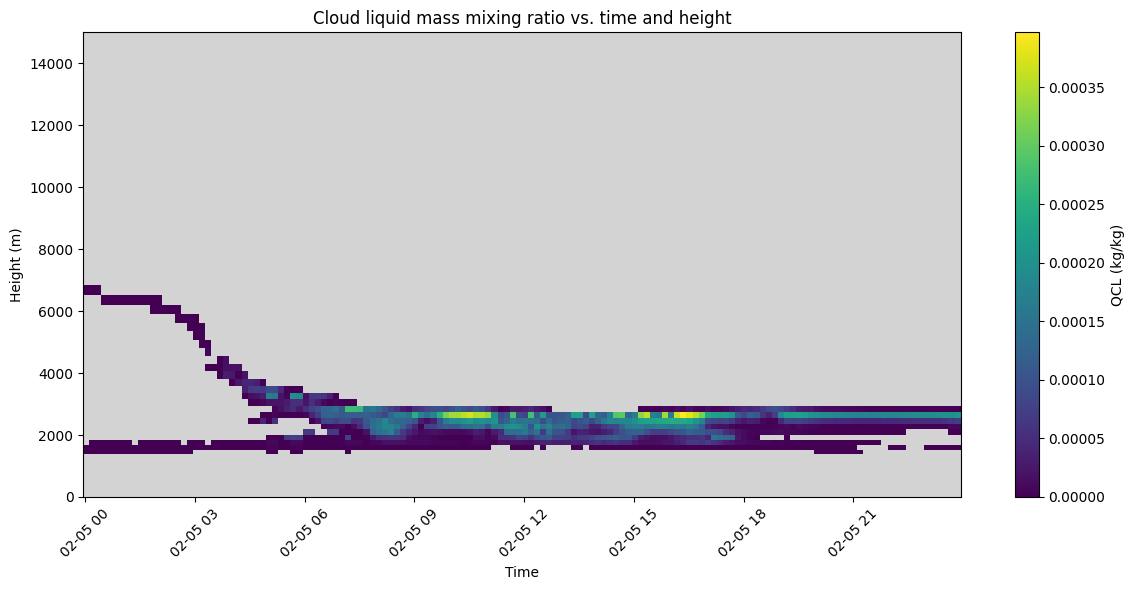

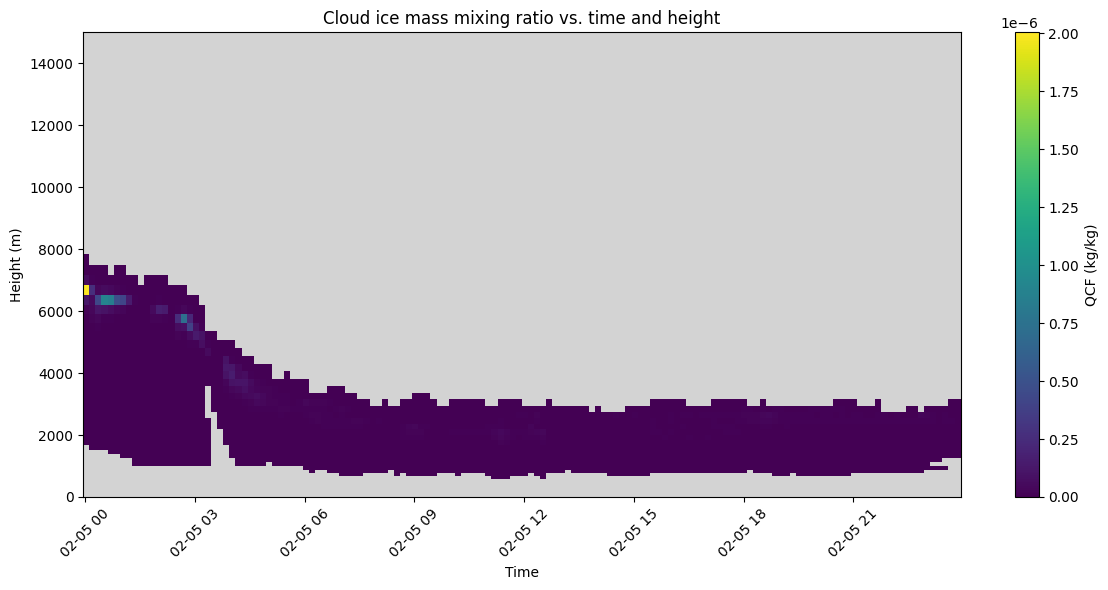

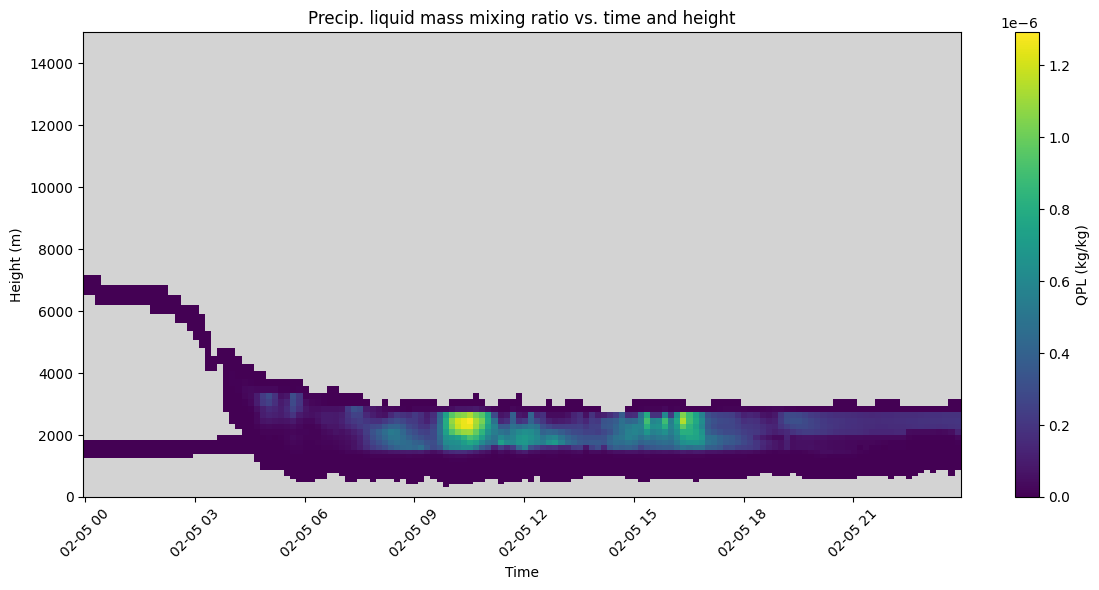

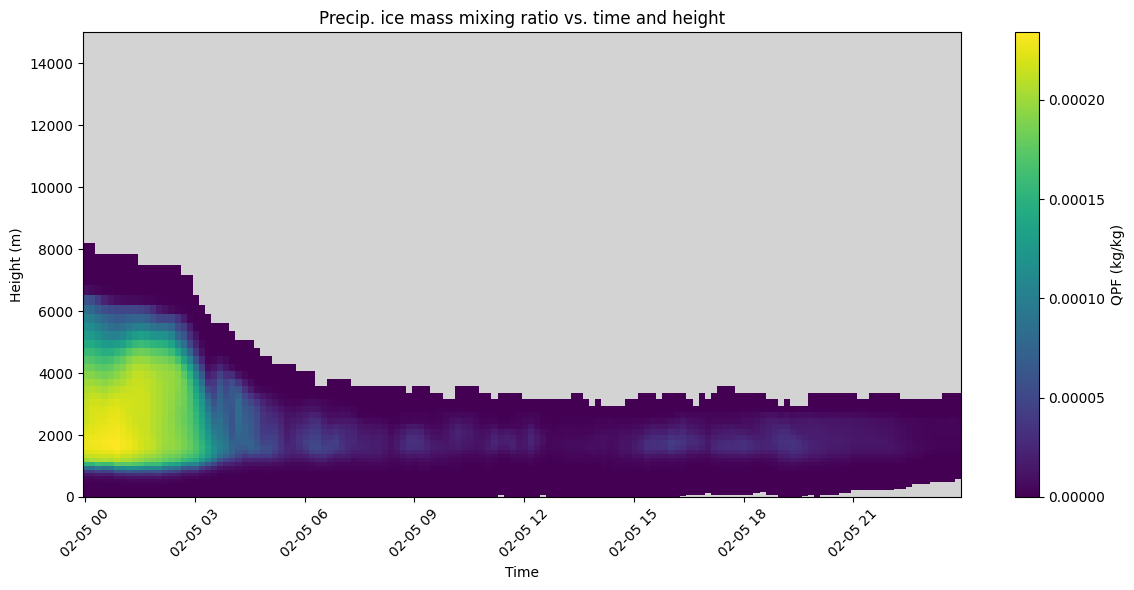

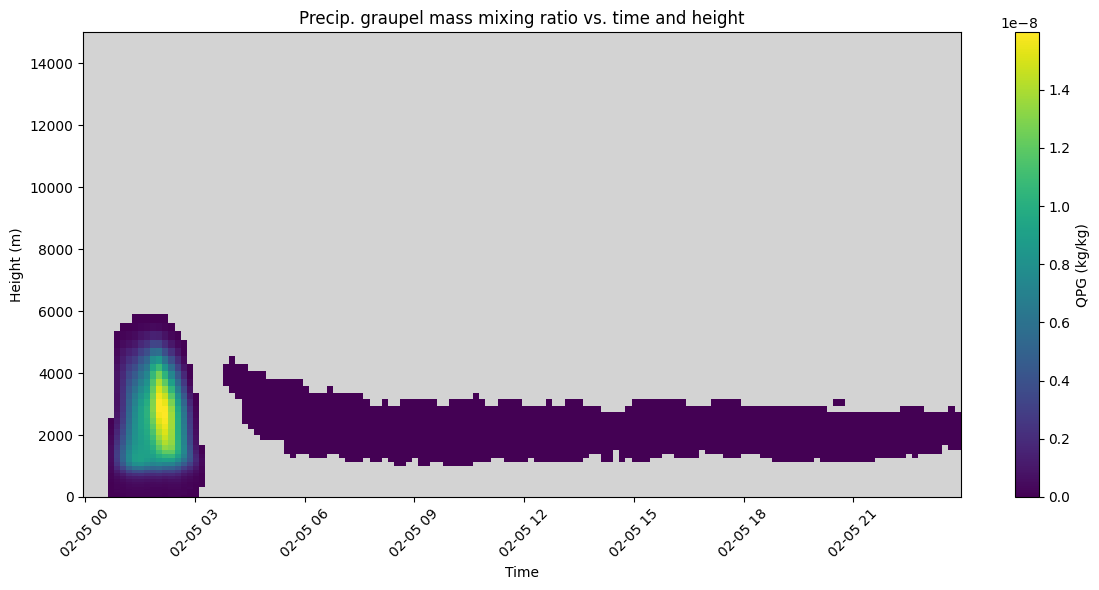

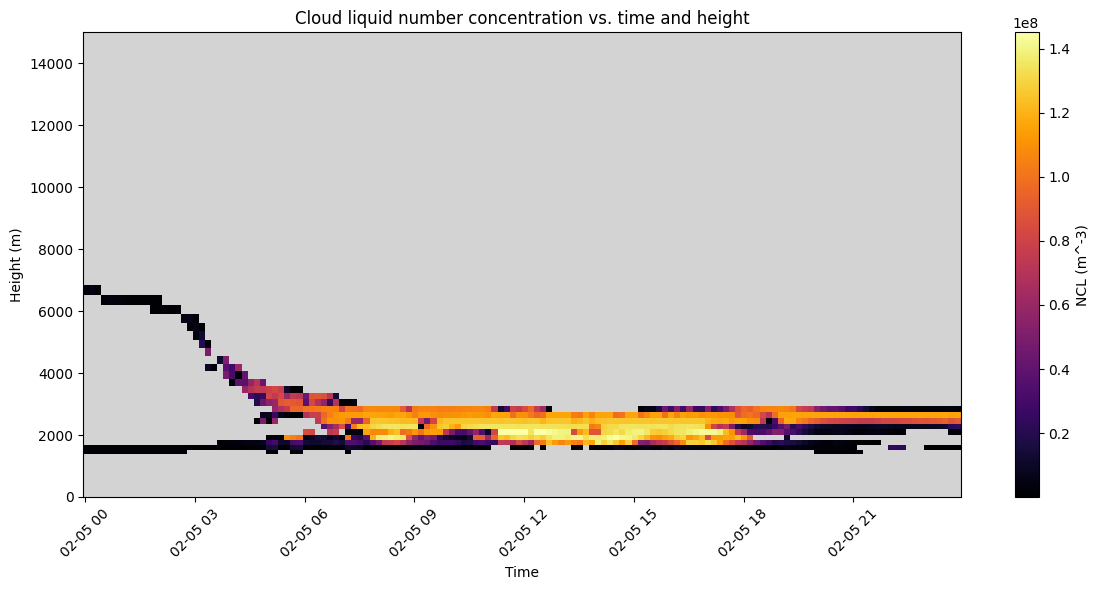

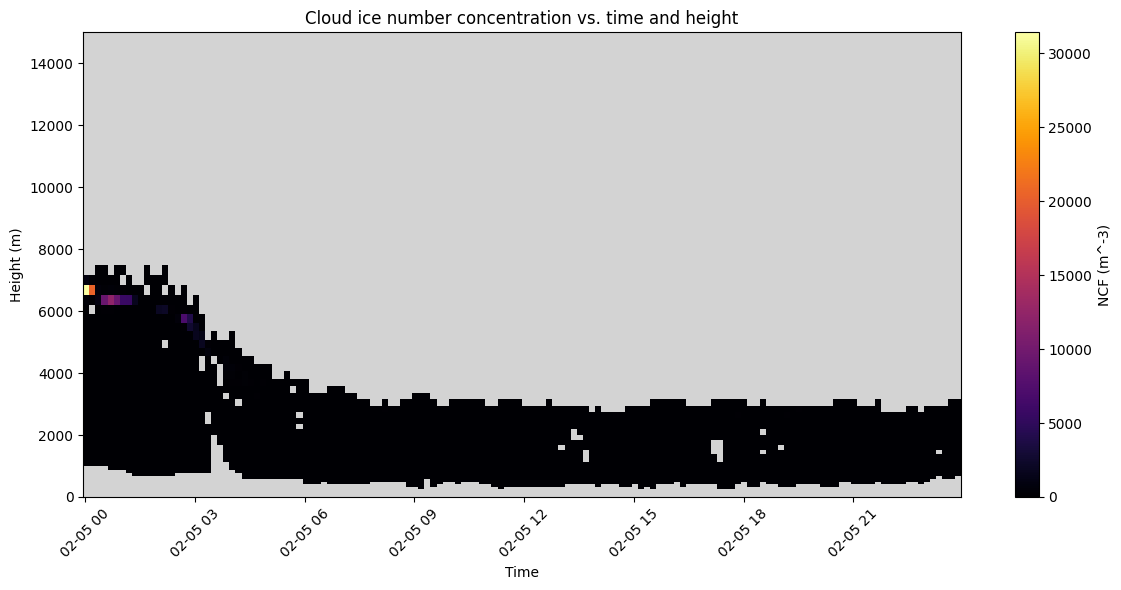

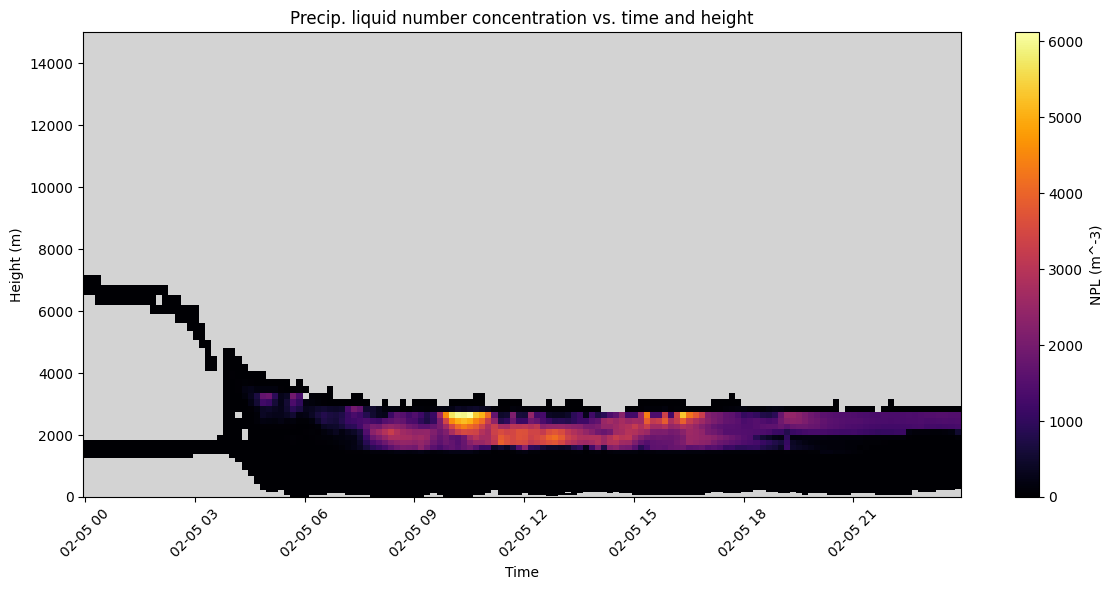

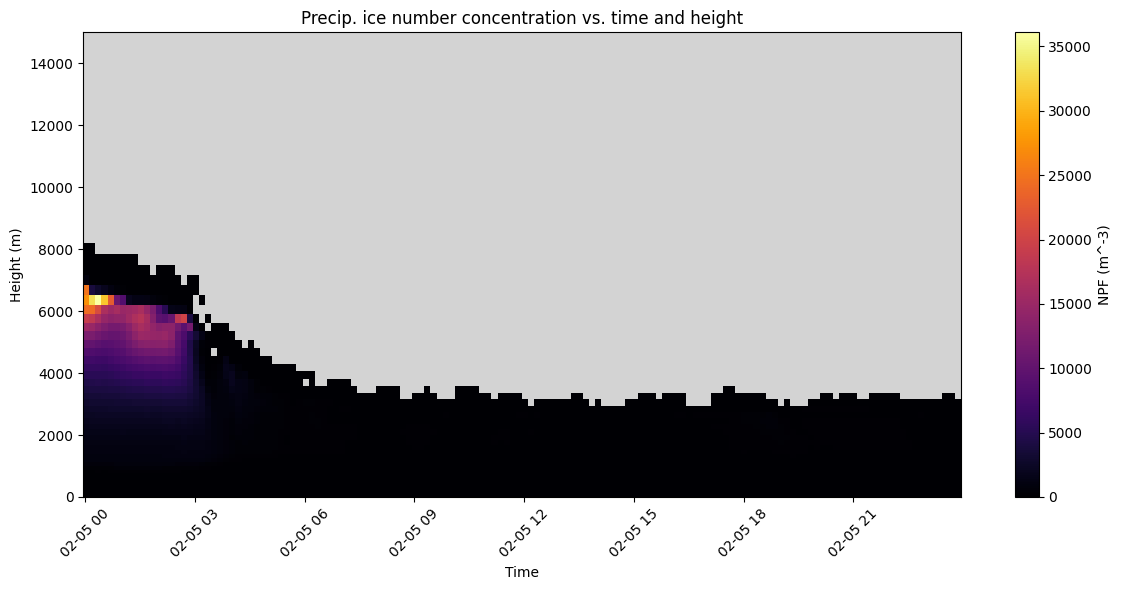

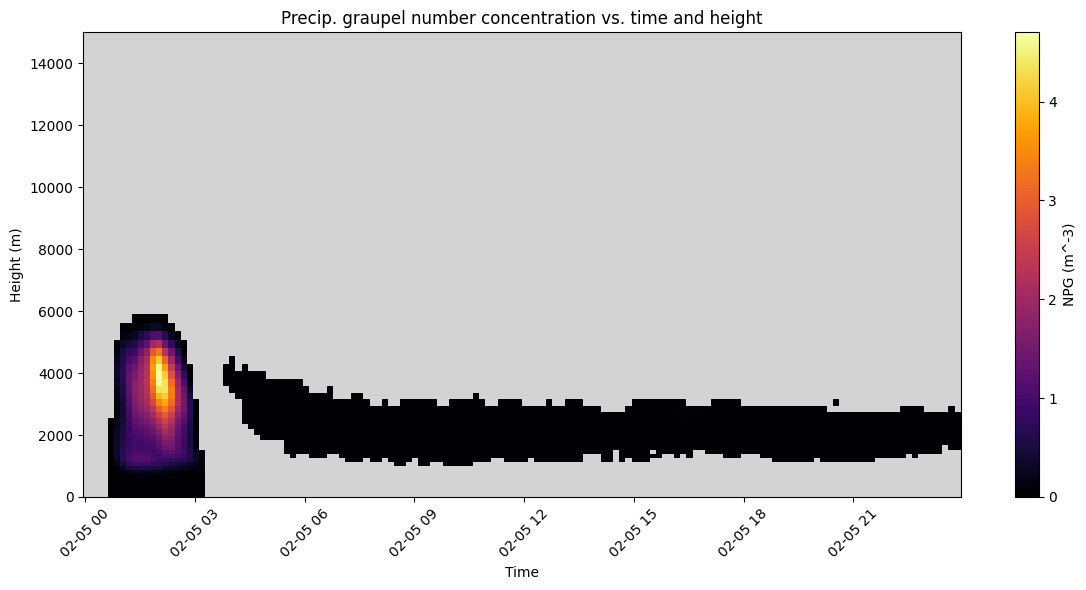

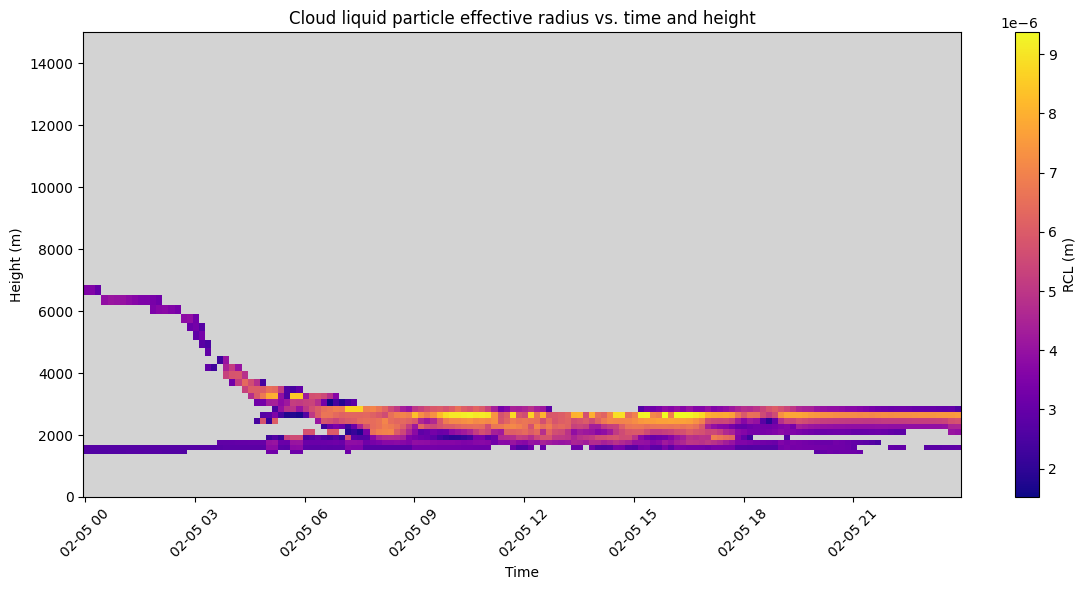

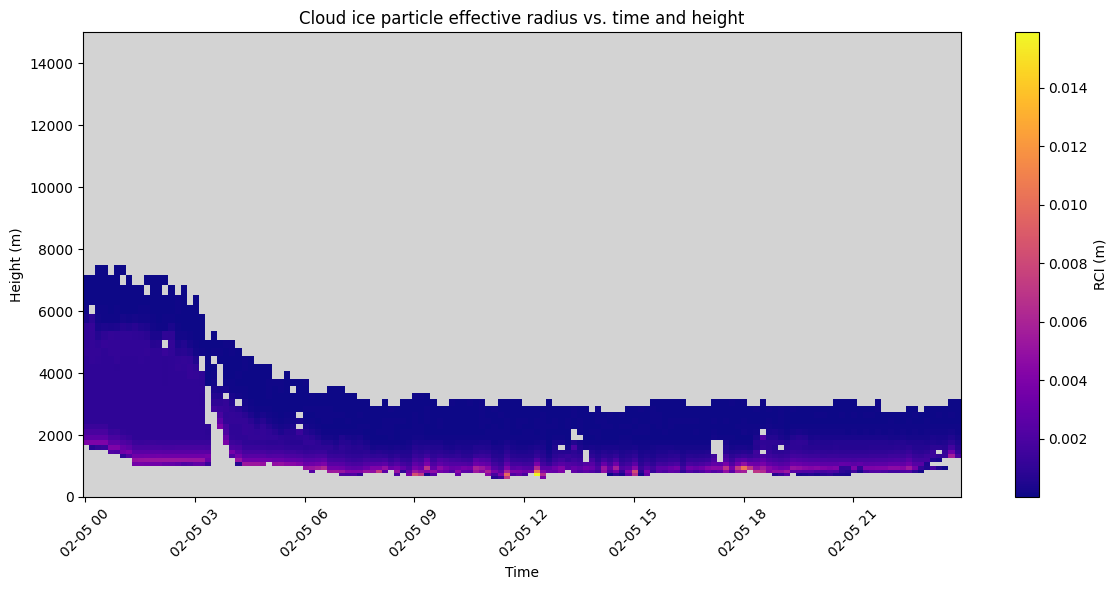

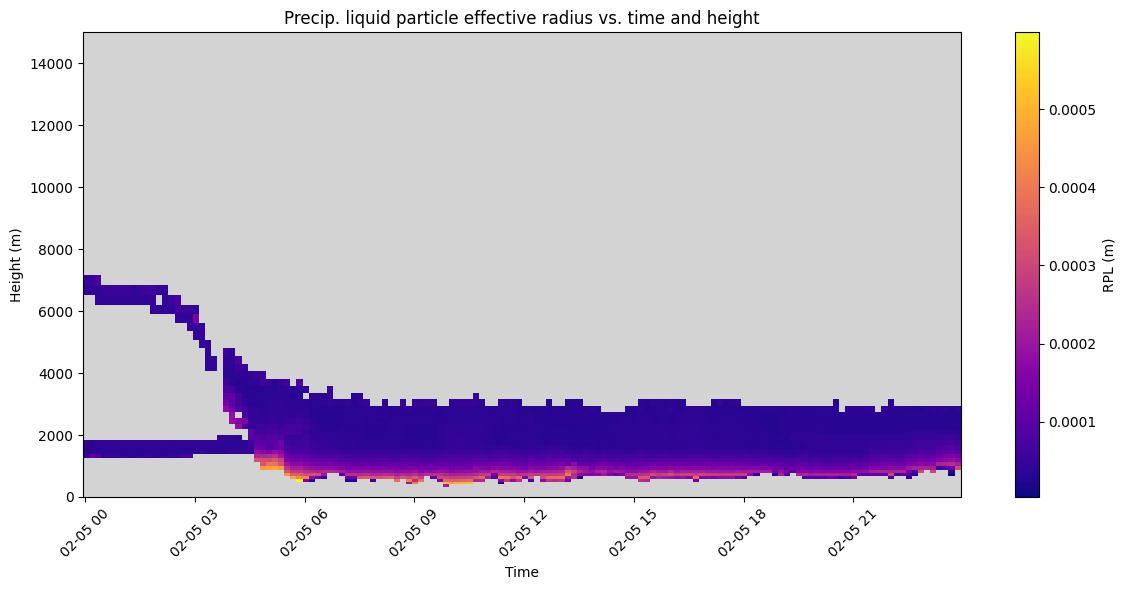

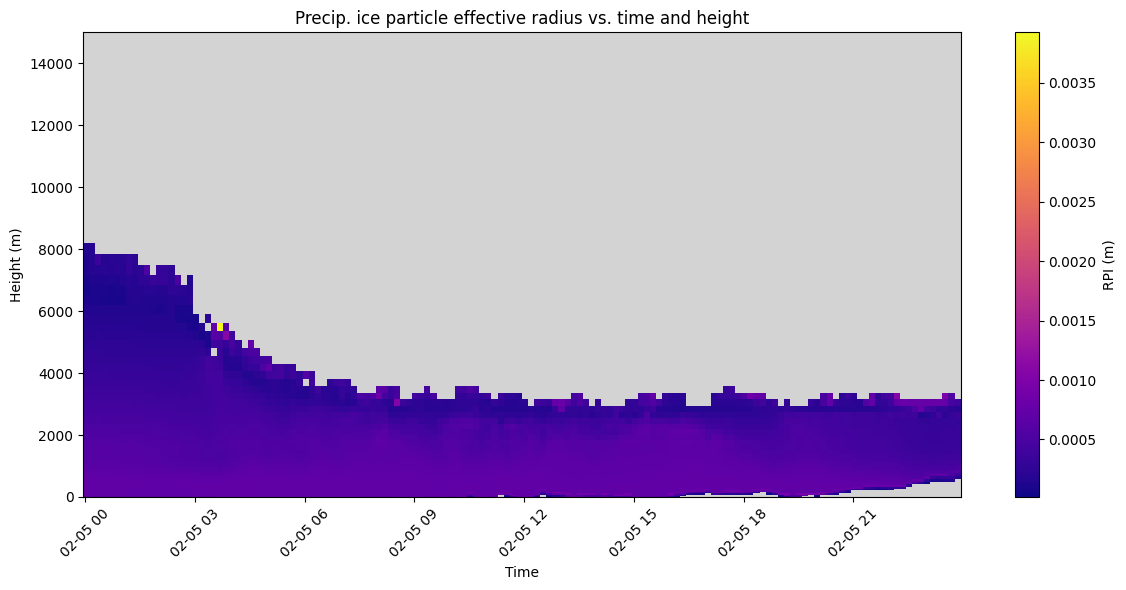

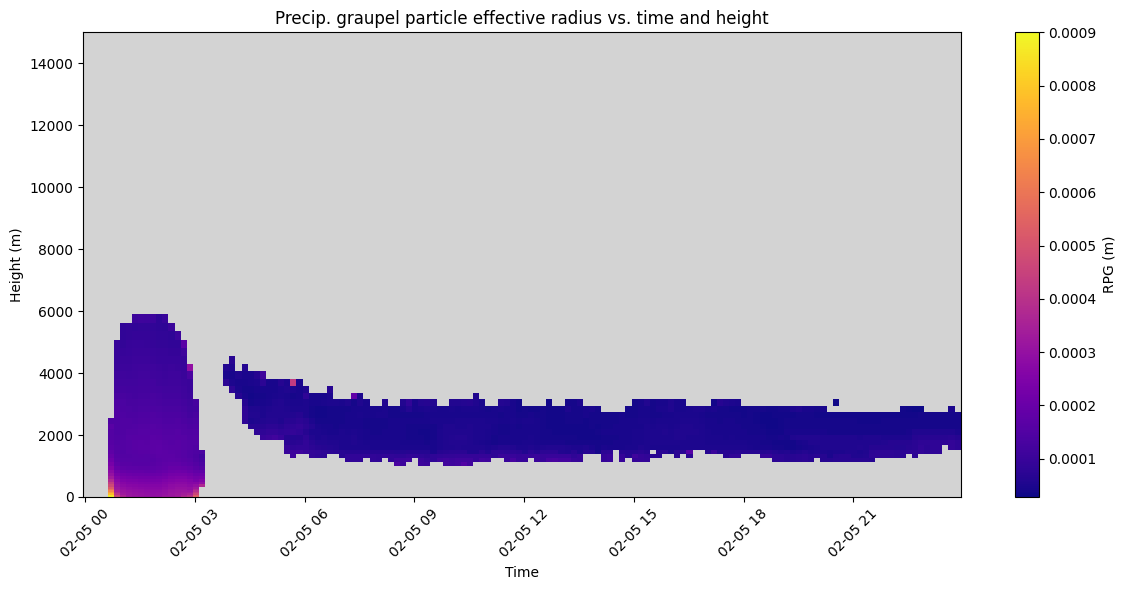

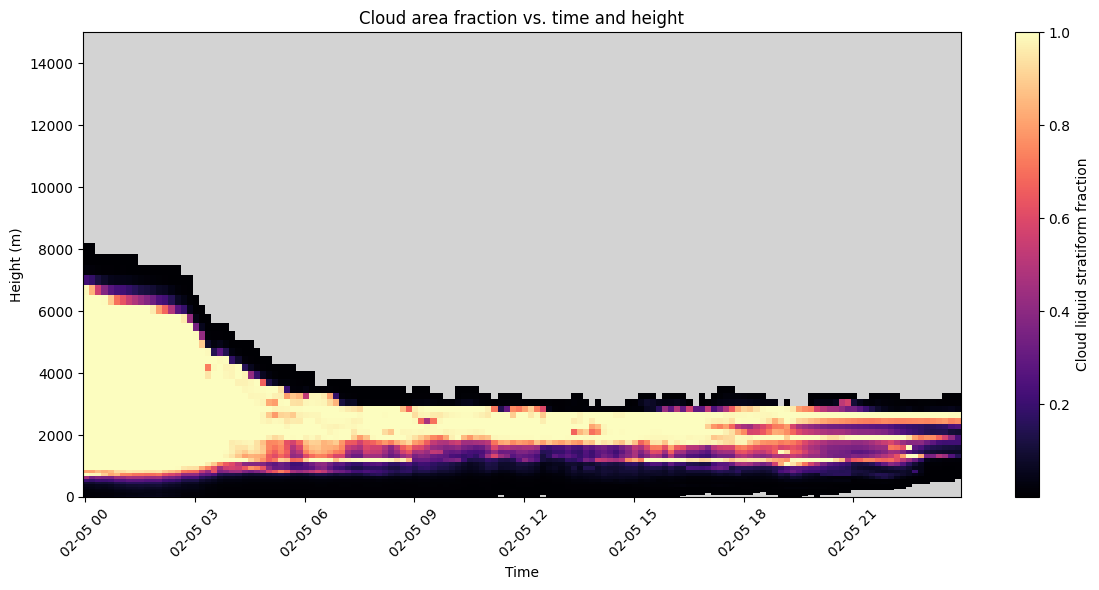

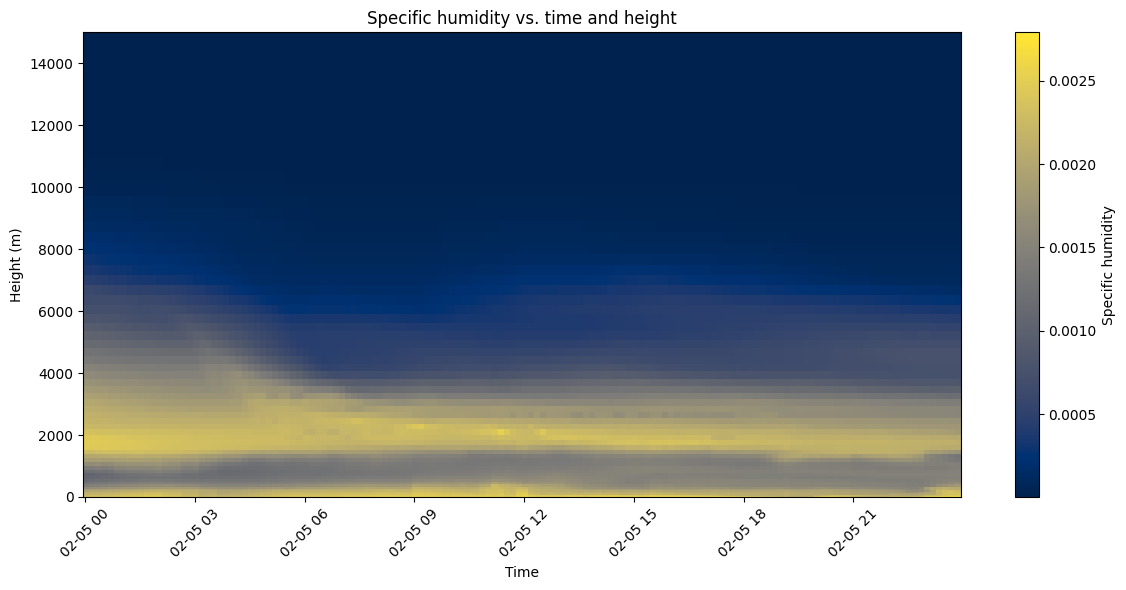

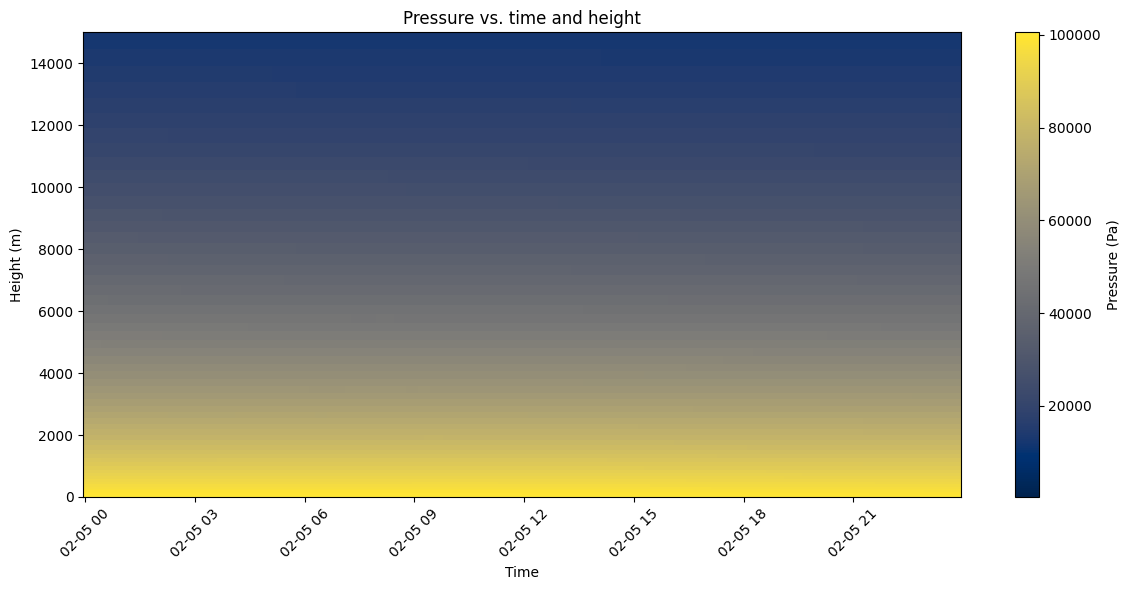

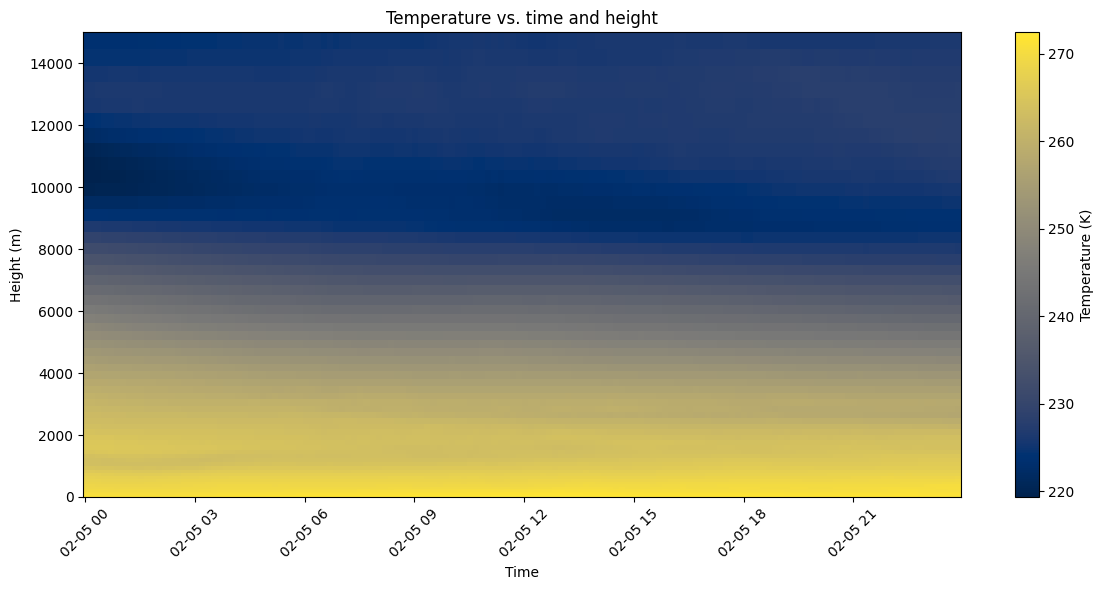

In [10]:
# Save test plots of atmospheric properties from UM_reg output for one day

# Save paths for images
plot_path = '/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_output_test'

# Set the current date for saving files
filepath = daily_UM_reg_list[0]
current_date = filepath.split('_')[4]
current_date = current_date.split('.')[0]

# Set the current file to the test file loaded earlier
daily_UM_reg_output = test

# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(daily_UM_reg_output['time'], daily_UM_reg_output['level_height'])

# Set the height limit for the plots
ylim_max = 15000

# QCL
# Extract the desired variable
QCL = test['mass_fraction_of_cloud_liquid_water_in_air']
# Set QCL values equal to 0 to grey
QCL_grey = np.where(QCL == 0, np.nan, QCL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, QCL_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'QCL (kg/kg)')
plt.title('Cloud liquid mass mixing ratio vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_QCL = plt.gcf()
# Save the plot
daily_UM_reg_QCL.savefig(f'{plot_path}/UM_reg_QCL_{current_date}', dpi = 200)

# QCF
# Extract the desired variable
QCF = test['mass_fraction_of_cloud_ice_crystals_in_air']
# Set QCF values equal to 0 to grey
QCF_grey = np.where(QCF == 0, np.nan, QCF)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, QCF_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'QCF (kg/kg)')
plt.title('Cloud ice mass mixing ratio vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_QCF = plt.gcf()
# Save the plot
daily_UM_reg_QCF.savefig(f'{plot_path}/UM_reg_QCF_{current_date}', dpi = 200)

# QPL
# Extract the desired variable
QPL = test['mass_fraction_of_rain_in_air']
# Set QPL values equal to 0 to grey
QPL_grey = np.where(QPL == 0, np.nan, QPL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, QPL_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'QPL (kg/kg)')
plt.title('Precip. liquid mass mixing ratio vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_QPL = plt.gcf()
# Save the plot
daily_UM_reg_QPL.savefig(f'{plot_path}/UM_reg_QPL_{current_date}', dpi = 200)

# QPF
# Extract the desired variable
QPF = test['mass_fraction_of_cloud_ice_in_air']
# Set QPF values equal to 0 to grey
QPF_grey = np.where(QPF == 0, np.nan, QPF)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, QPF_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'QPF (kg/kg)')
plt.title('Precip. ice mass mixing ratio vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_QPF = plt.gcf()
# Save the plot
daily_UM_reg_QPF.savefig(f'{plot_path}/UM_reg_QPF_{current_date}', dpi = 200)

# QPG
# Extract the desired variable
QPG = test['mass_fraction_of_graupel_in_air']
# Set QPG values equal to 0 to grey
QPG_grey = np.where(QPG == 0, np.nan, QPG)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, QPG_grey.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'QPG (kg/kg)')
plt.title('Precip. graupel mass mixing ratio vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_QPG = plt.gcf()
# Save the plot
daily_UM_reg_QPG.savefig(f'{plot_path}/UM_reg_QPG_{current_date}', dpi = 200)

# NCL
# Extract the desired variable
NCL = test['number_of_cloud_droplets_per_kg_of_air']
# Set NCL values equal to 0 to grey
NCL_grey = np.where(NCL == 0, np.nan, NCL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, NCL_grey.T, cmap = 'inferno', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'NCL (m^-3)')
plt.title('Cloud liquid number concentration vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_NCL = plt.gcf()
# Save the plot
daily_UM_reg_NCL.savefig(f'{plot_path}/UM_reg_NCL_{current_date}', dpi = 200)

# NCF
# Extract the desired variable
NCF = test['number_of_ice_particles_per_kg_of_air']
# Set NCF values equal to 0 to grey
NCF_grey = np.where(NCF == 0, np.nan, NCF)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, NCF_grey.T, cmap = 'inferno', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'NCF (m^-3)')
plt.title('Cloud ice number concentration vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_NCF = plt.gcf()
# Save the plot
daily_UM_reg_NCF.savefig(f'{plot_path}/UM_reg_NCF_{current_date}', dpi = 200)

# NPL
# Extract the desired variable
NPL = test['number_of_rain_drops_per_kg_of_air']
# Set NPL values equal to 0 to grey
NPL_grey = np.where(NPL == 0, np.nan, NPL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, NPL_grey.T, cmap = 'inferno', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'NPL (m^-3)')
plt.title('Precip. liquid number concentration vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_NPL = plt.gcf()
# Save the plot
daily_UM_reg_NPL.savefig(f'{plot_path}/UM_reg_NPL_{current_date}', dpi = 200)

# NPF
# Extract the desired variable
NPF = test['number_of_snow_aggregates_per_kg_of_air']
# Set NPF values equal to 0 to grey
NPF_grey = np.where(NPF == 0, np.nan, NPF)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, NPF_grey.T, cmap = 'inferno', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'NPF (m^-3)')
plt.title('Precip. ice number concentration vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_NPF = plt.gcf()
# Save the plot
daily_UM_reg_NPF.savefig(f'{plot_path}/UM_reg_NPF_{current_date}', dpi = 200)

# NPG
# Extract the desired variable
NPG = test['number_of_graupel_particles_per_kg_of_air']
# Set NPG values equal to 0 to grey
NPG_grey = np.where(NPG == 0, np.nan, NPG)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, NPG_grey.T, cmap = 'inferno', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'NPG (m^-3)')
plt.title('Precip. graupel number concentration vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_NPG = plt.gcf()
# Save the plot
daily_UM_reg_NPG.savefig(f'{plot_path}/UM_reg_NPG_{current_date}', dpi = 200)

# RCL
# Extract the desired variable
RCL = test['cloud_liquid_effective_radius']
# Set RCL values equal to 0 to grey
RCL_grey = np.where(RCL == 0, np.nan, RCL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, RCL_grey.T, cmap = 'plasma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'RCL (m)')
plt.title('Cloud liquid particle effective radius vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_RCL = plt.gcf()
# Save the plot
daily_UM_reg_RCL.savefig(f'{plot_path}/UM_reg_RCL_{current_date}', dpi = 200)

# RCI
# Extract the desired variable
RCI = test['cloud_ice_effective_radius']
# Set RCI values equal to 0 to grey
RCI_grey = np.where(RCI == 0, np.nan, RCI)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, RCI_grey.T, cmap = 'plasma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'RCI (m)')
plt.title('Cloud ice particle effective radius vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_RCI = plt.gcf()
# Save the plot
daily_UM_reg_RCI.savefig(f'{plot_path}/UM_reg_RCI_{current_date}', dpi = 200)

# RPL
# Extract the desired variable
RPL = test['precip_liquid_effective_radius']
# Set RPL values equal to 0 to grey
RPL_grey = np.where(RPL == 0, np.nan, RPL)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, RPL_grey.T, cmap = 'plasma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'RPL (m)')
plt.title('Precip. liquid particle effective radius vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_RPL = plt.gcf()
# Save the plot
daily_UM_reg_RPL.savefig(f'{plot_path}/UM_reg_RPL_{current_date}', dpi = 200)

# RPI
# Extract the desired variable
RPI = test['precip_ice_effective_radius']
# Set RPI values equal to 0 to grey
RPI_grey = np.where(RPI == 0, np.nan, RPI)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, RPI_grey.T, cmap = 'plasma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'RPI (m)')
plt.title('Precip. ice particle effective radius vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_RPI = plt.gcf()
# Save the plot
daily_UM_reg_RPI.savefig(f'{plot_path}/UM_reg_RPI_{current_date}', dpi = 200)

# RPG
# Extract the desired variable
RPG = test['precip_graupel_effective_radius']
# Set RPG values equal to 0 to grey
RPG_grey = np.where(RPG == 0, np.nan, RPG)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, RPG_grey.T, cmap = 'plasma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'RPG (m)')
plt.title('Precip. graupel particle effective radius vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_RPG = plt.gcf()
# Save the plot
daily_UM_reg_RPG.savefig(f'{plot_path}/UM_reg_RPG_{current_date}', dpi = 200)

# Cloud liquid stratiform fraction
# Extract the desired variable
cl_strat_frac = test['cloud_area_fraction_in_atmosphere_layer']
# Set cl_strat_frac values equal to 0 to grey
cl_strat_frac_grey = np.where(cl_strat_frac == 0, np.nan, cl_strat_frac)
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, cl_strat_frac_grey.T, cmap = 'magma', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Cloud liquid stratiform fraction')
plt.title('Cloud area fraction vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_cl_strat_frac = plt.gcf()
# Save the plot
daily_UM_reg_cl_strat_frac.savefig(f'{plot_path}/UM_reg_cl_strat_frac_{current_date}', dpi = 200)

# Water vapour mixing ratio
# Extract the desired variable
hus = daily_UM_reg_output['specific_humidity']
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, hus.T, cmap = 'cividis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Specific humidity')
plt.title('Specific humidity vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_hus = plt.gcf()
# Save the plot
daily_UM_reg_hus.savefig(f'{plot_path}/UM_reg_specific_humidity_{current_date}', dpi = 200)

# Pressure
# Extract the desired variable
pressure = test['air_pressure']
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, pressure.T, cmap = 'cividis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Pressure (Pa)')
plt.title('Pressure vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_pressure = plt.gcf()
# Save the plot
daily_UM_reg_pressure.savefig(f'{plot_path}/UM_reg_pressure_{current_date}', dpi = 200)

# Temperature
# Extract the desired variable
temperature = test['air_temperature']
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, temperature.T, cmap = 'cividis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Temperature (K)')
plt.title('Temperature vs. time and height')
plt.ylim(0, ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
daily_UM_reg_temperature = plt.gcf()
# Save the plot
daily_UM_reg_temperature.savefig(f'{plot_path}/UM_reg_temperature_{current_date}', dpi = 200)

print('Finished plotting')

# Plotting - multiple files

In [13]:
# Create the list of full filepaths to the daily files

# Set daily file parent folder
daily_filepath = '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/'
# List daily files in the parent folder
daily_UM_reg_list = os.listdir(path = daily_filepath)
# Create the list of daily filepaths
daily_UM_reg_list = [os.path.join(daily_filepath, file) for file in daily_UM_reg_list]
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
daily_UM_reg_list = sorted(daily_UM_reg_list, key = extract_date)
daily_UM_reg_list = [path for path in daily_UM_reg_list if 'old' not in path and '.ipynb_checkpoints' not in path and 'emc2_output' not in path]
daily_UM_reg_list

['/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180201.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180202.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180203.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180205.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180206.nc',
 '/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180207.nc']

Finished plotting


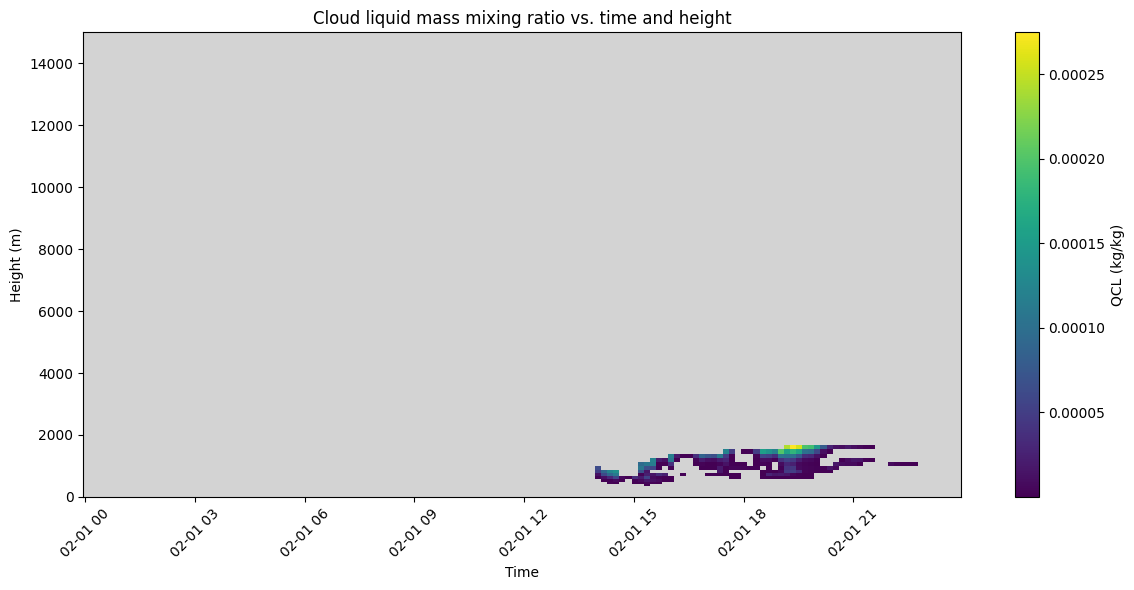

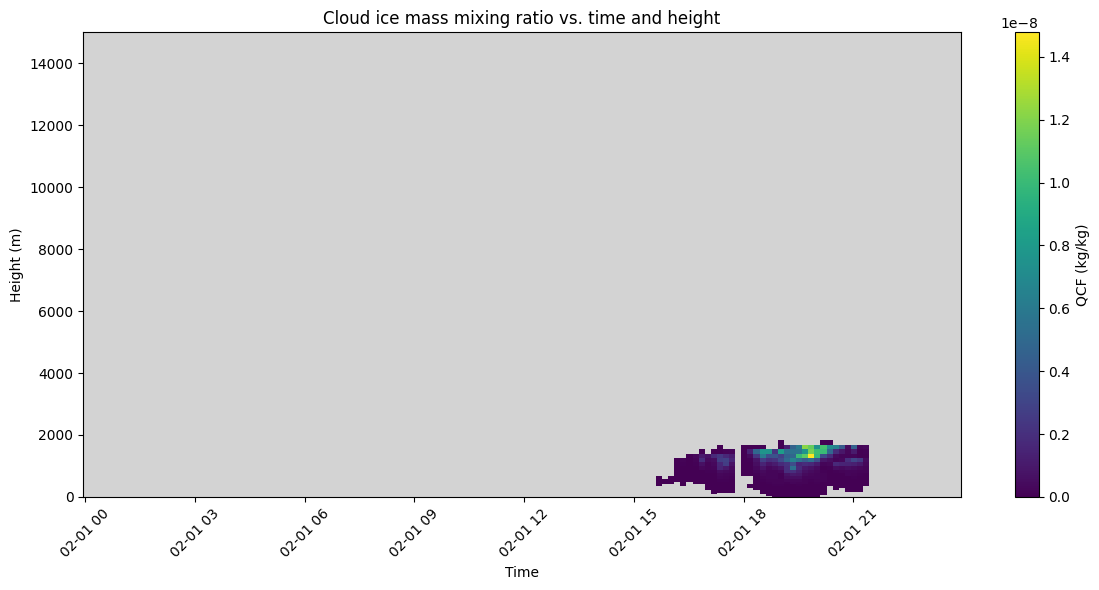

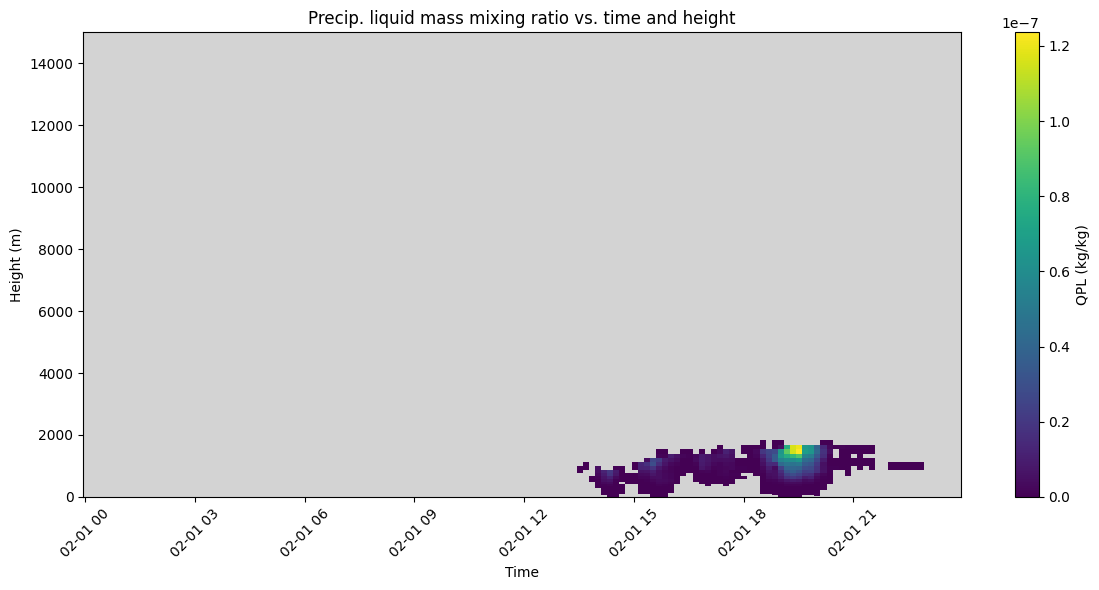

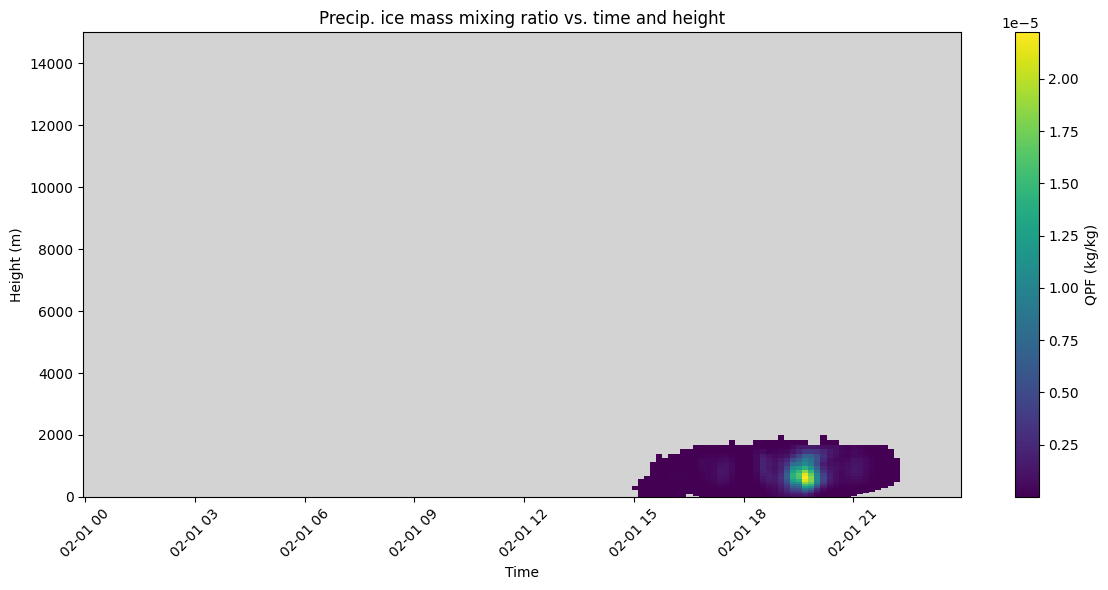

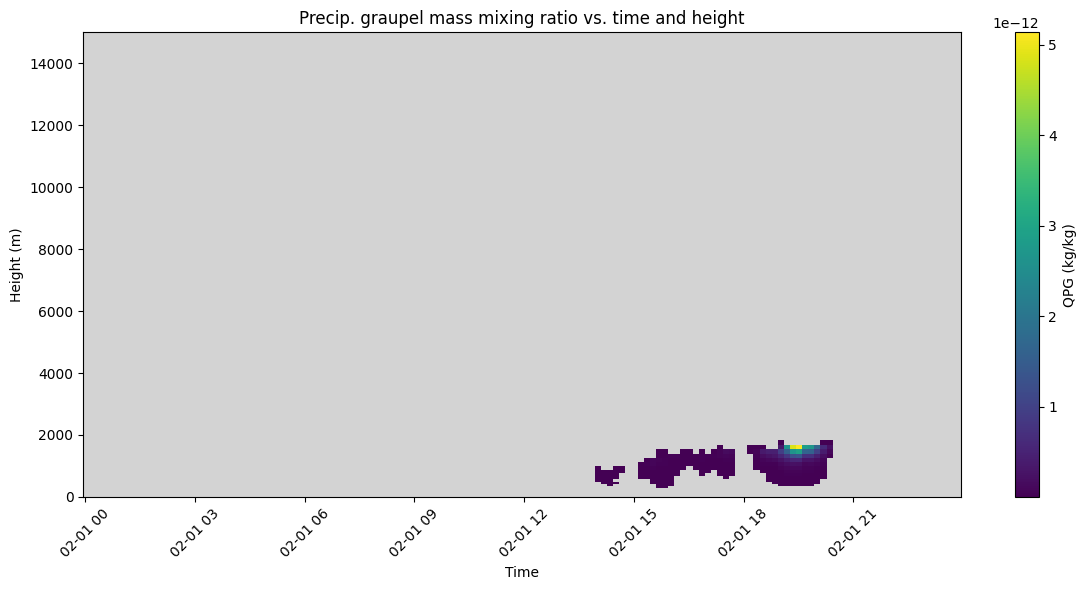

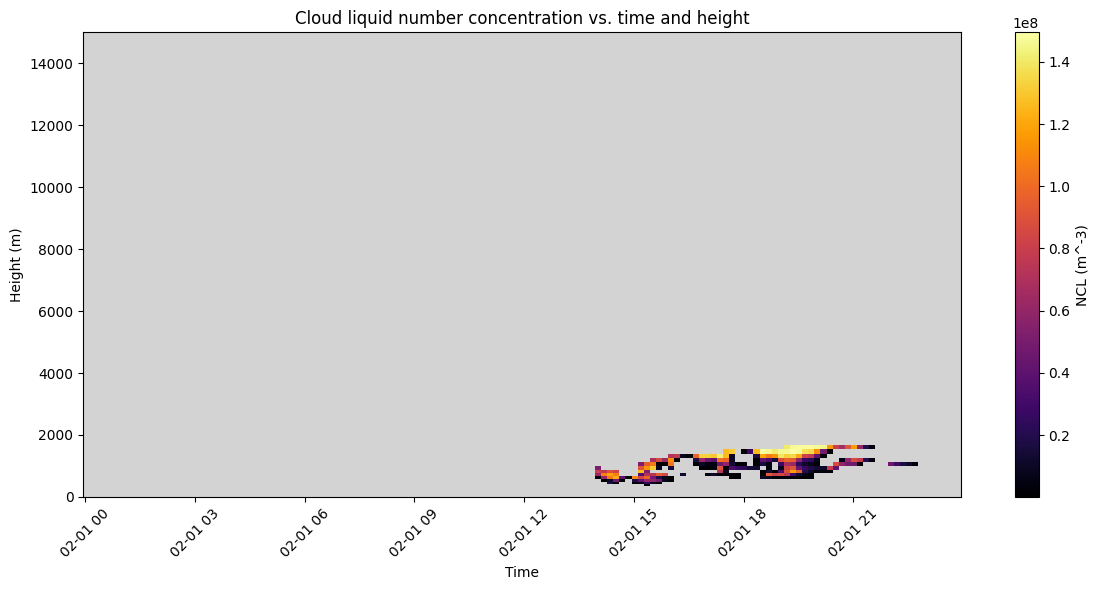

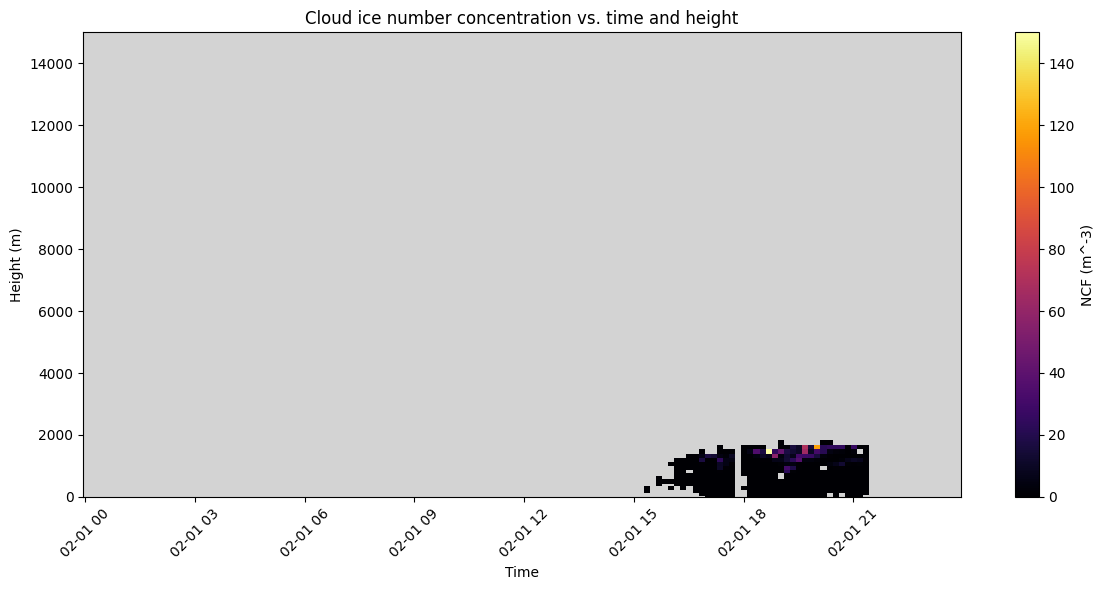

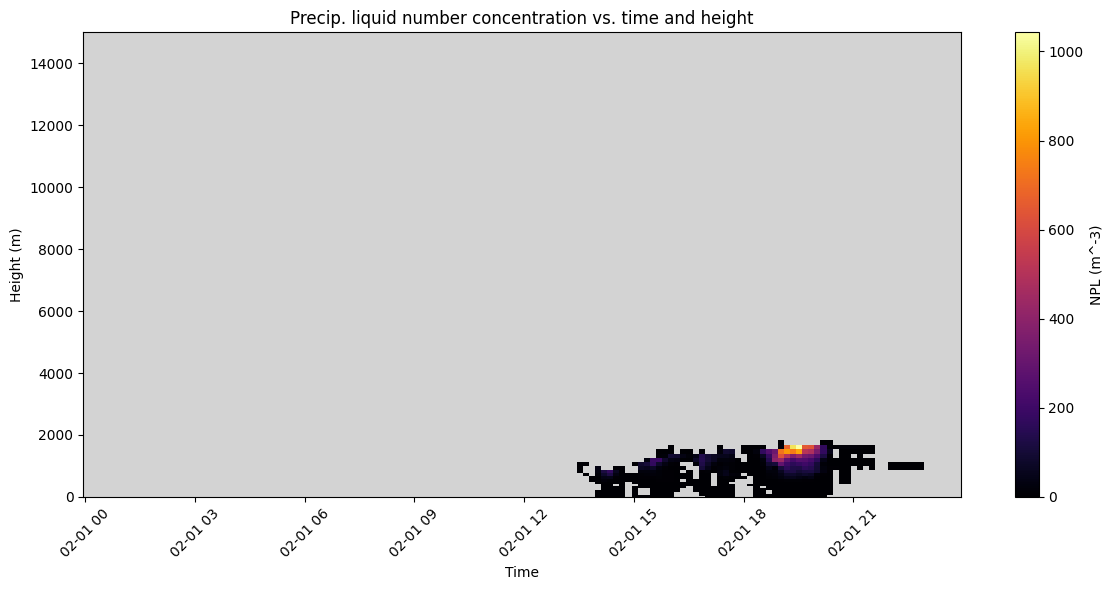

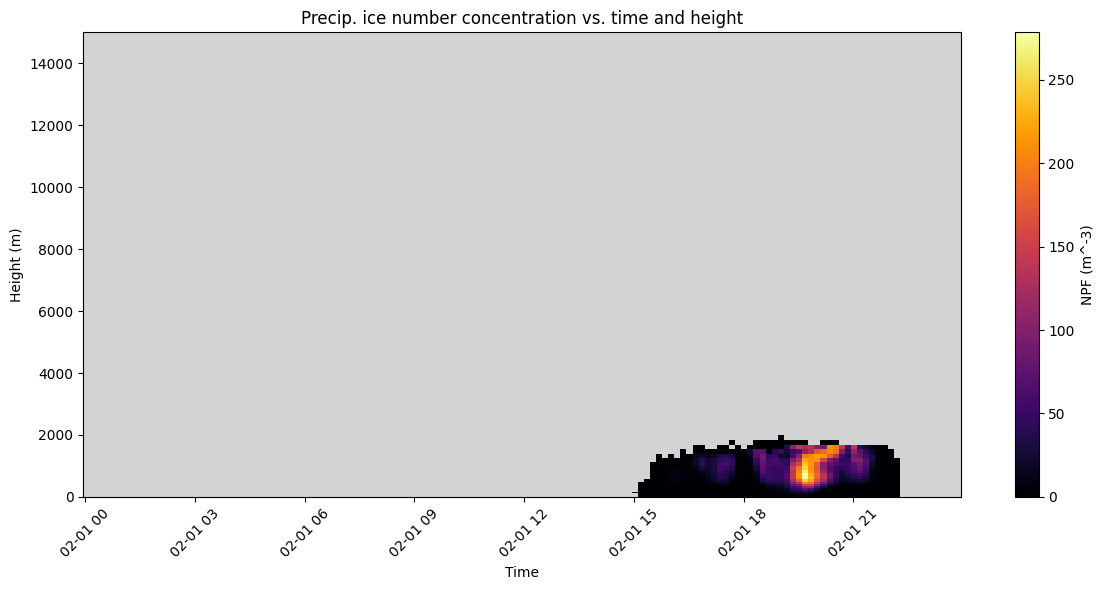

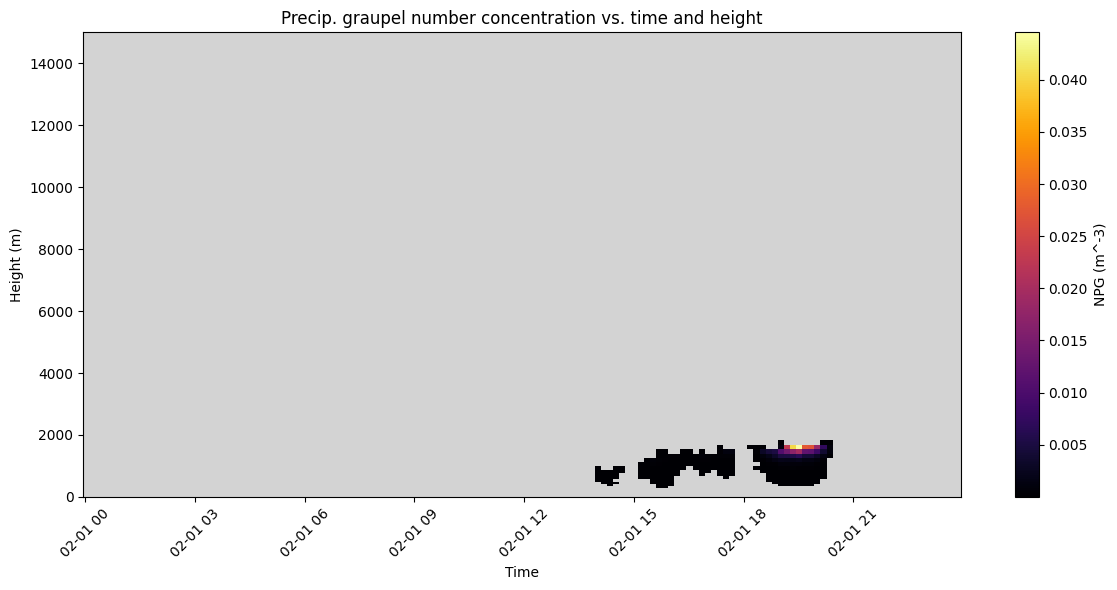

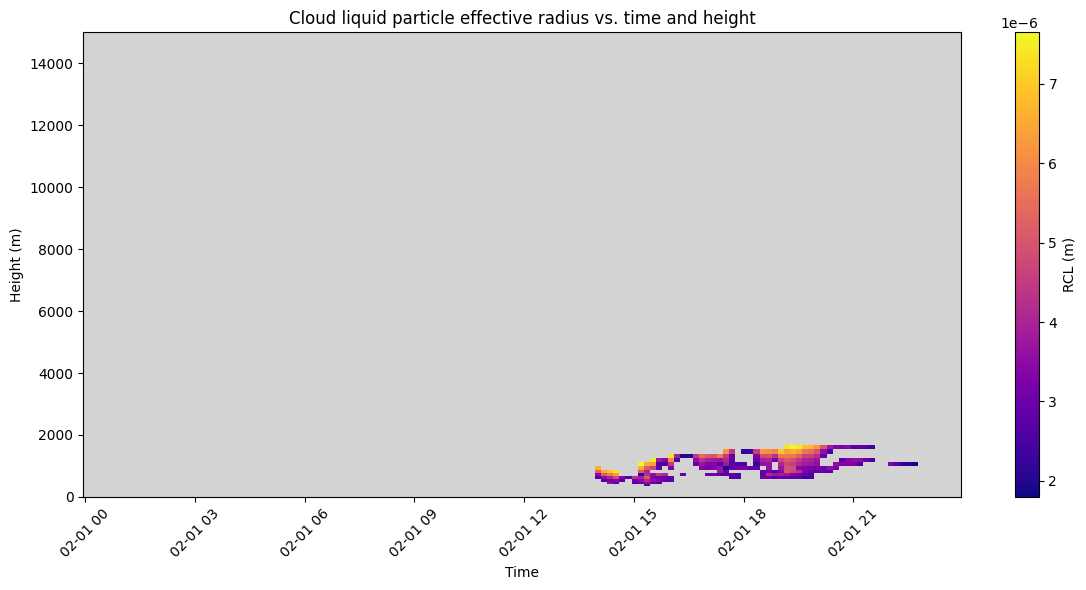

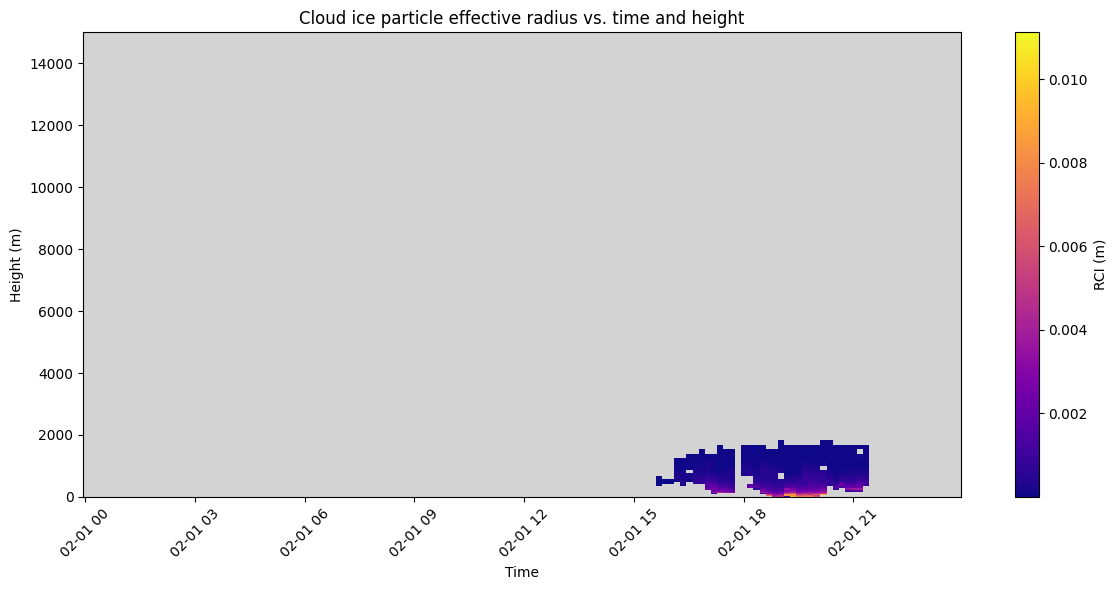

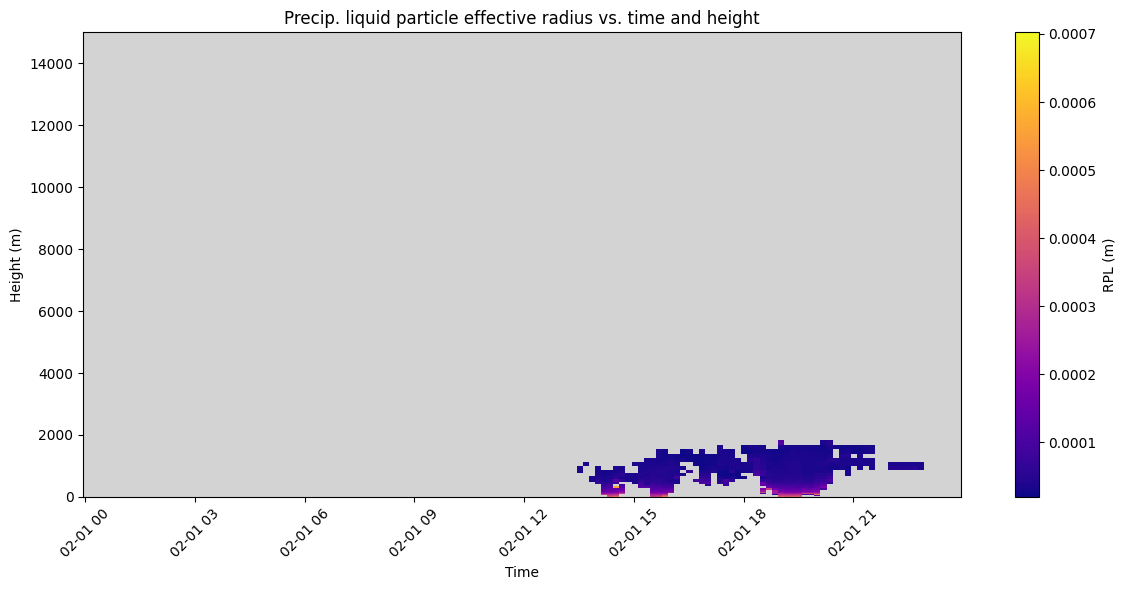

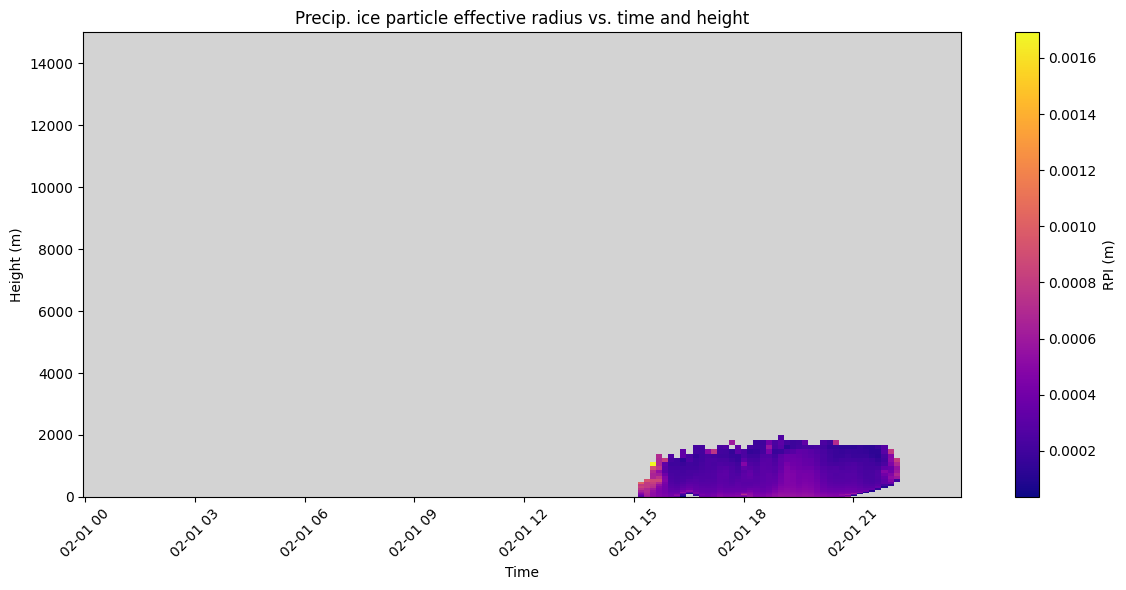

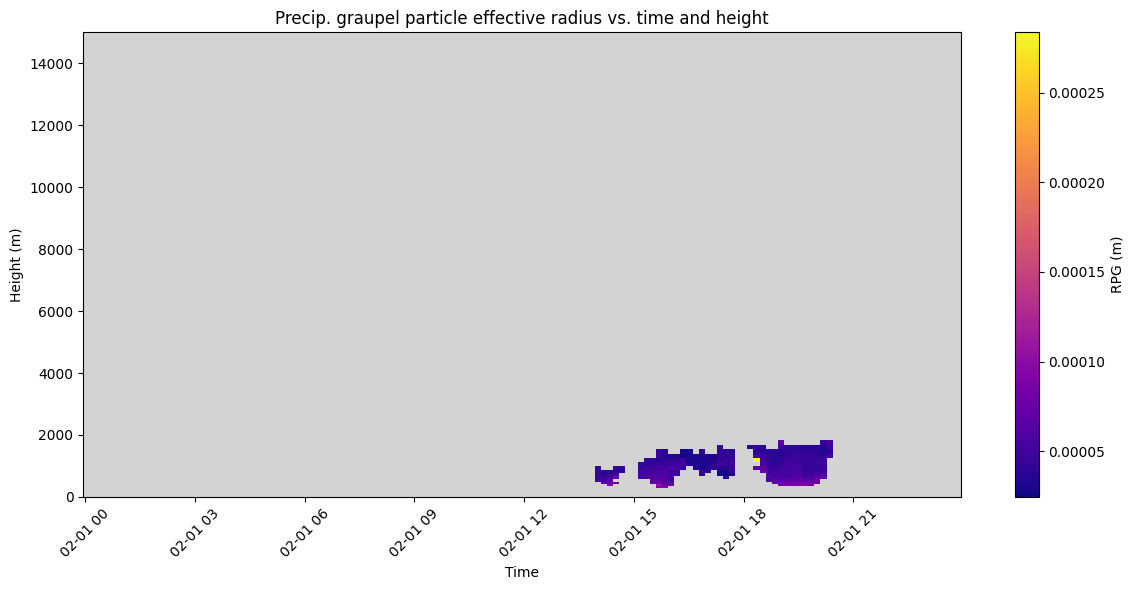

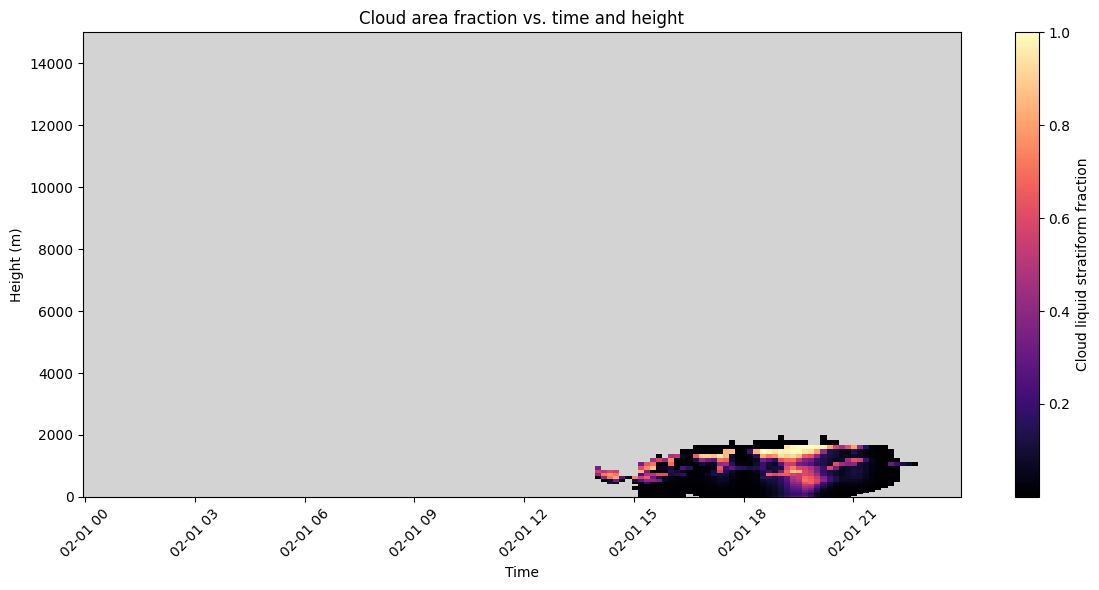

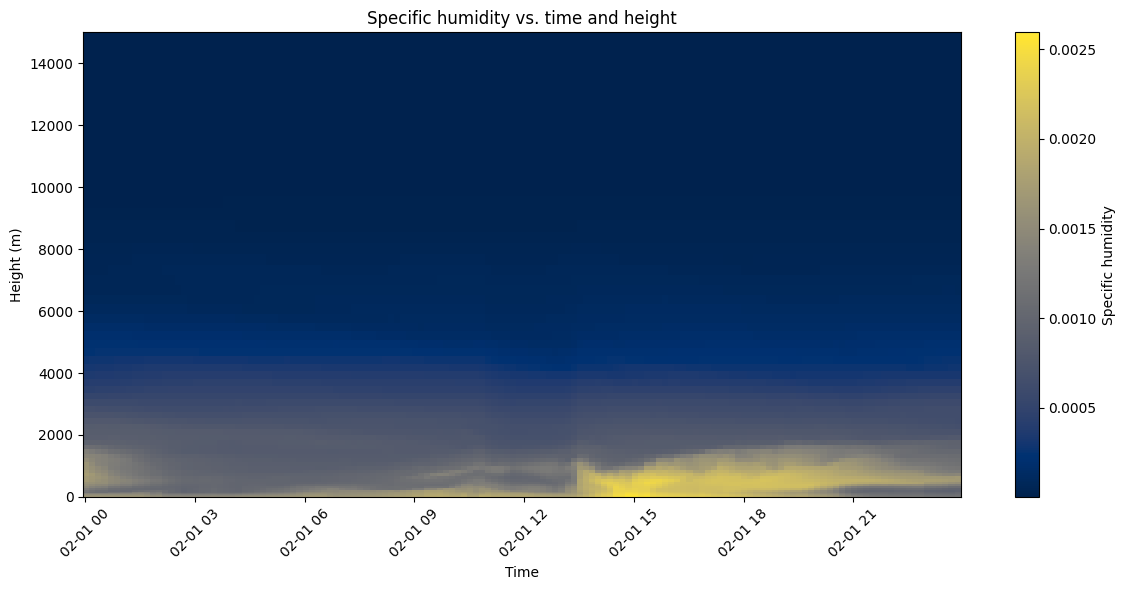

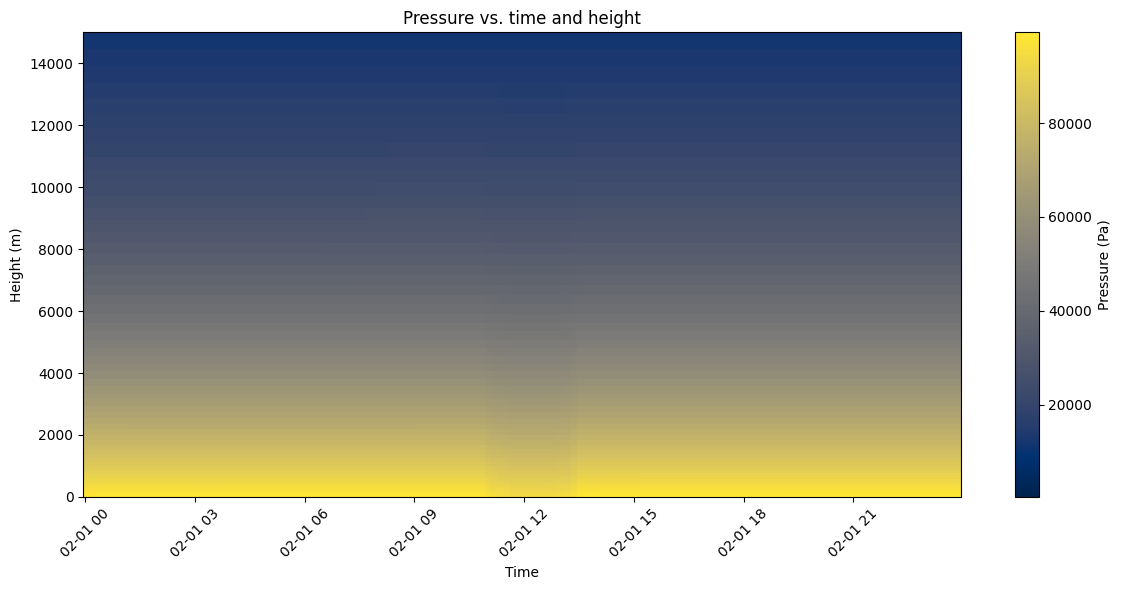

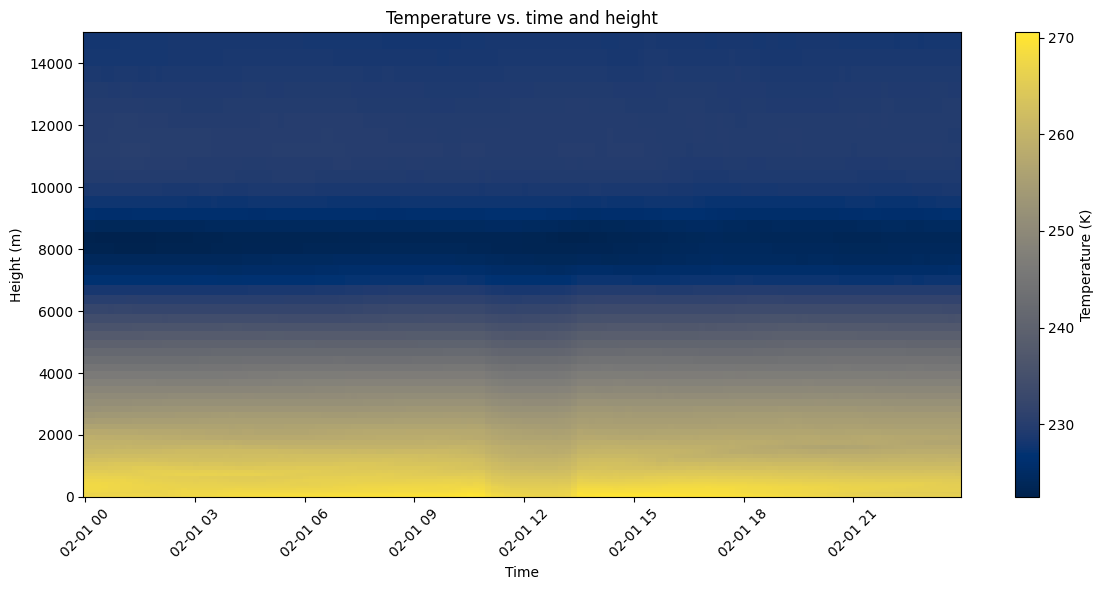

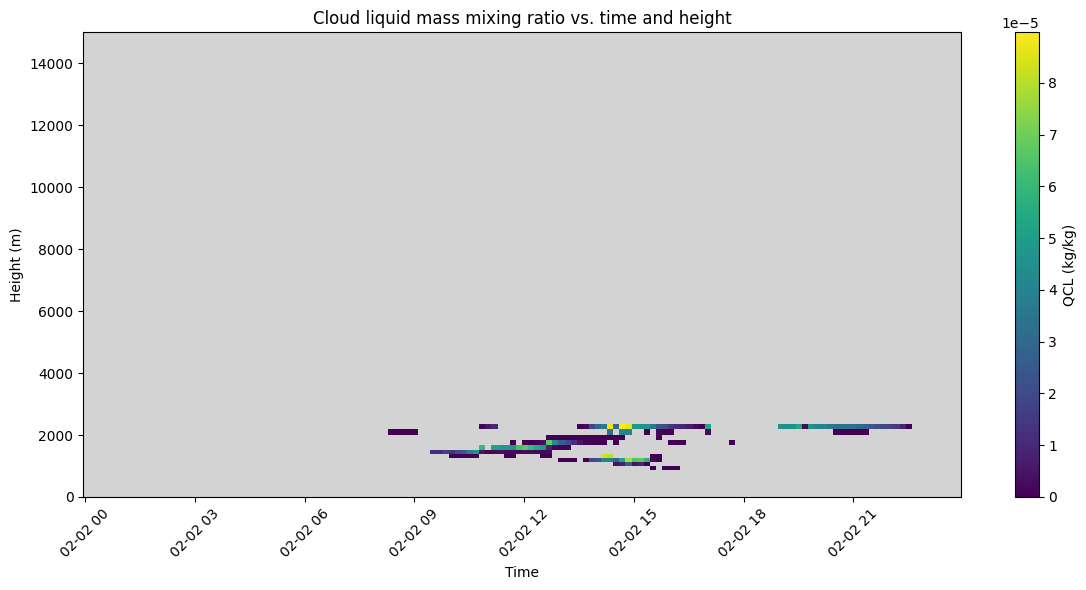

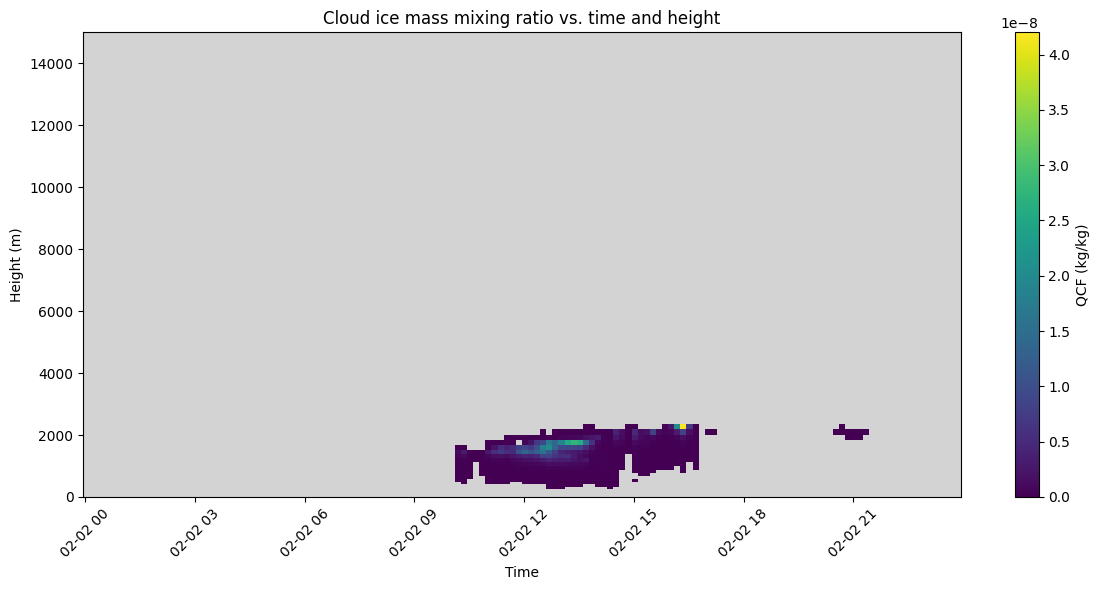

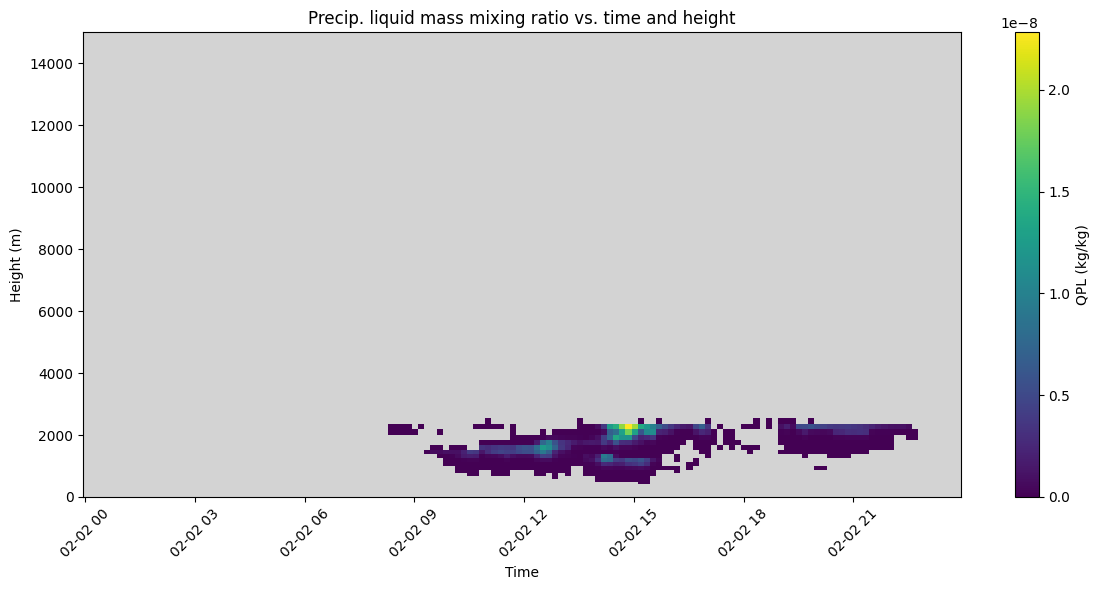

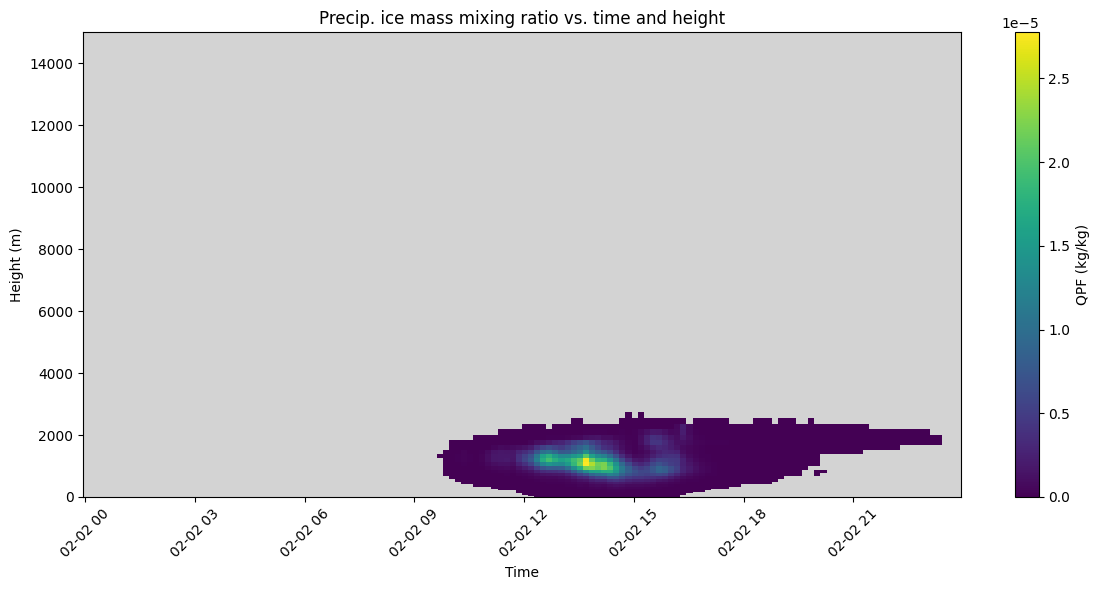

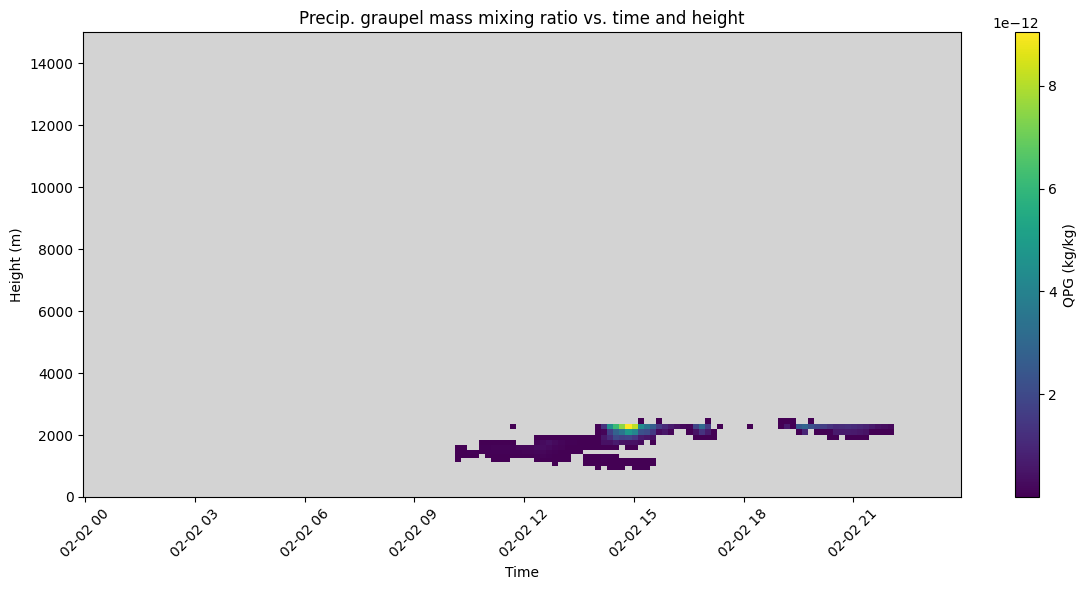

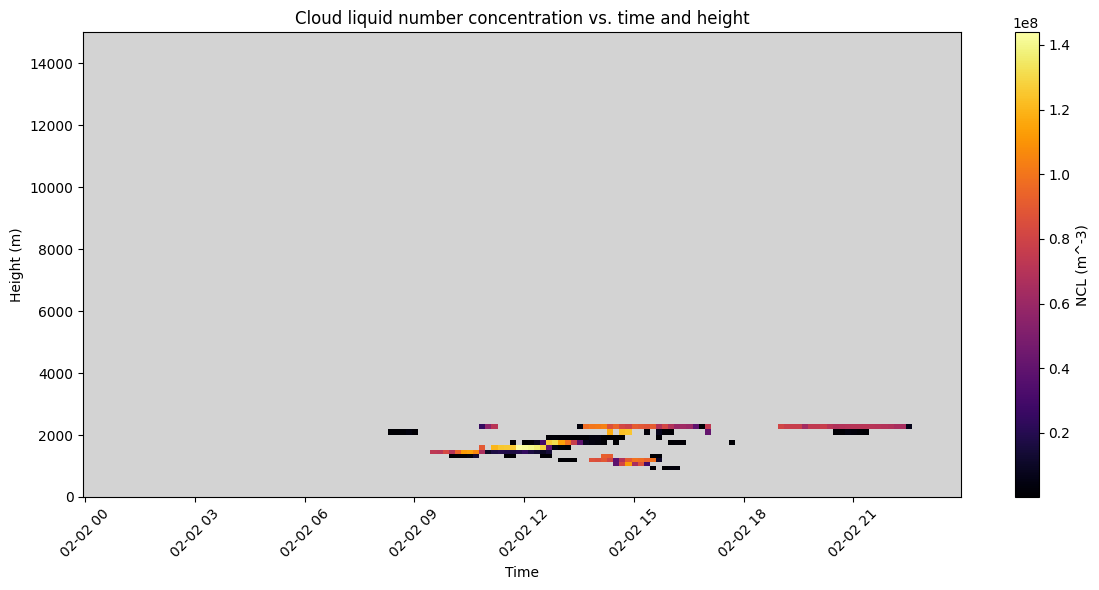

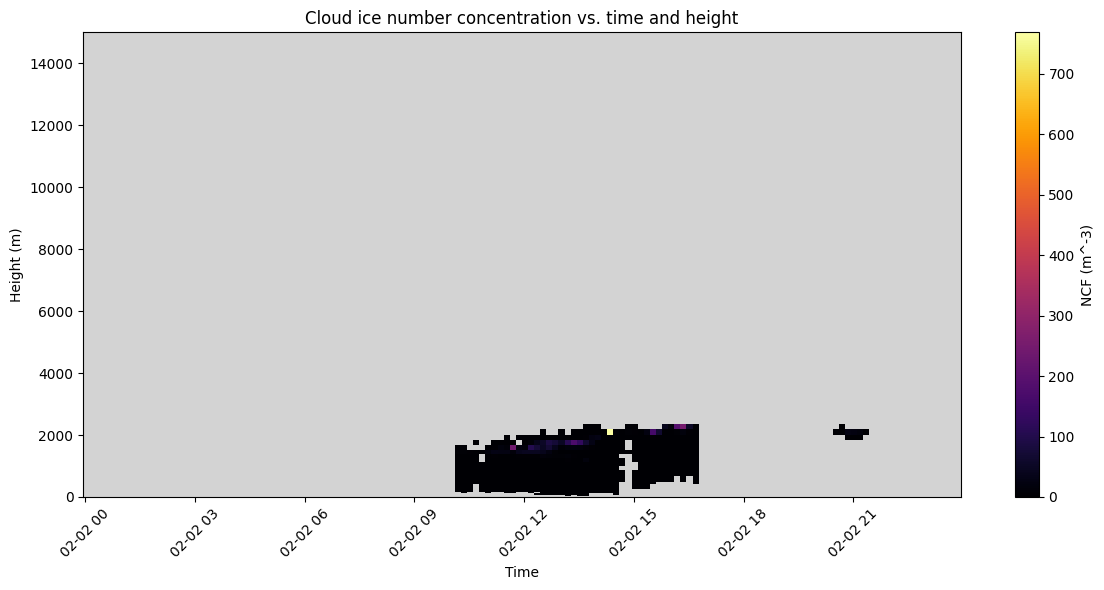

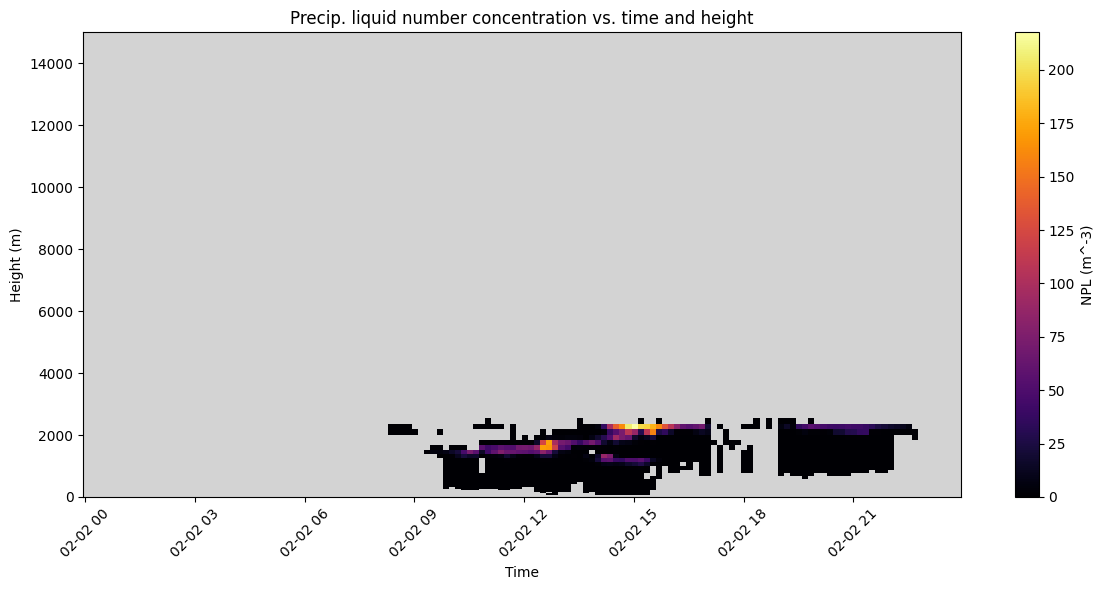

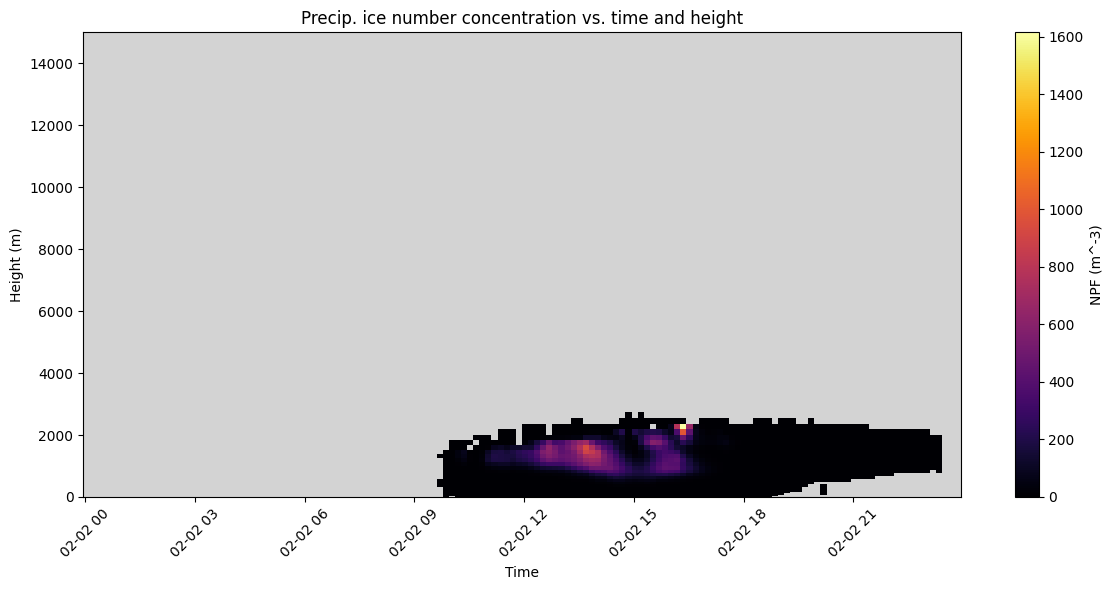

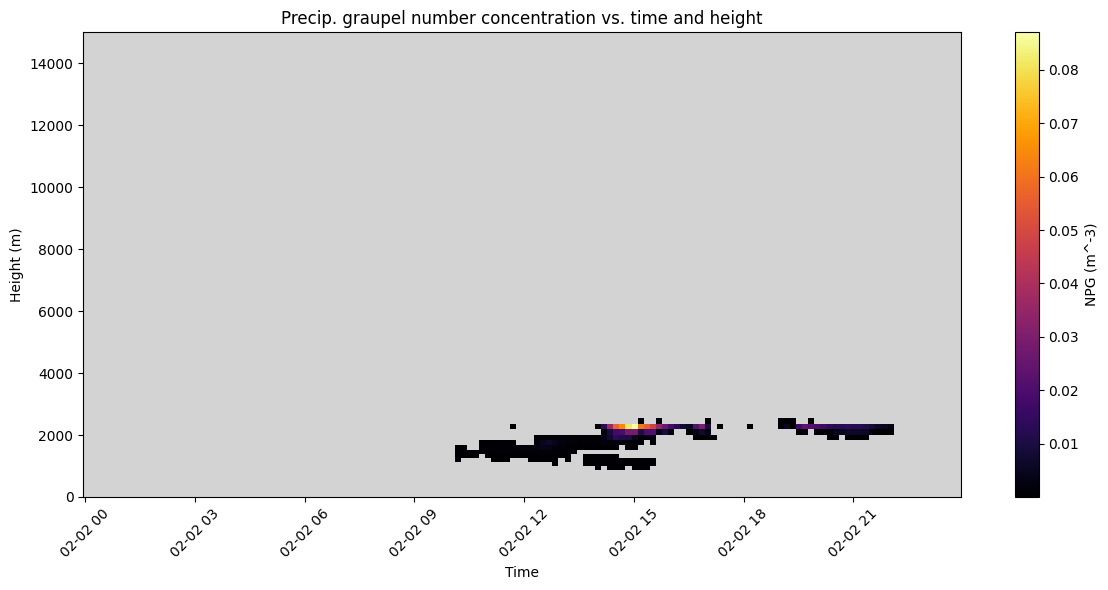

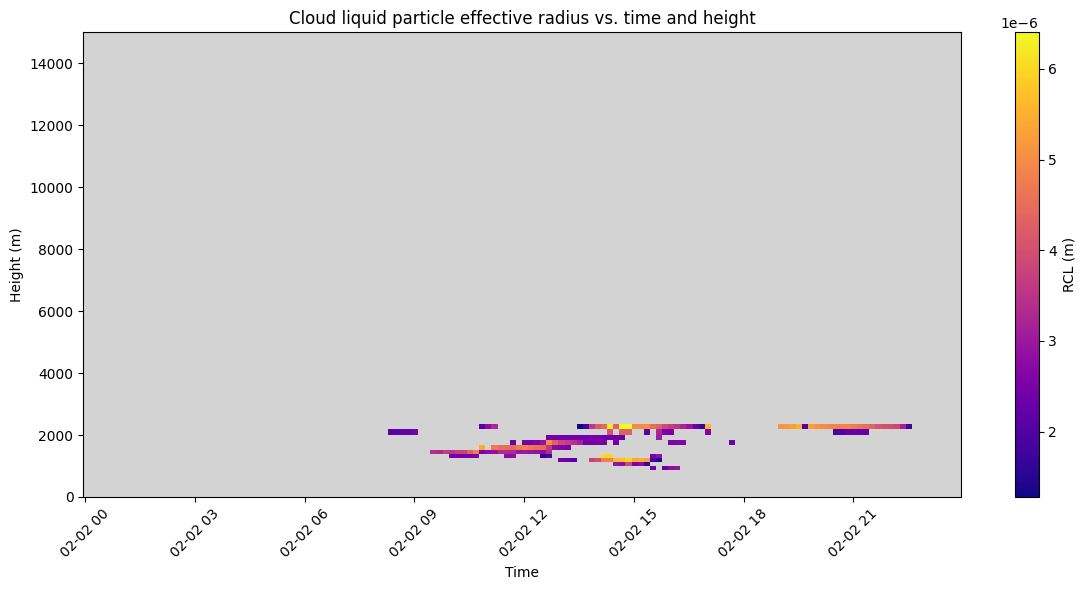

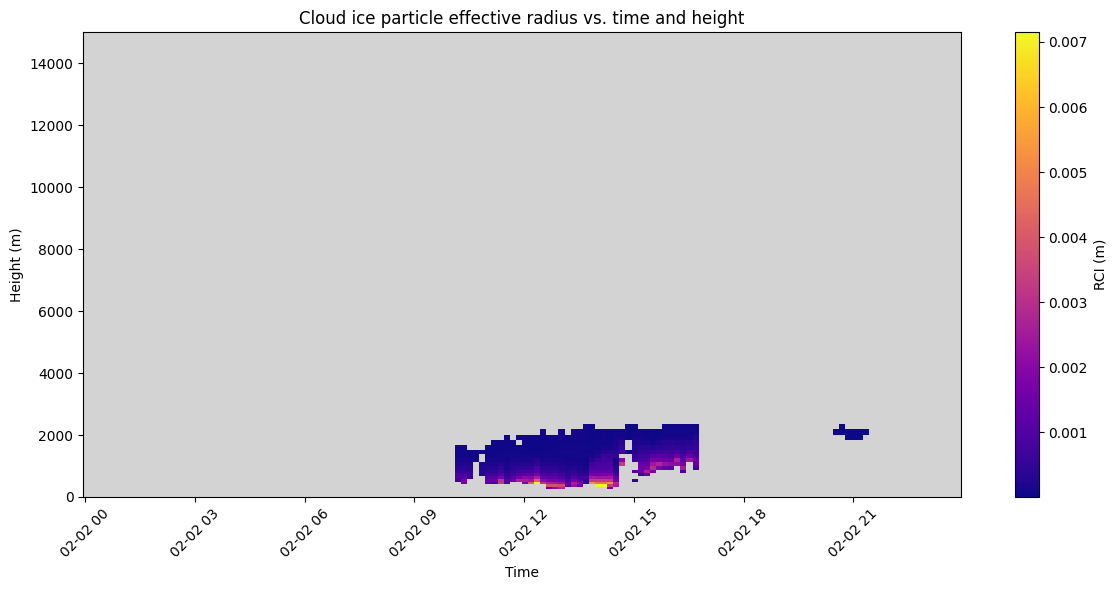

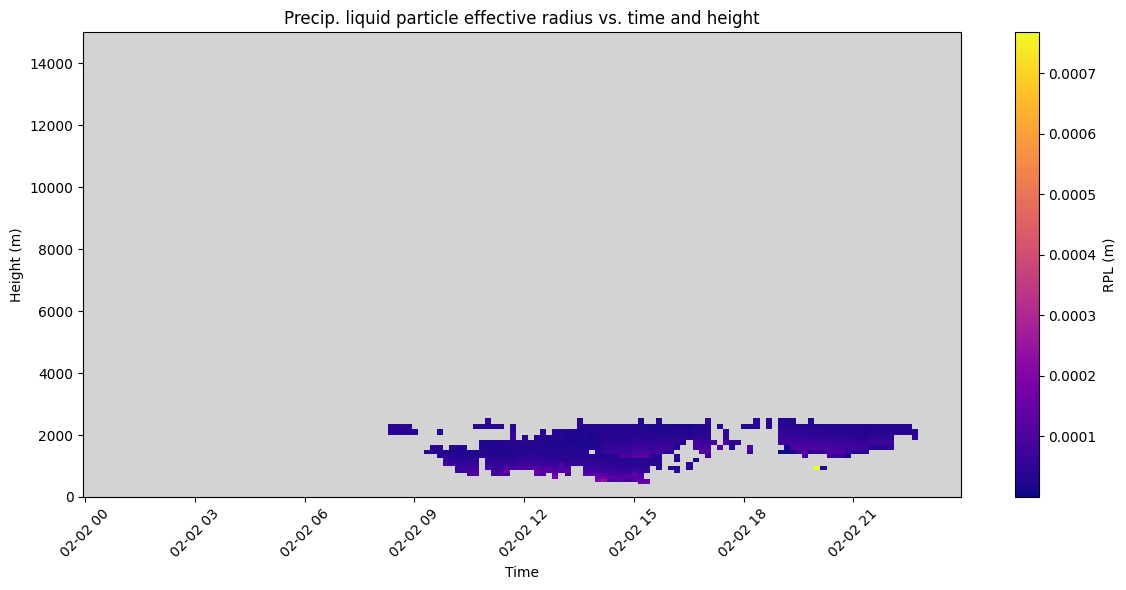

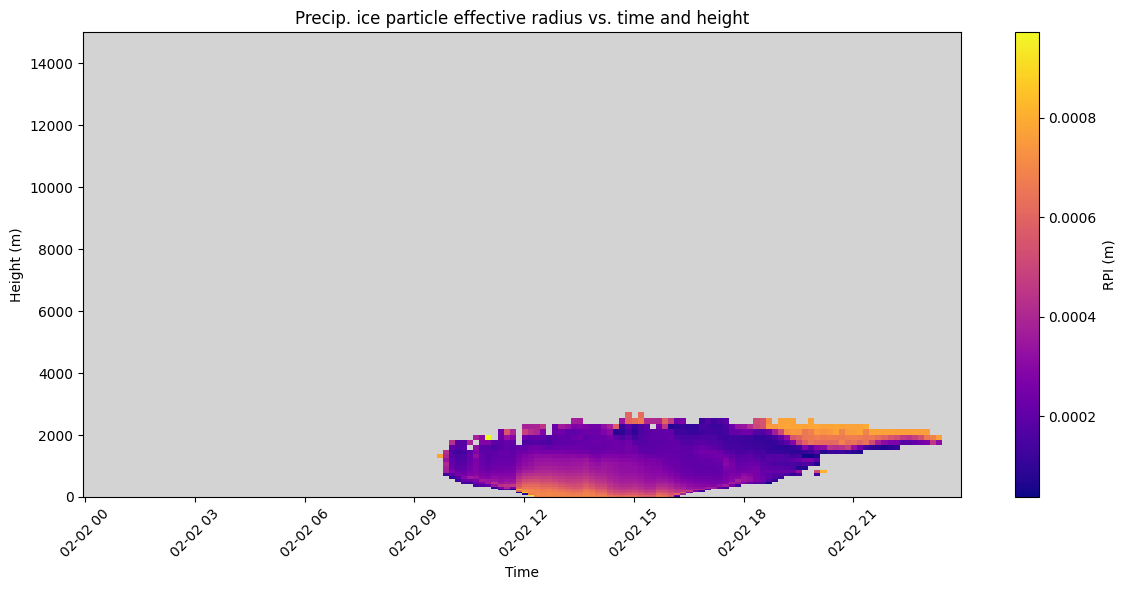

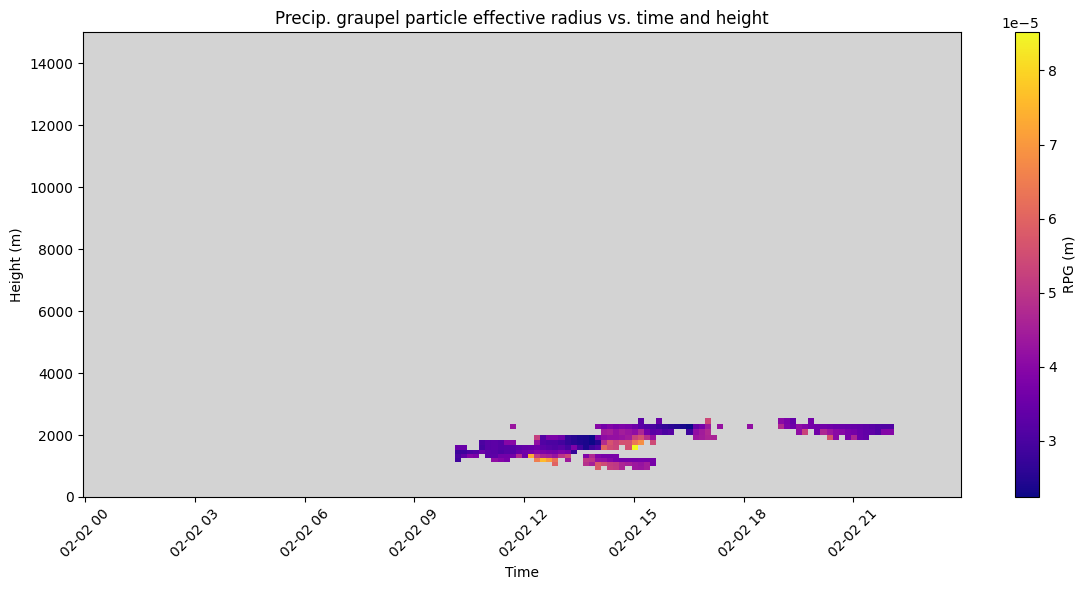

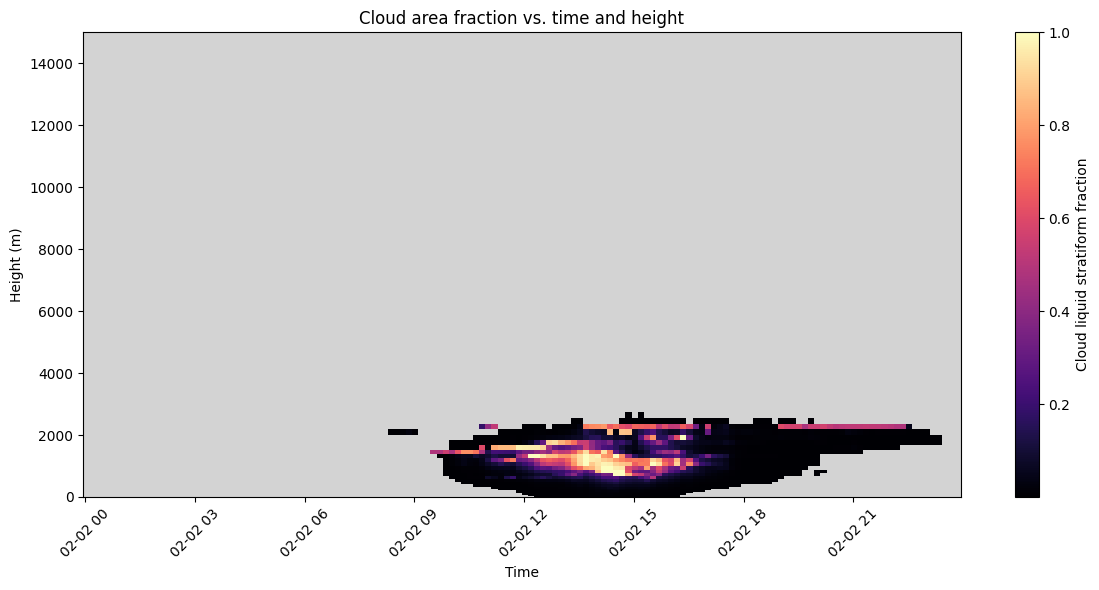

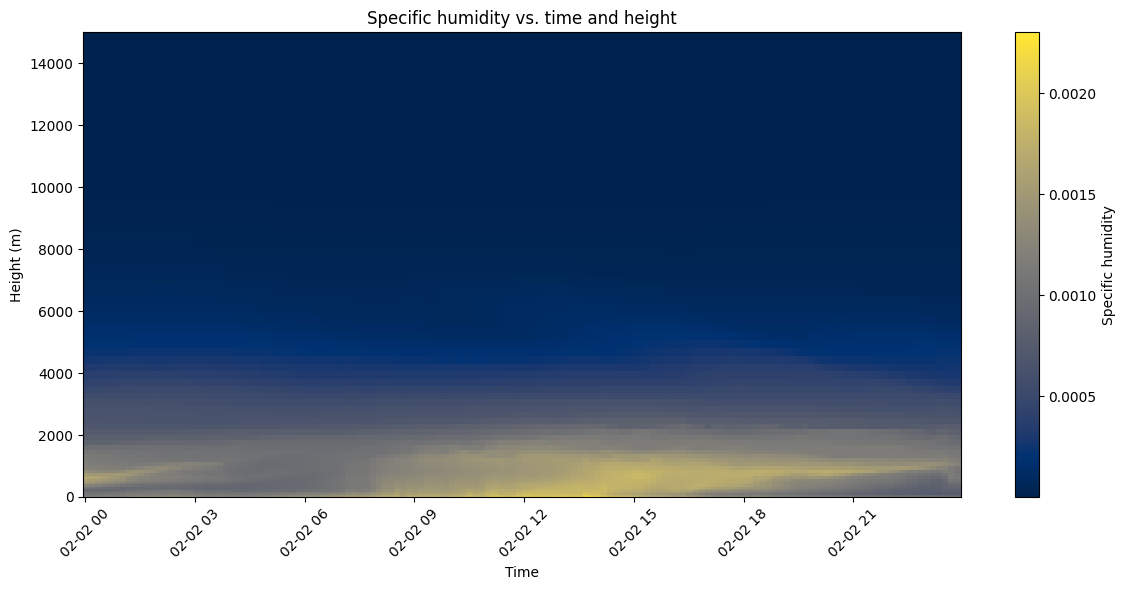

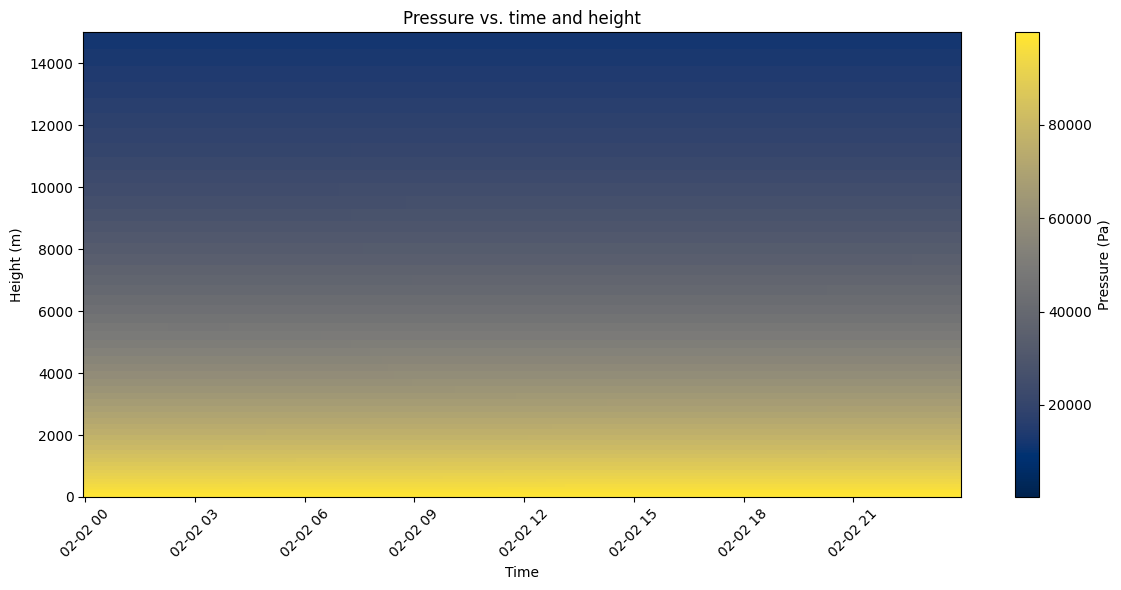

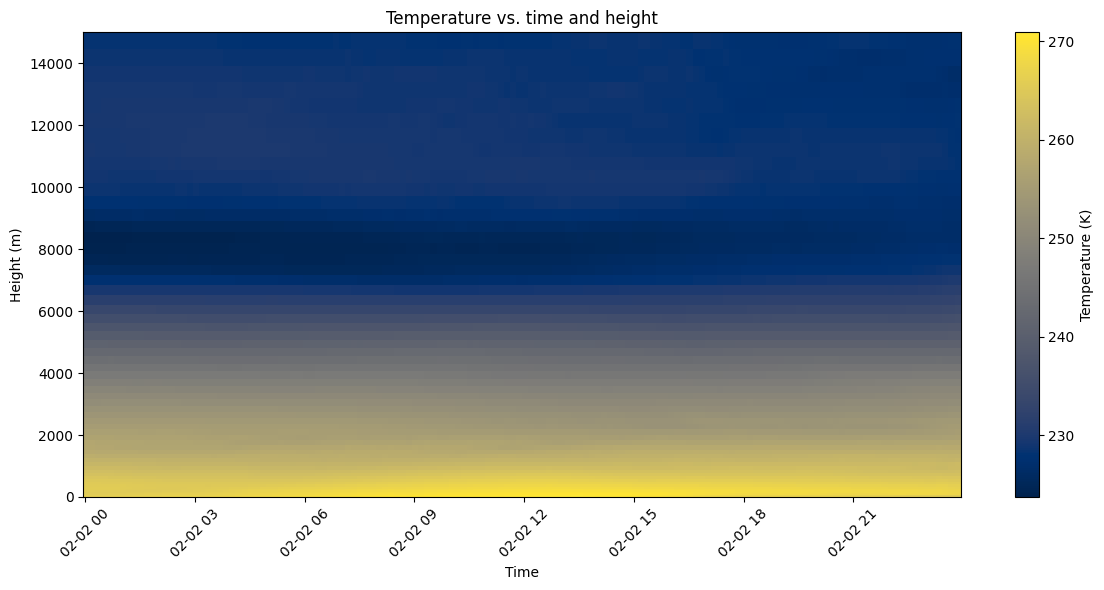

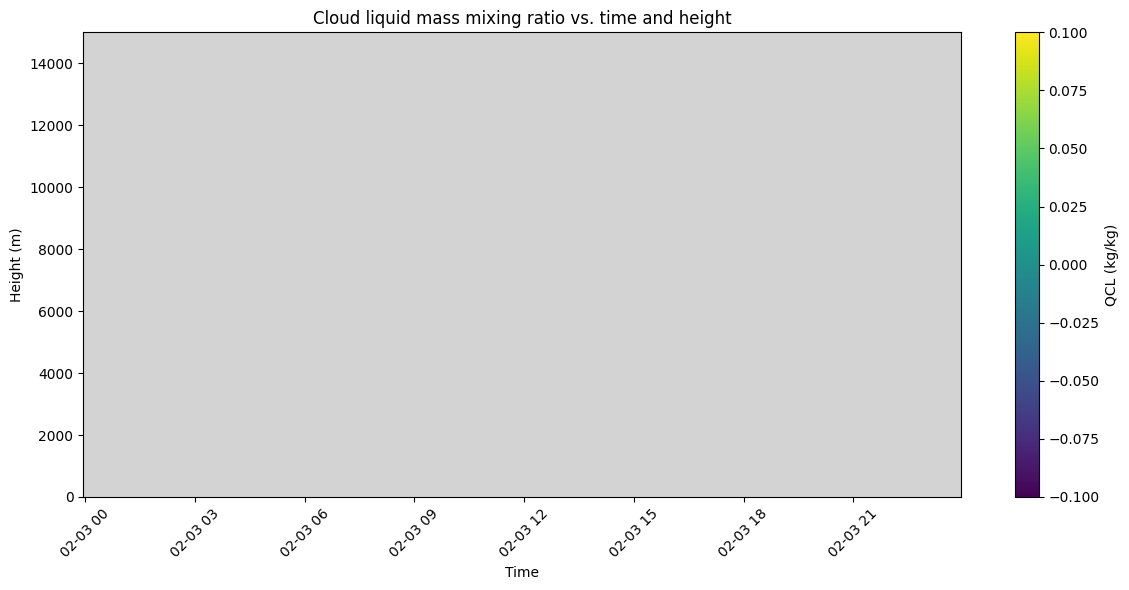

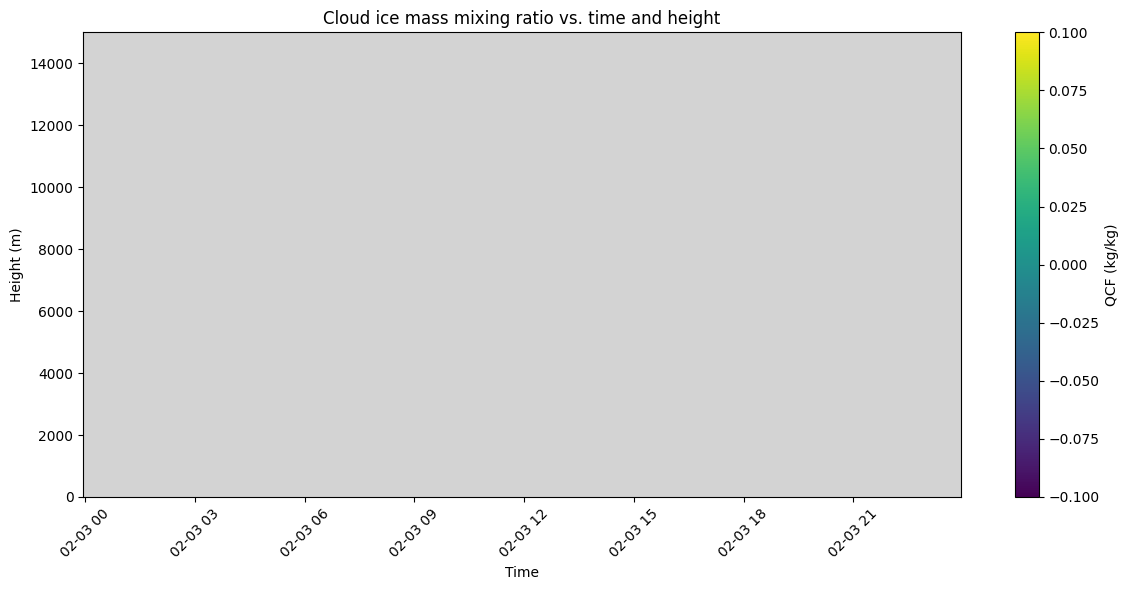

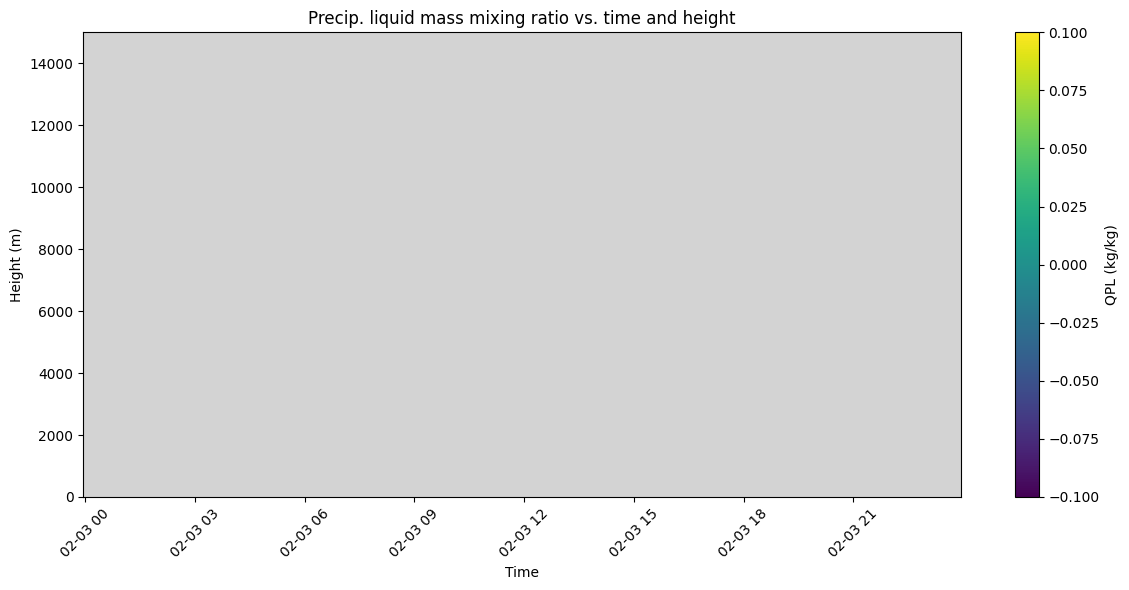

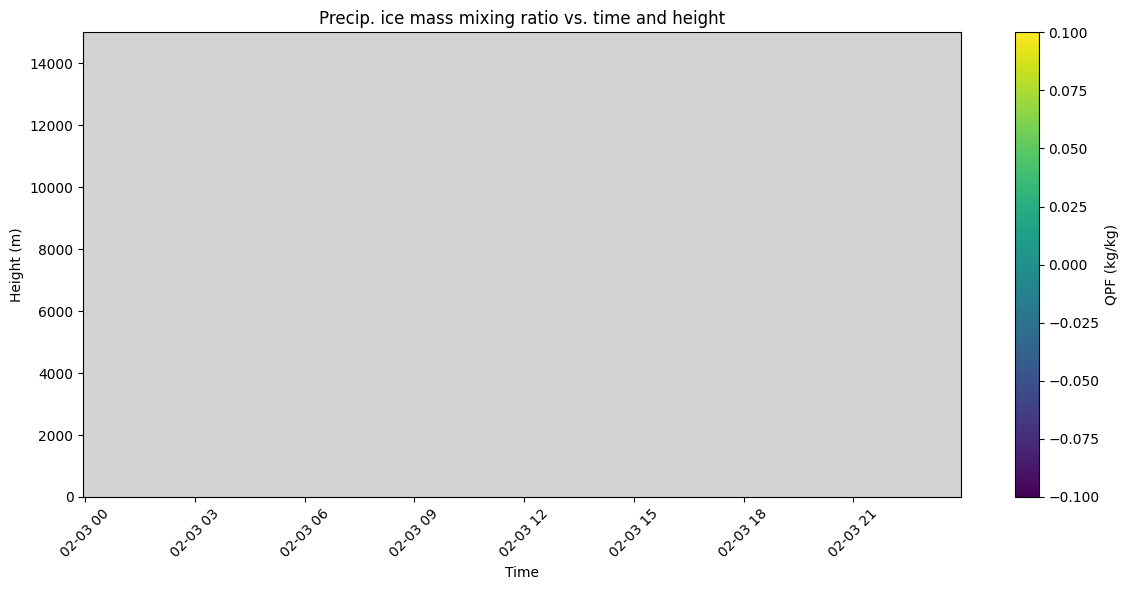

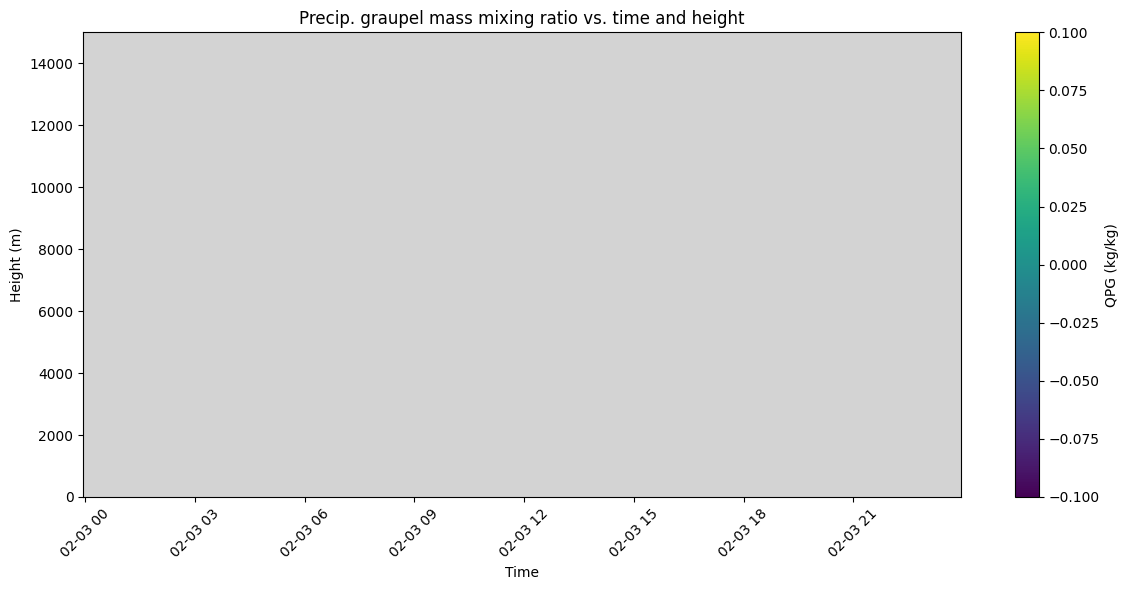

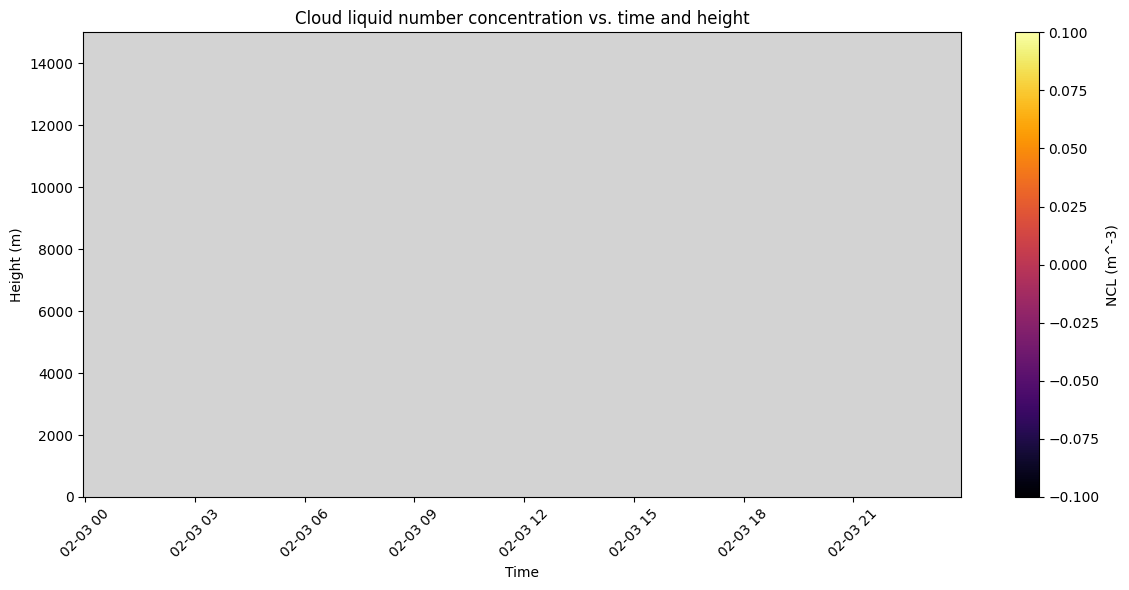

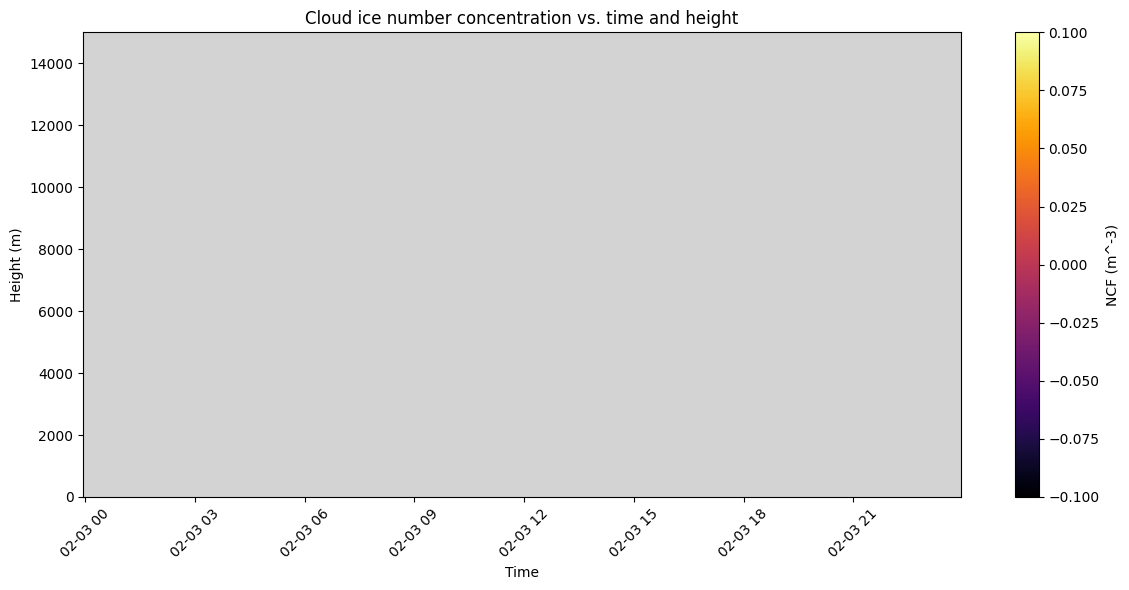

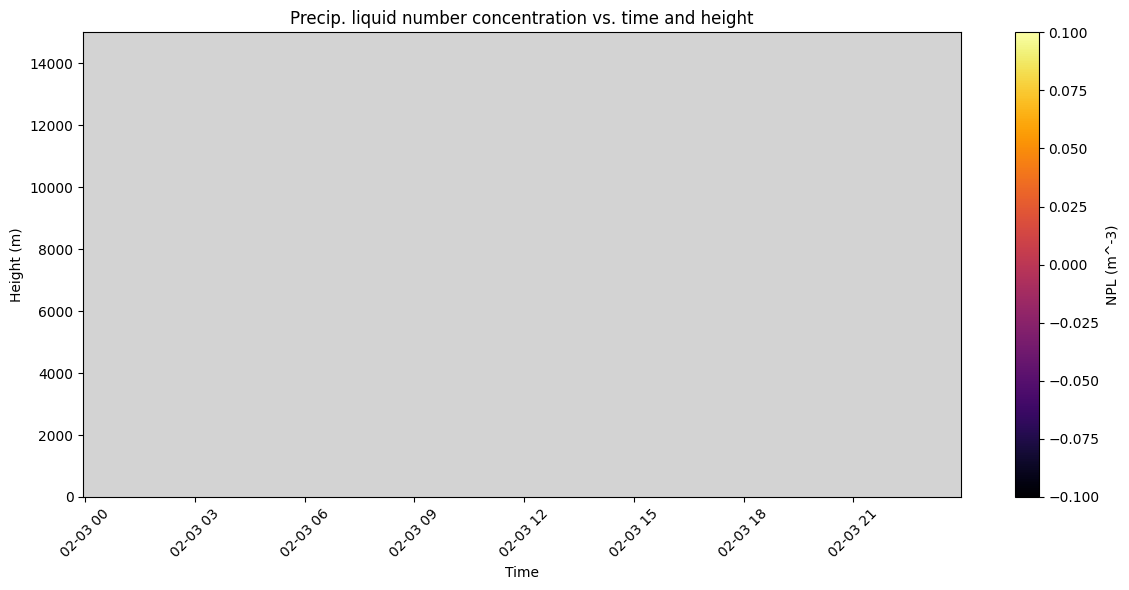

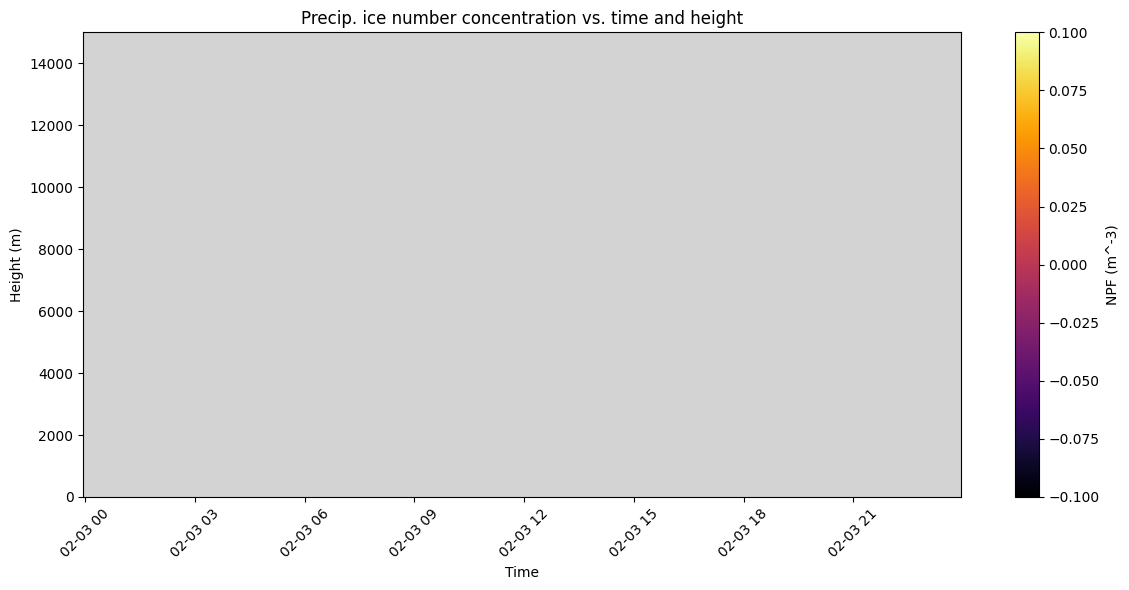

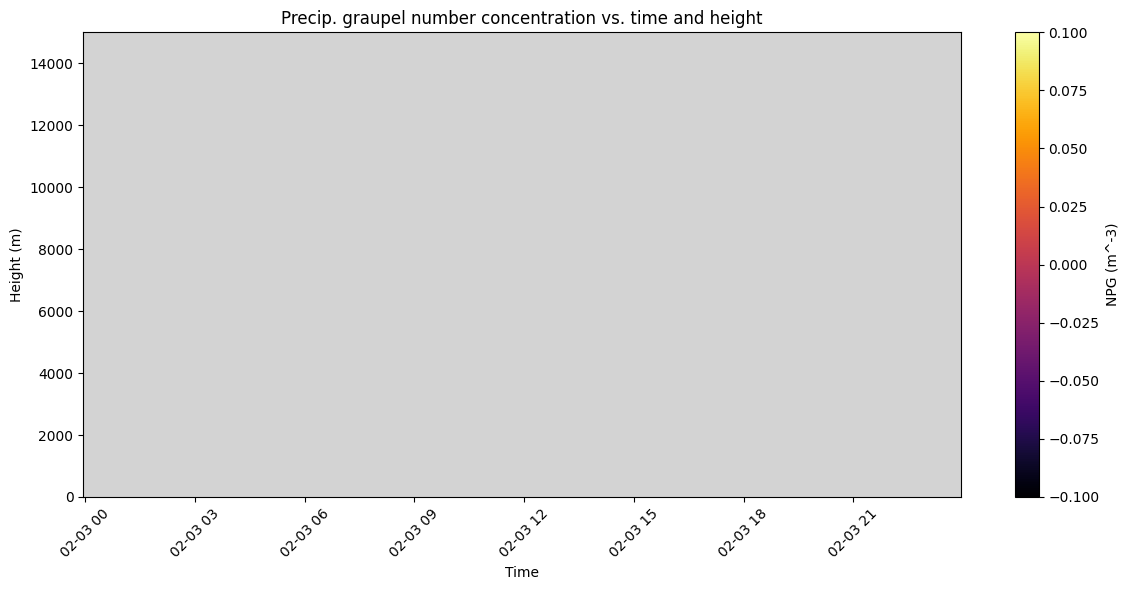

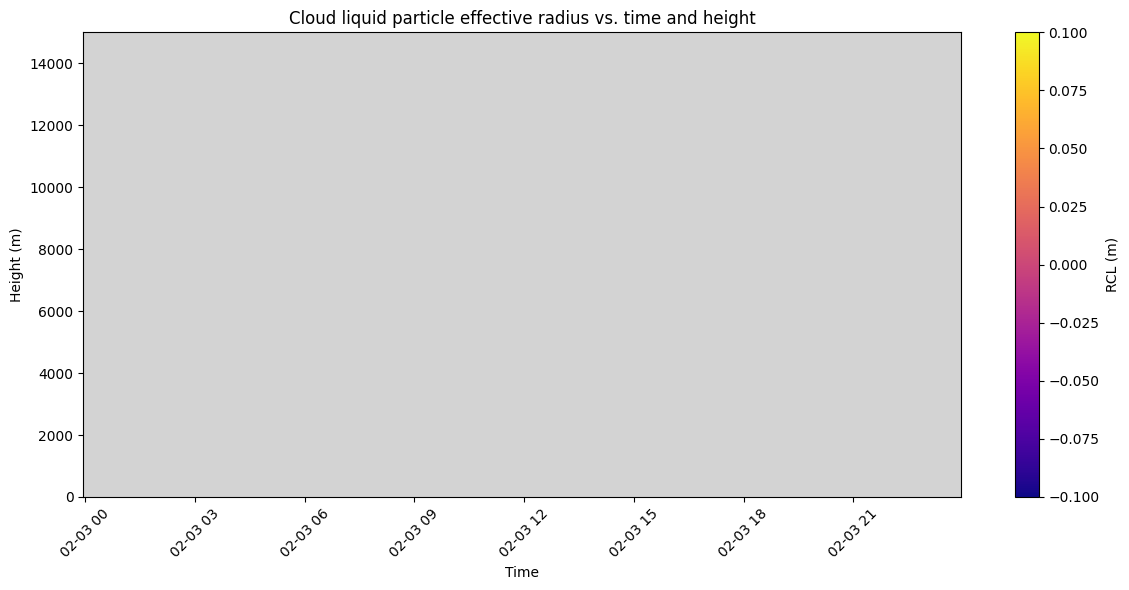

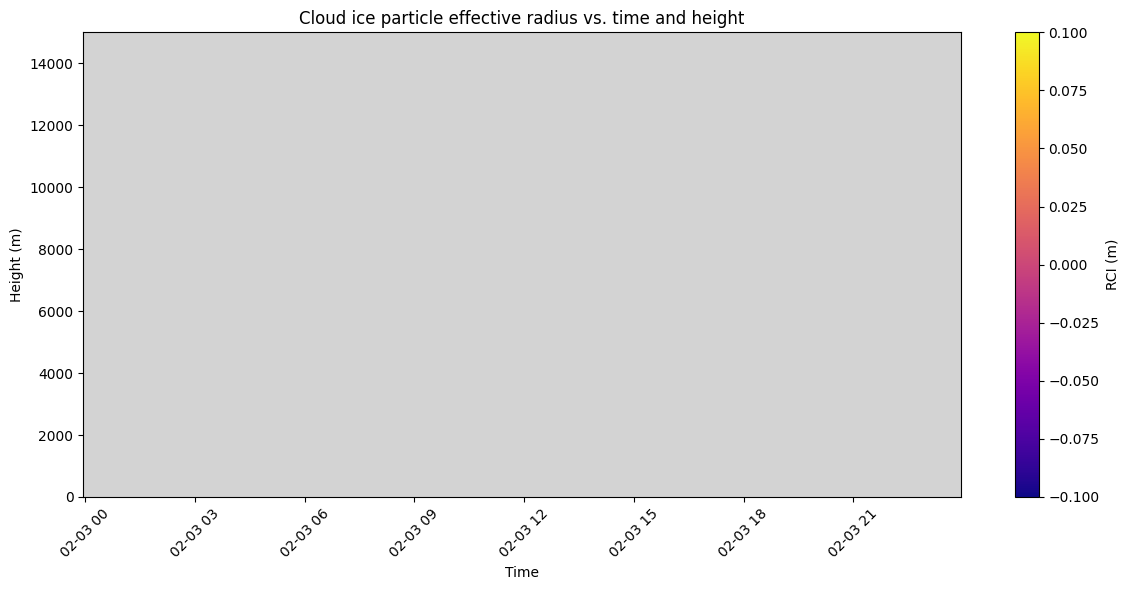

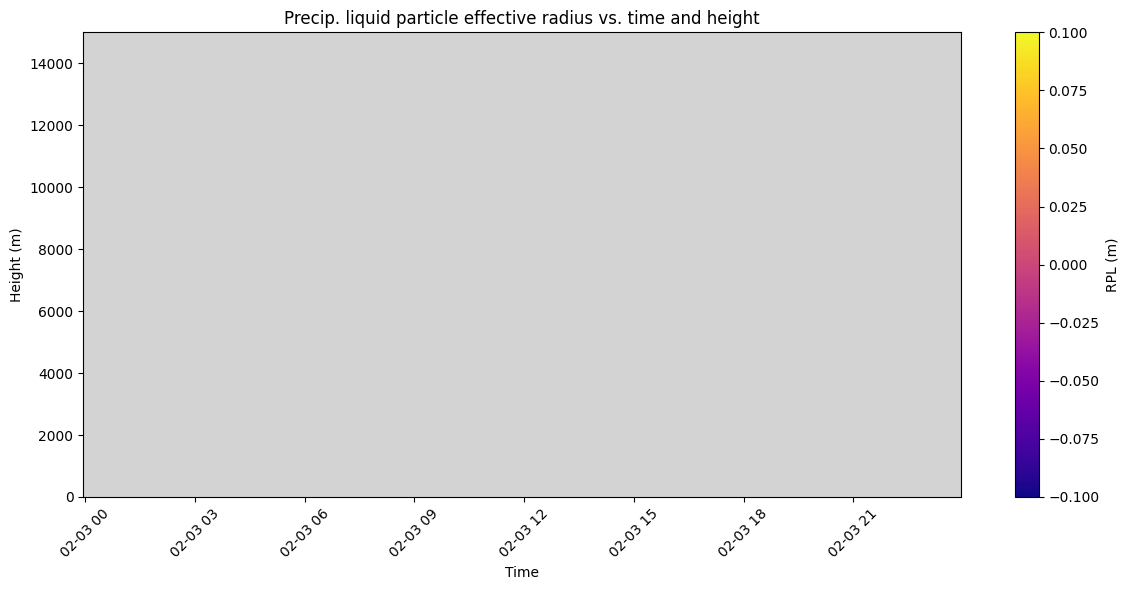

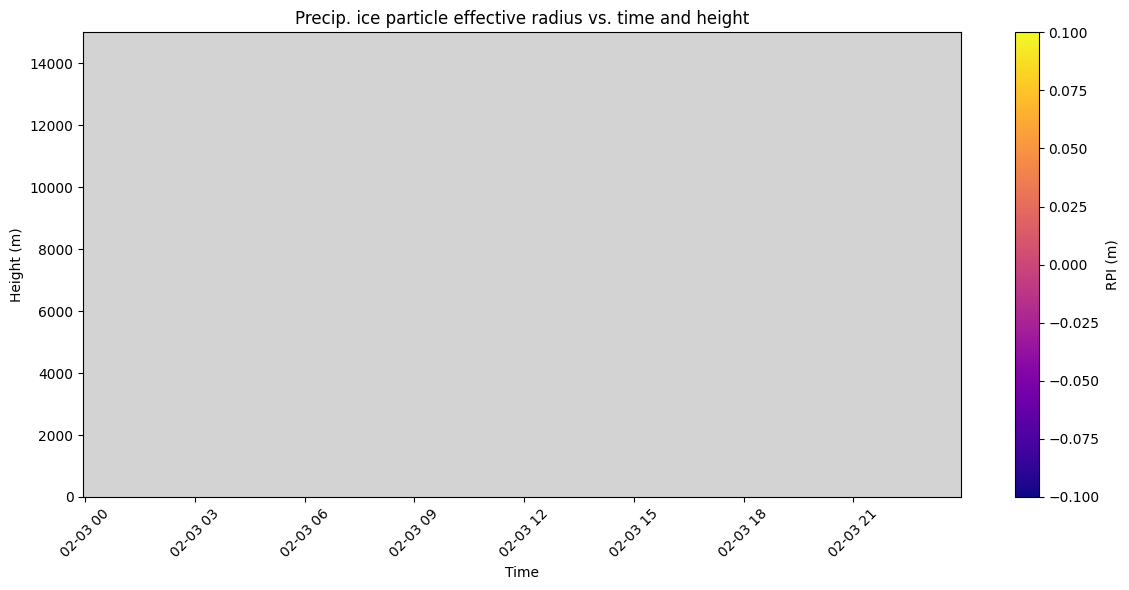

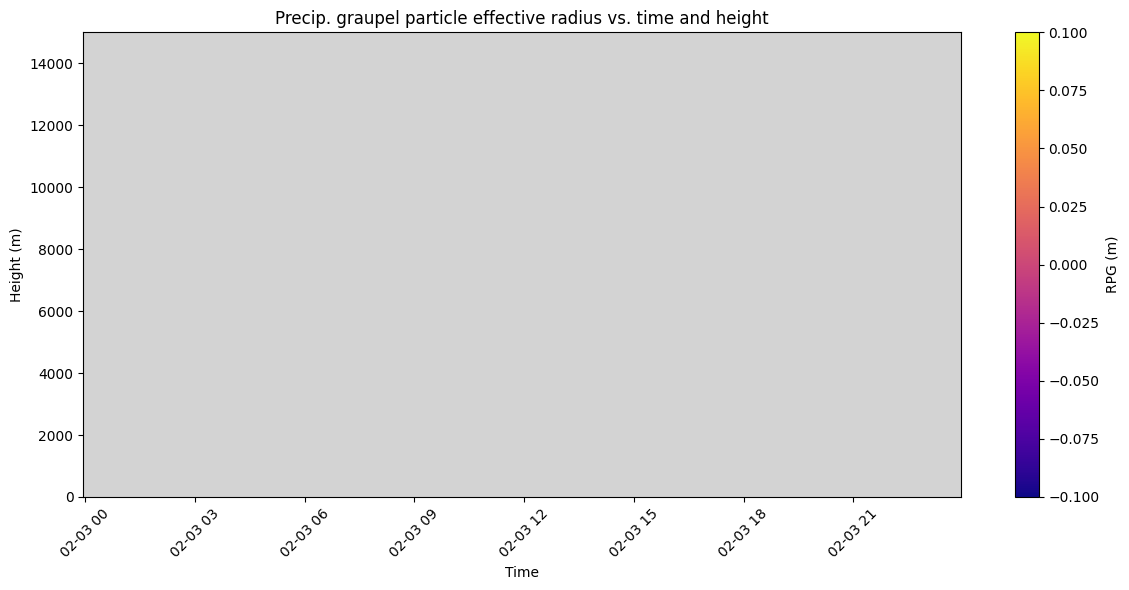

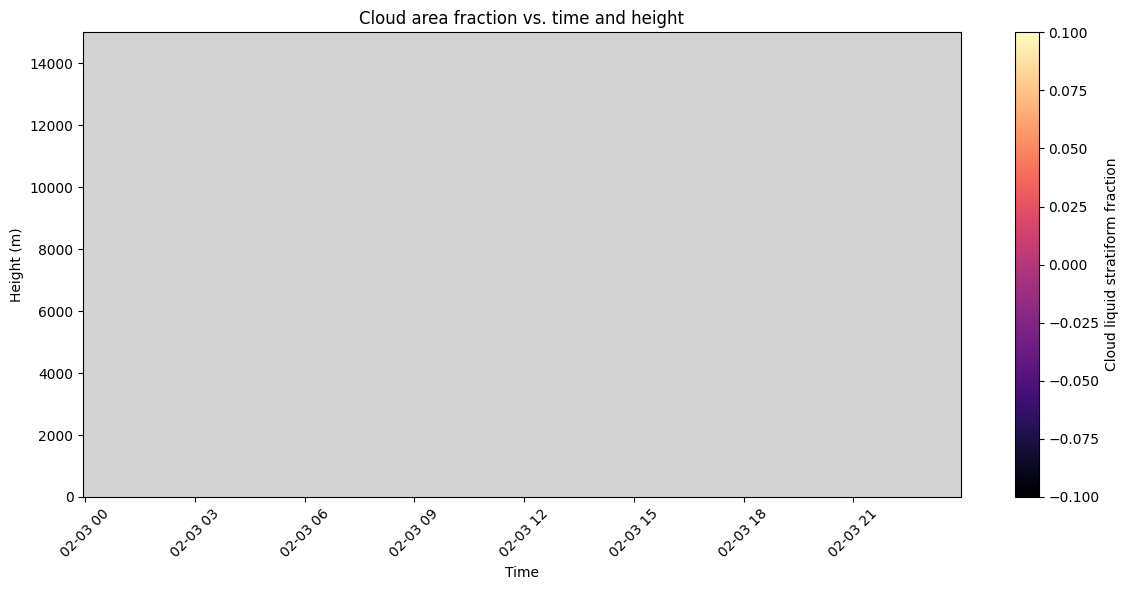

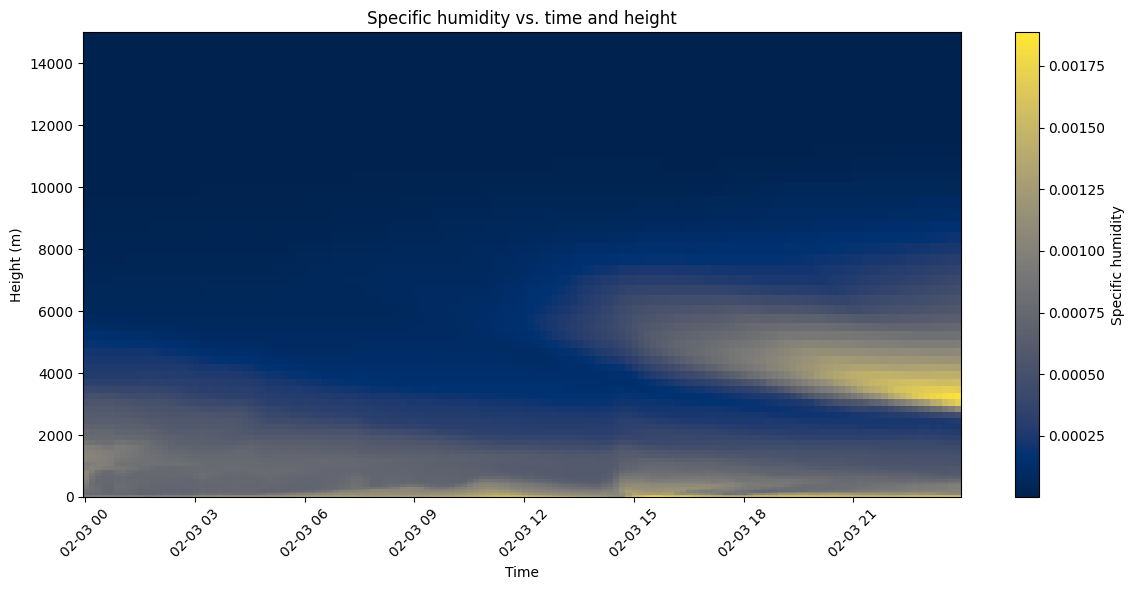

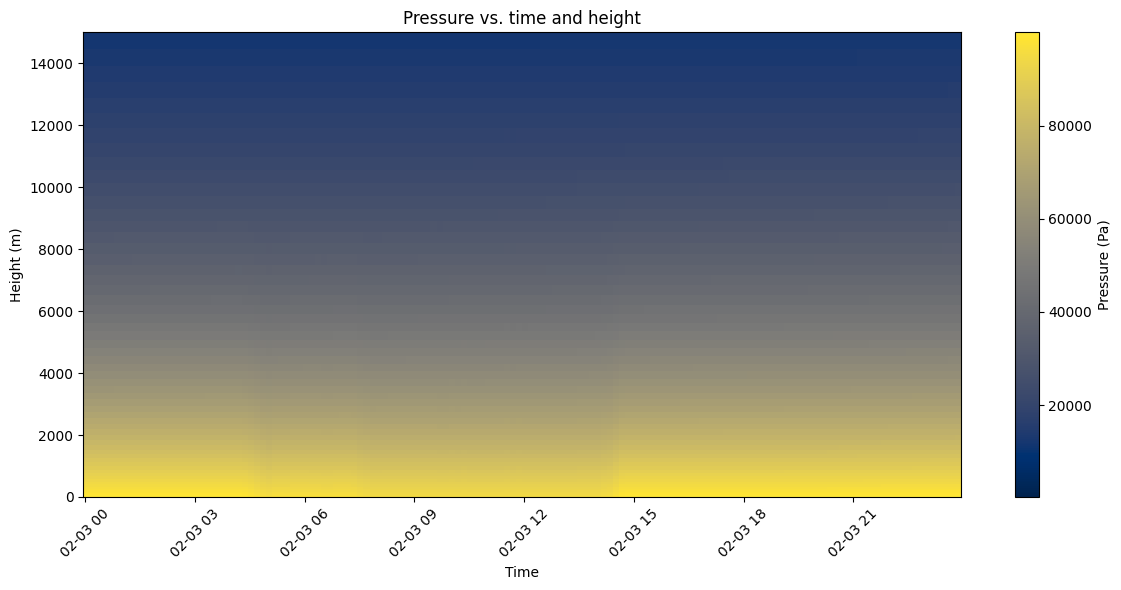

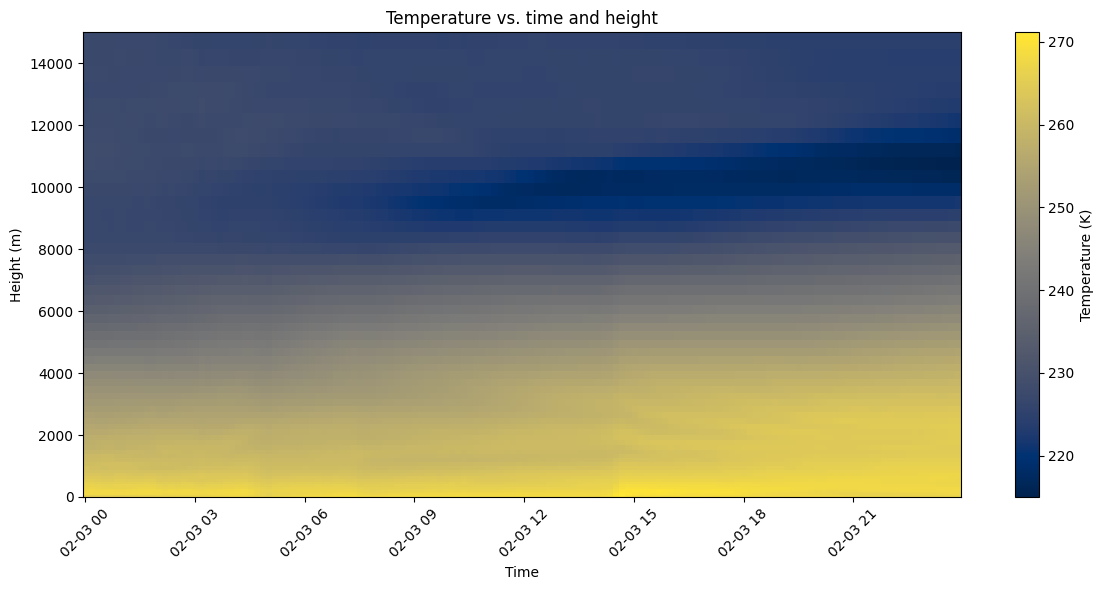

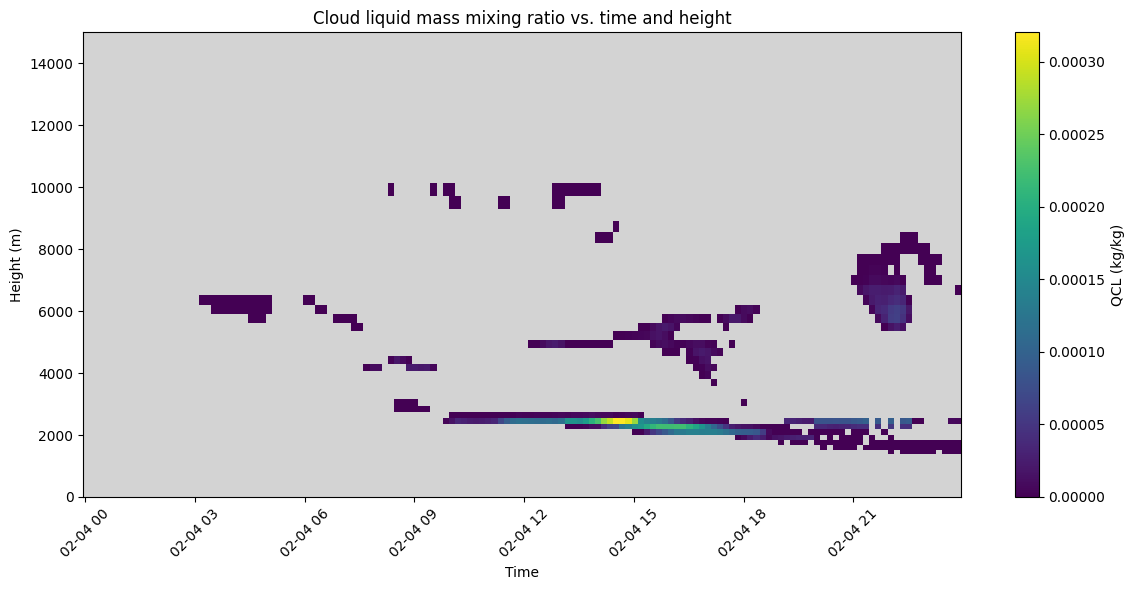

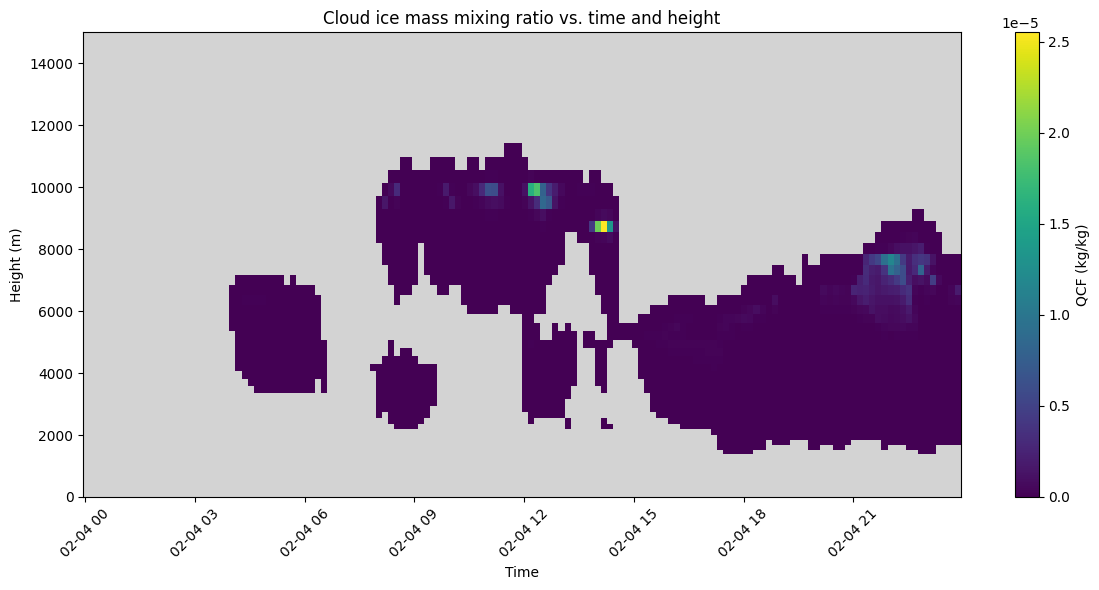

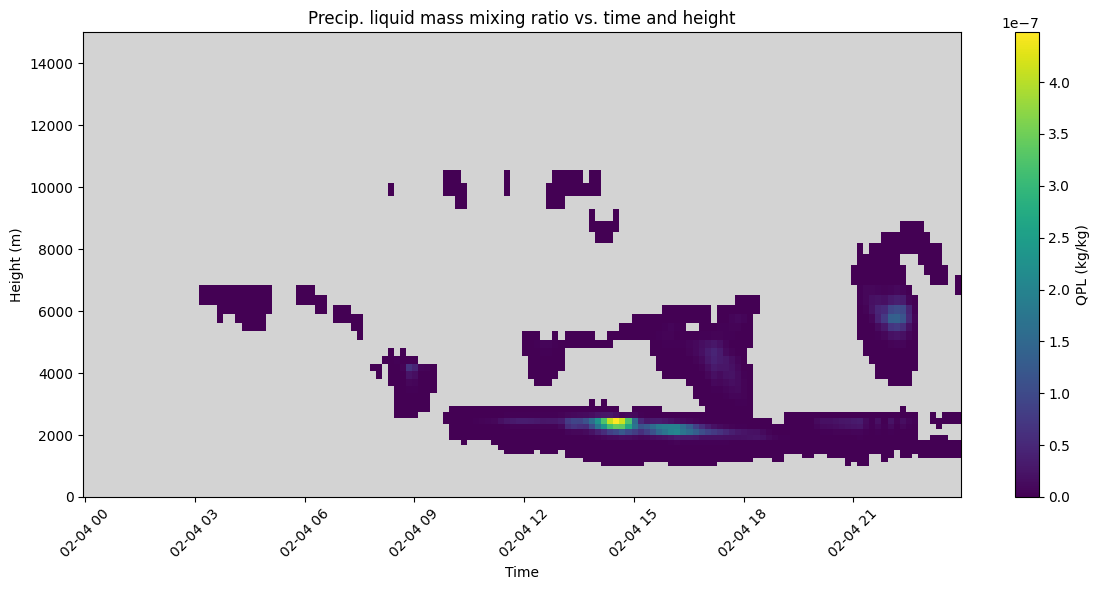

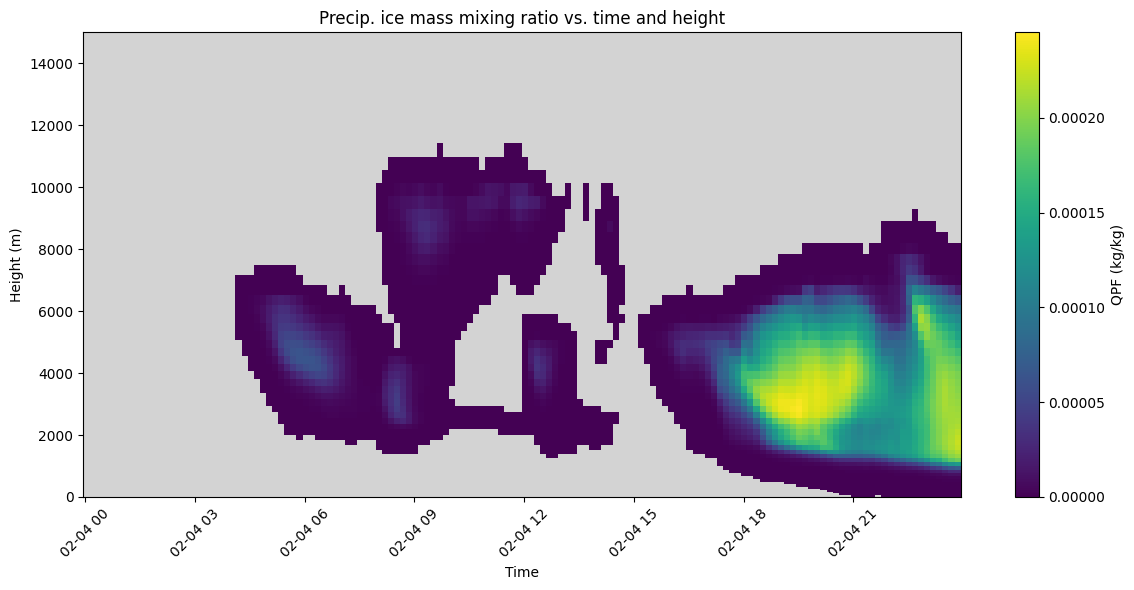

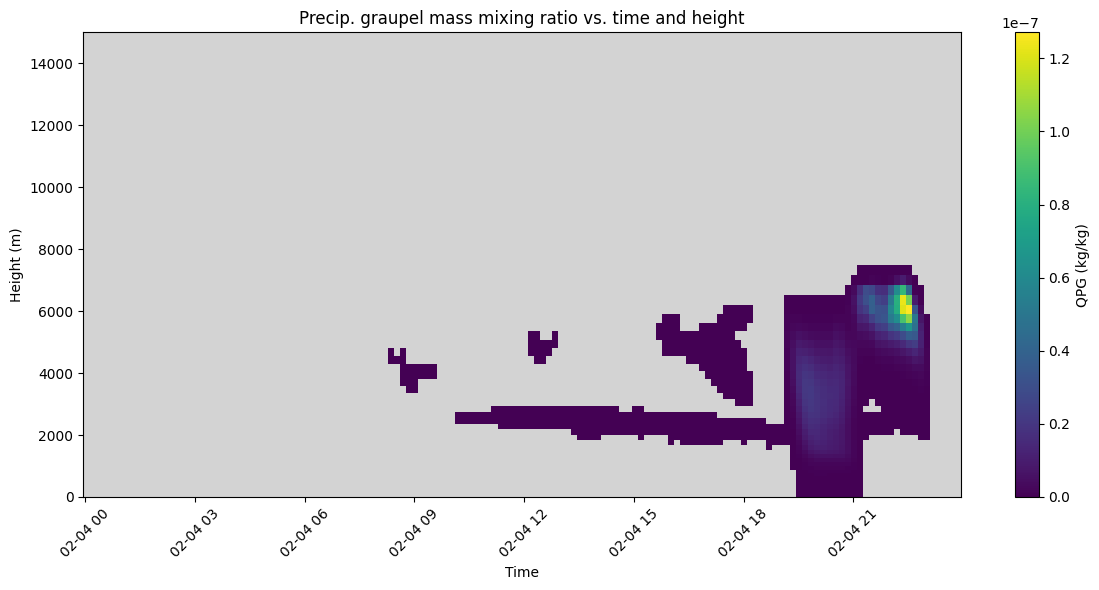

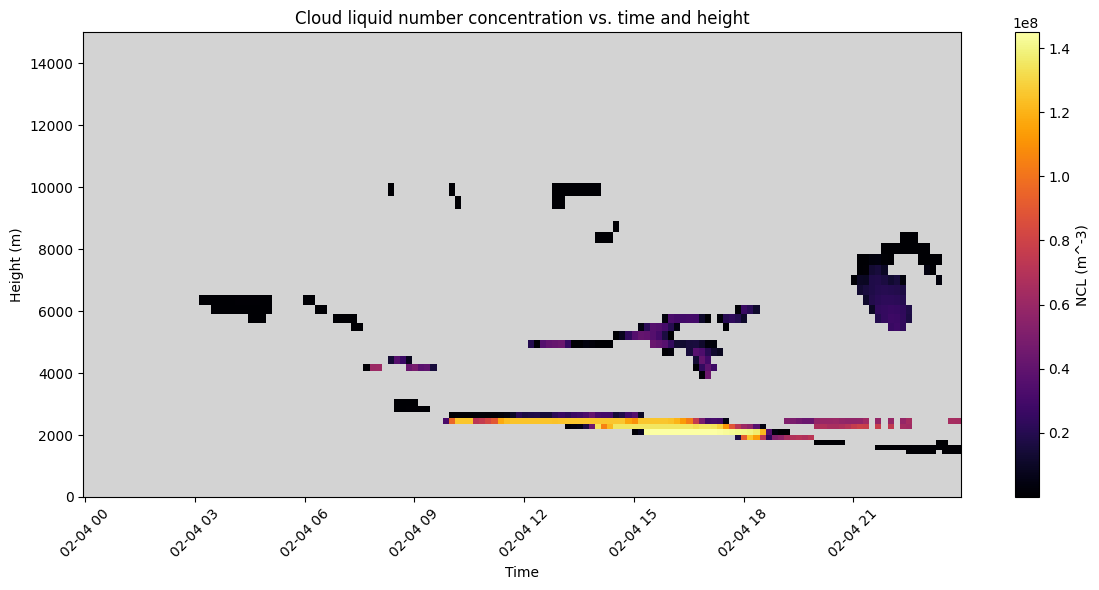

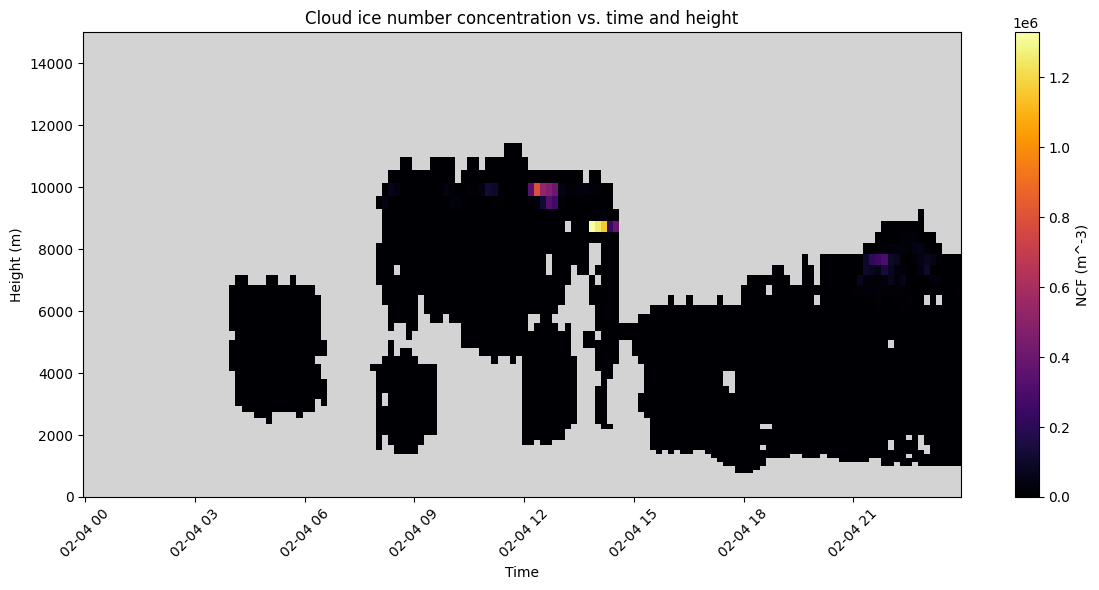

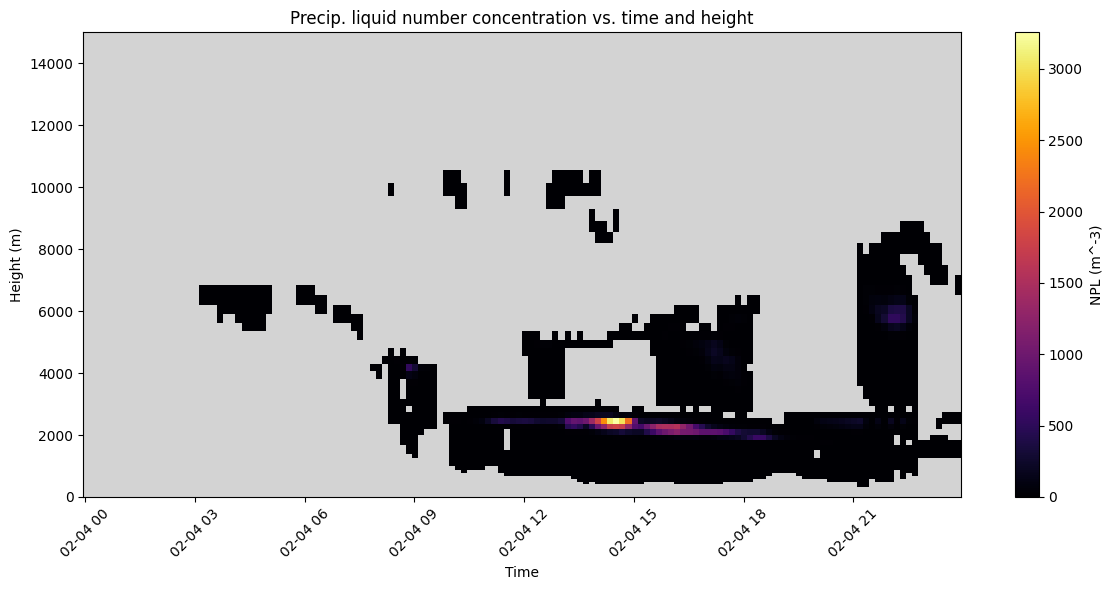

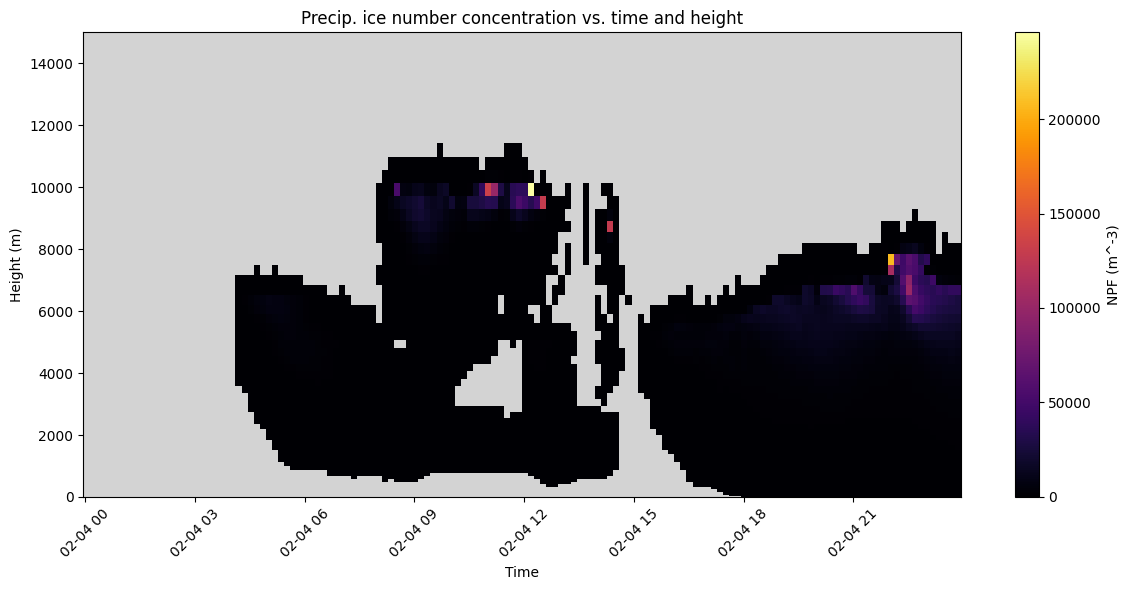

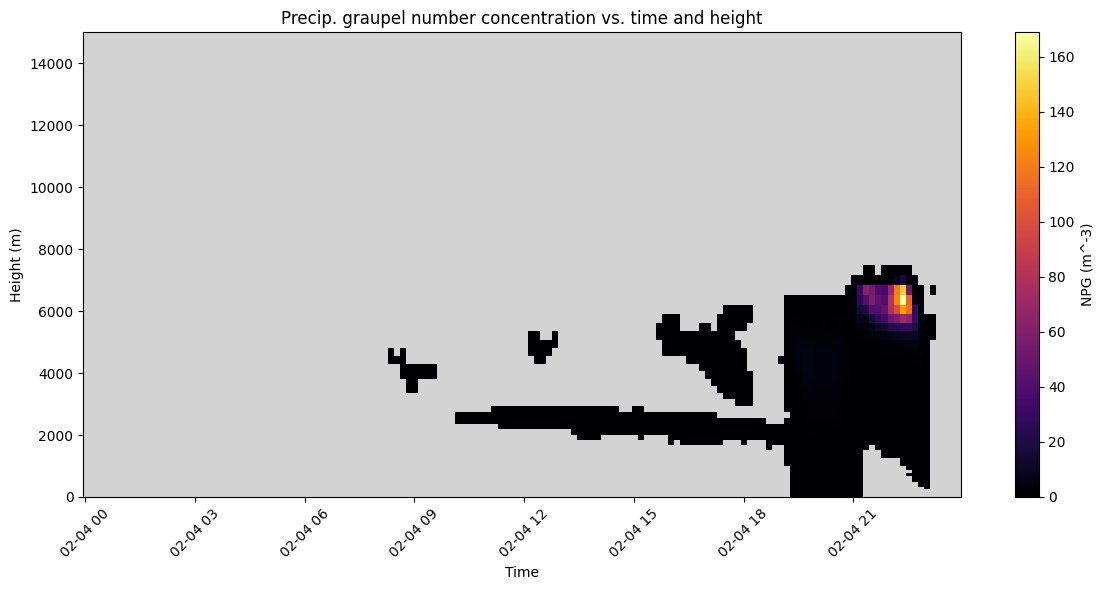

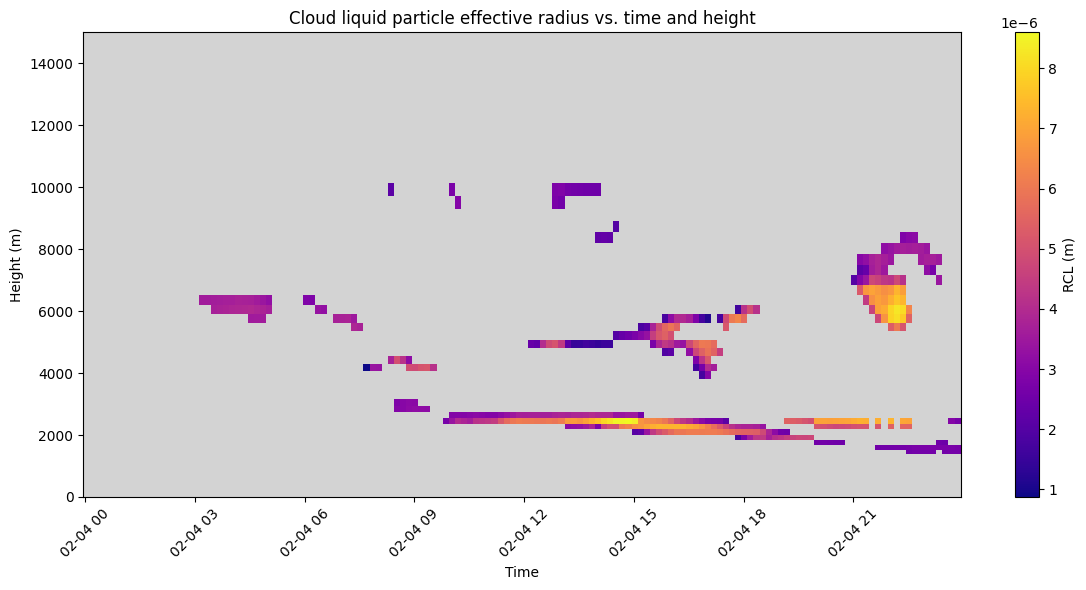

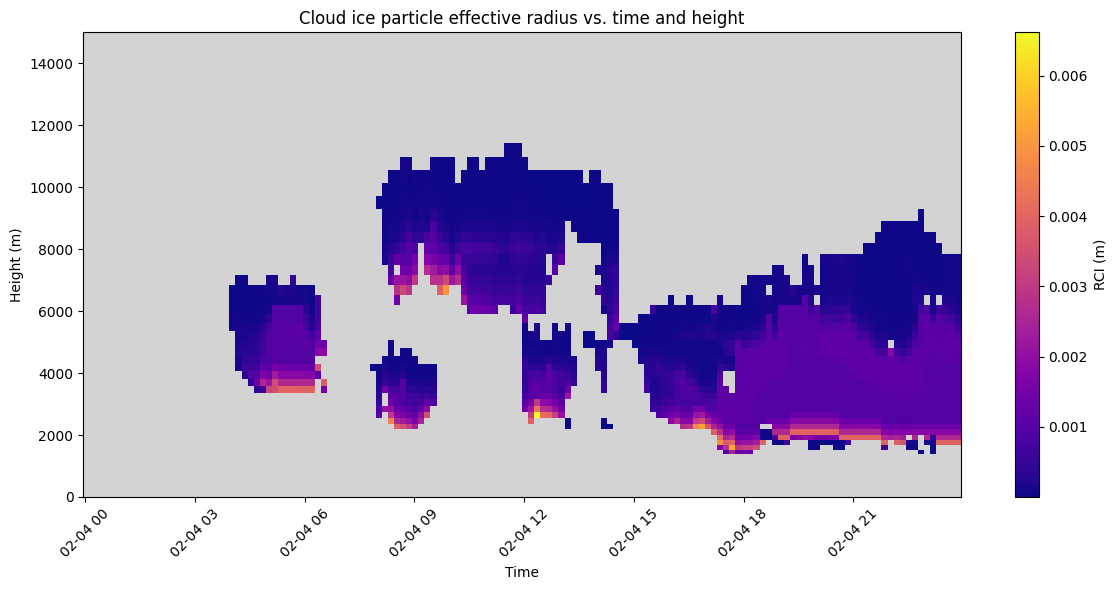

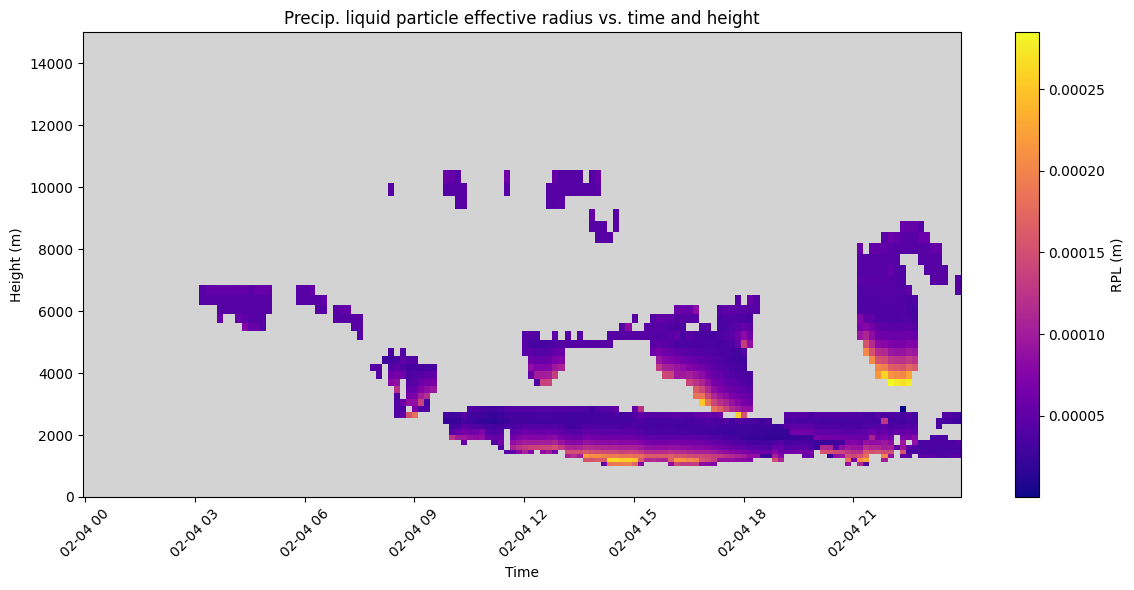

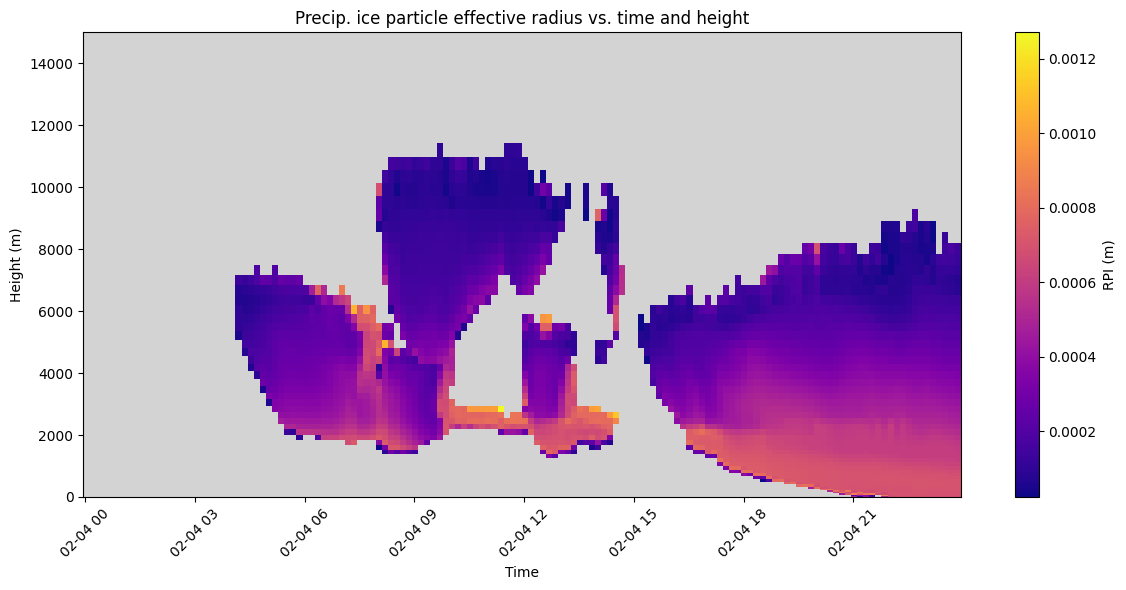

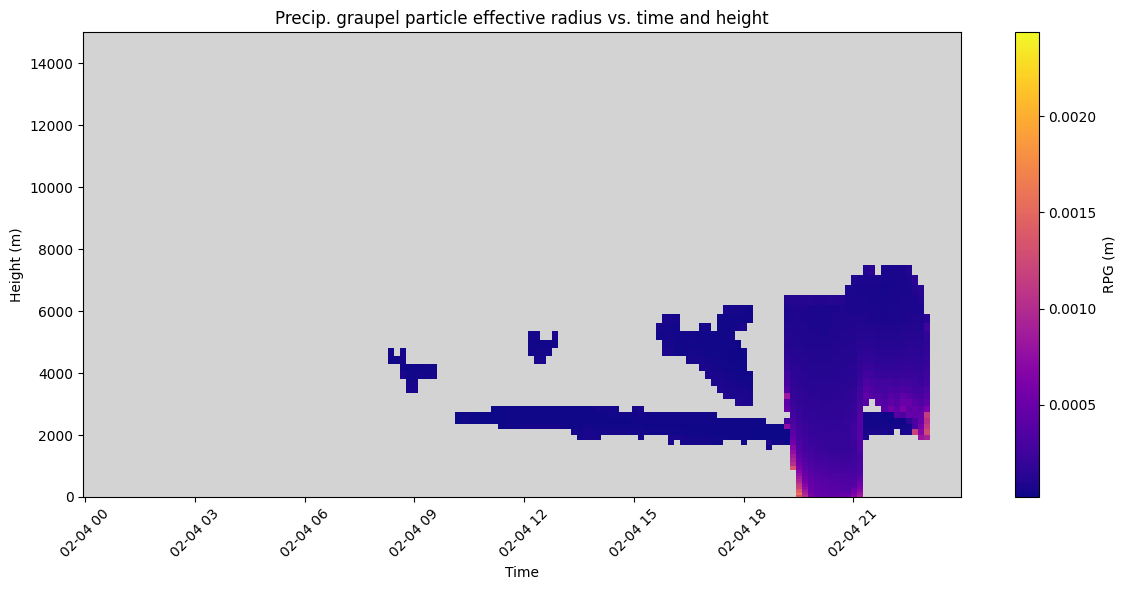

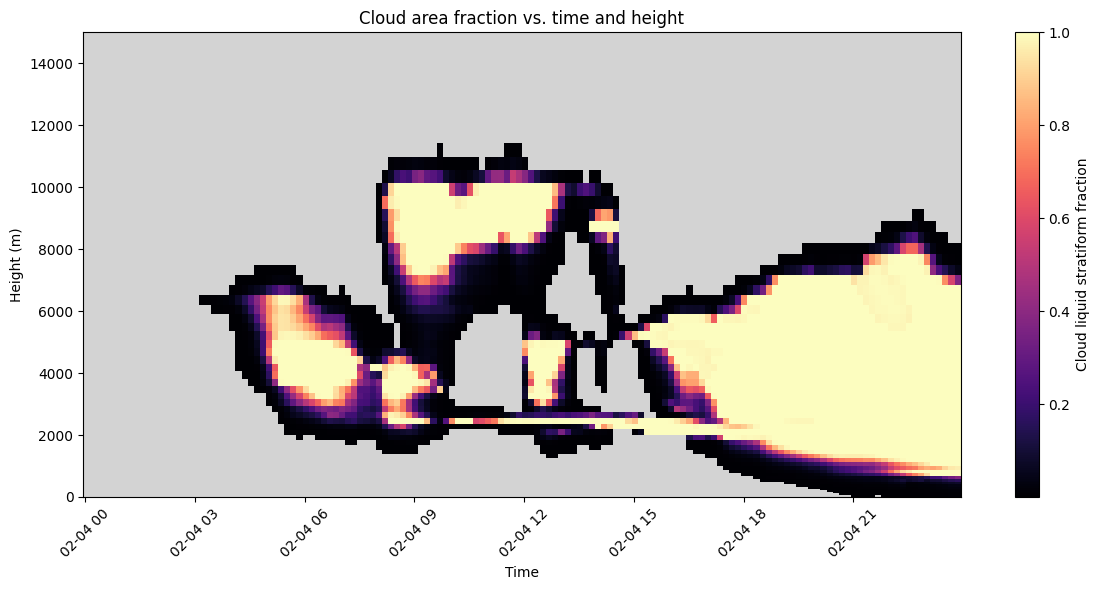

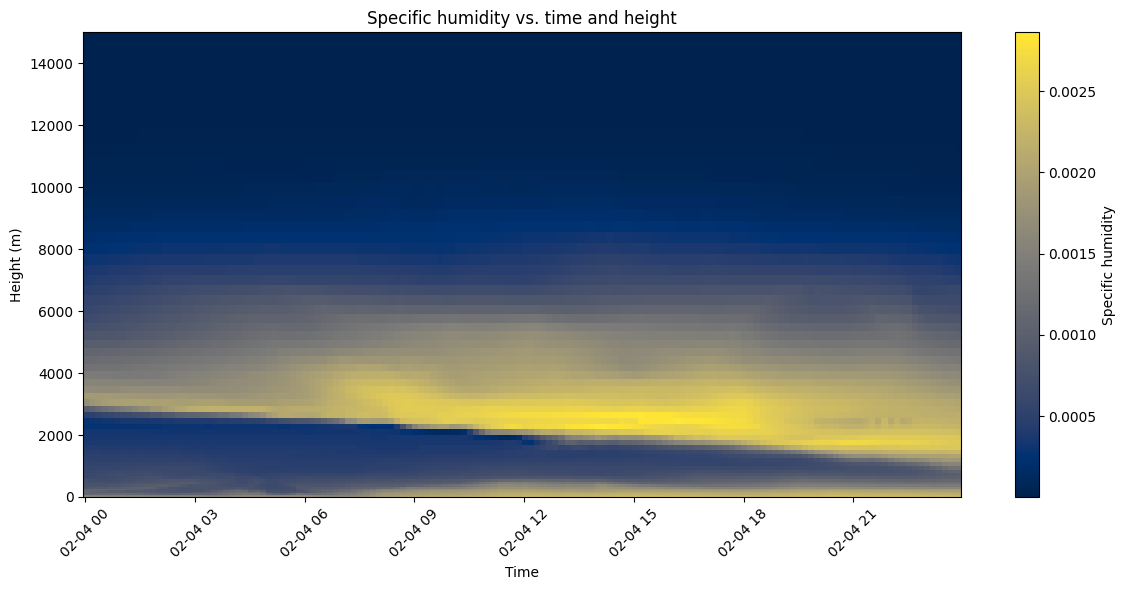

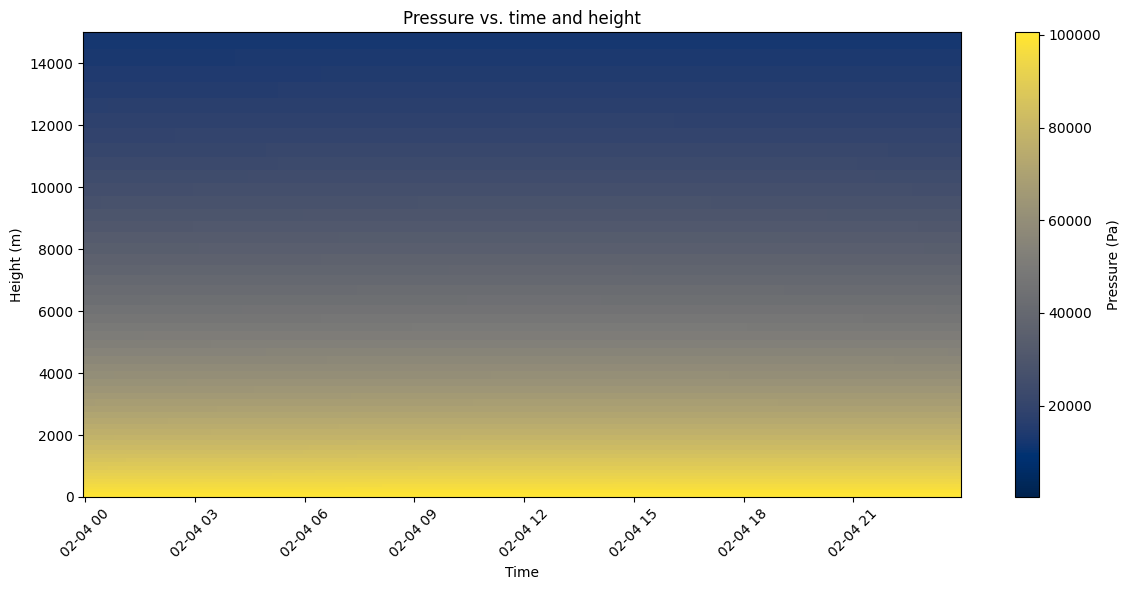

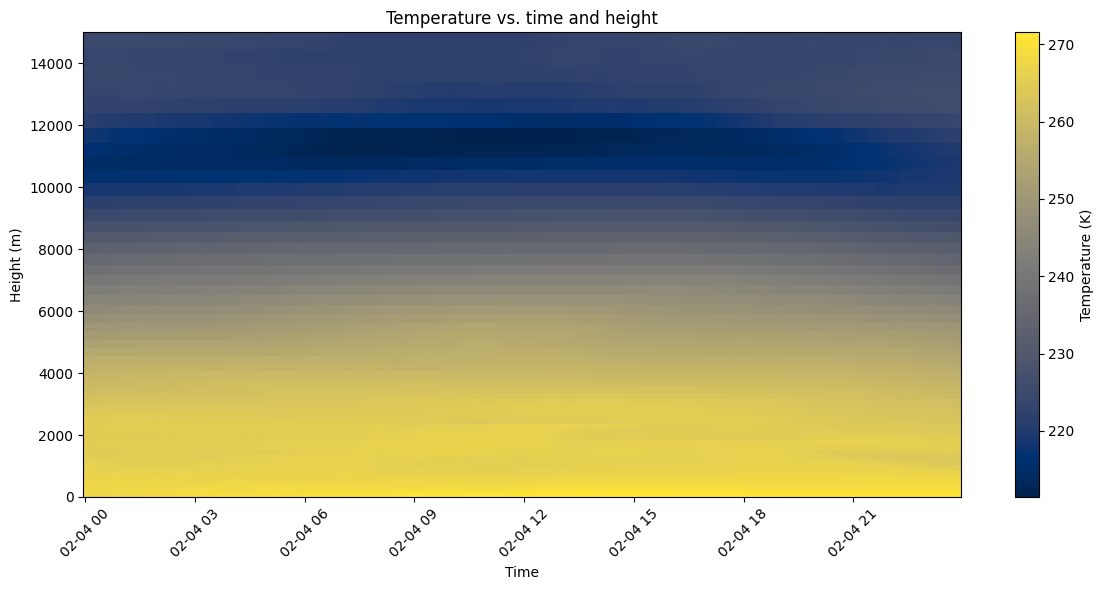

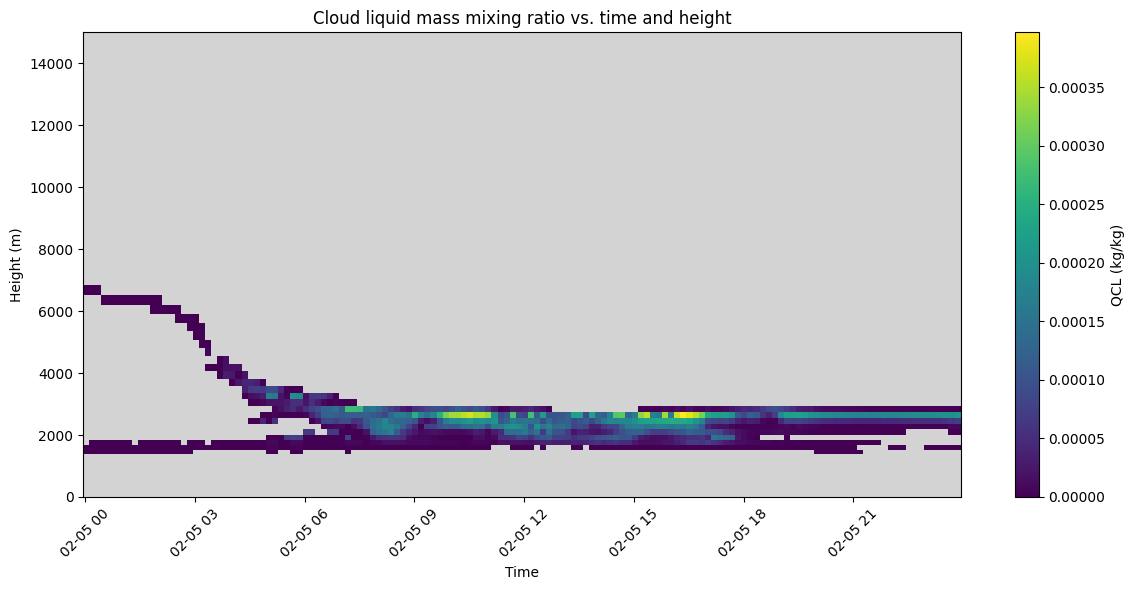

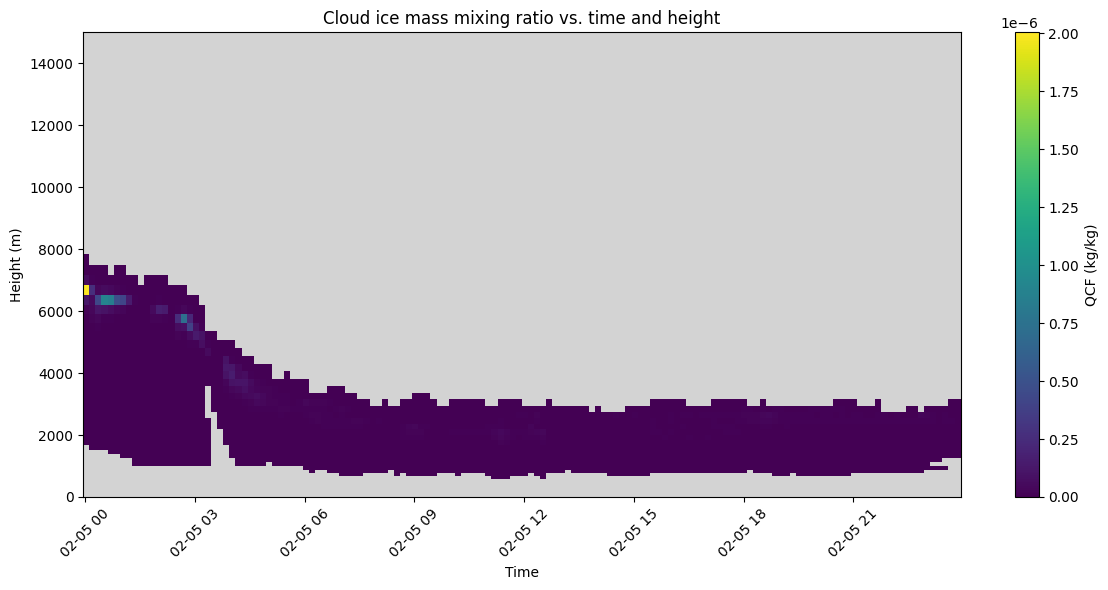

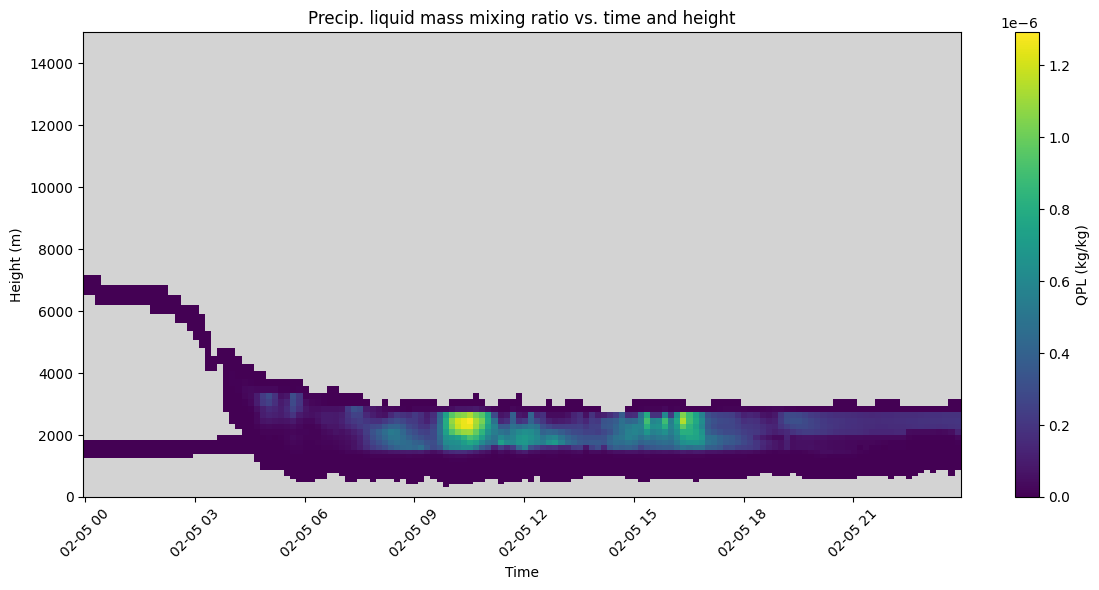

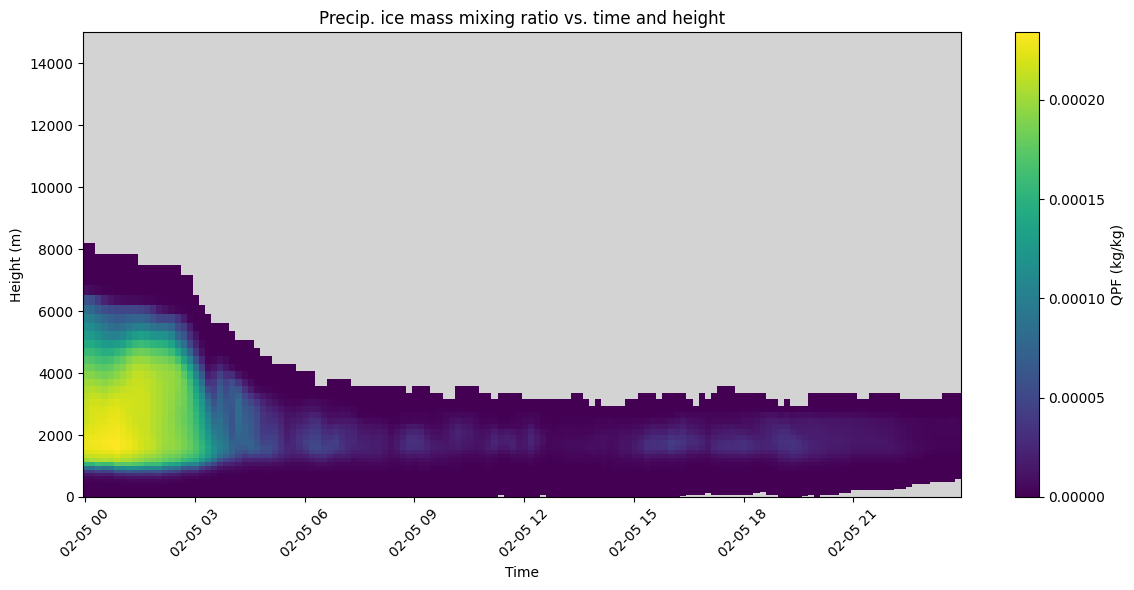

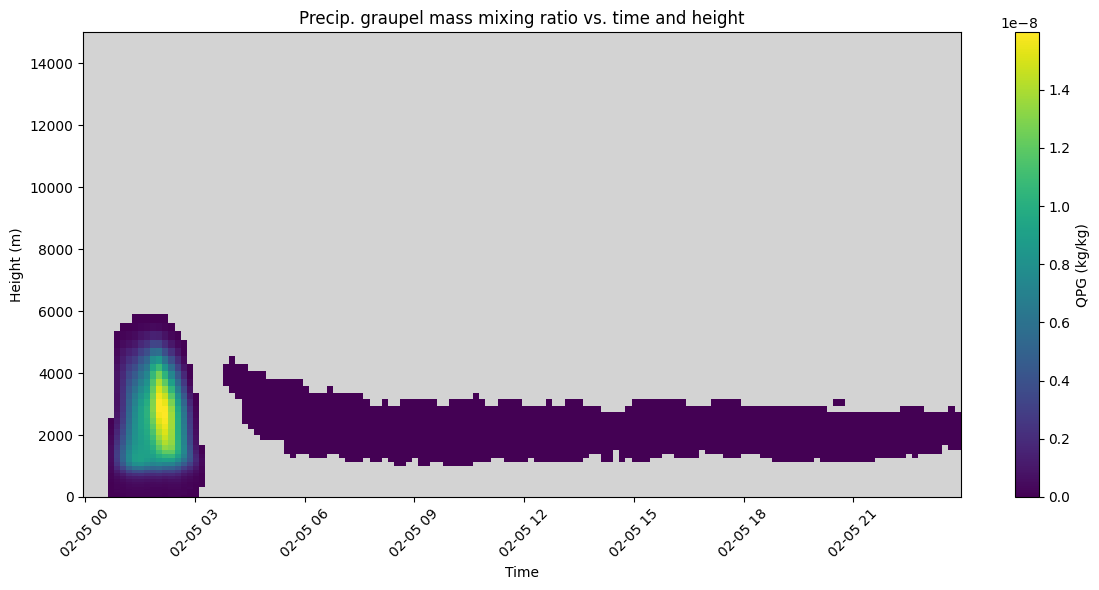

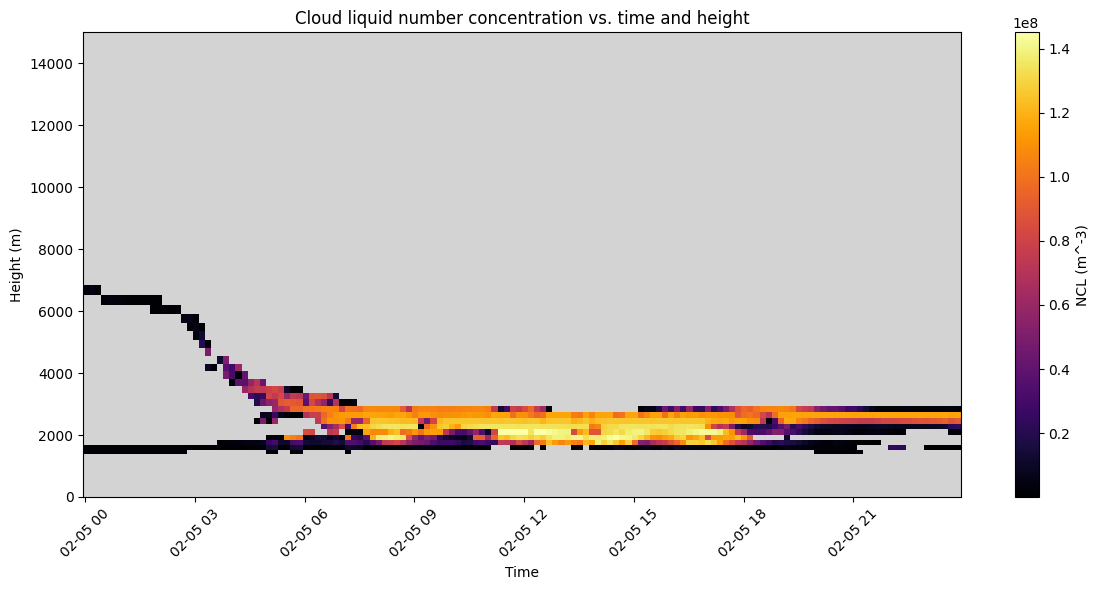

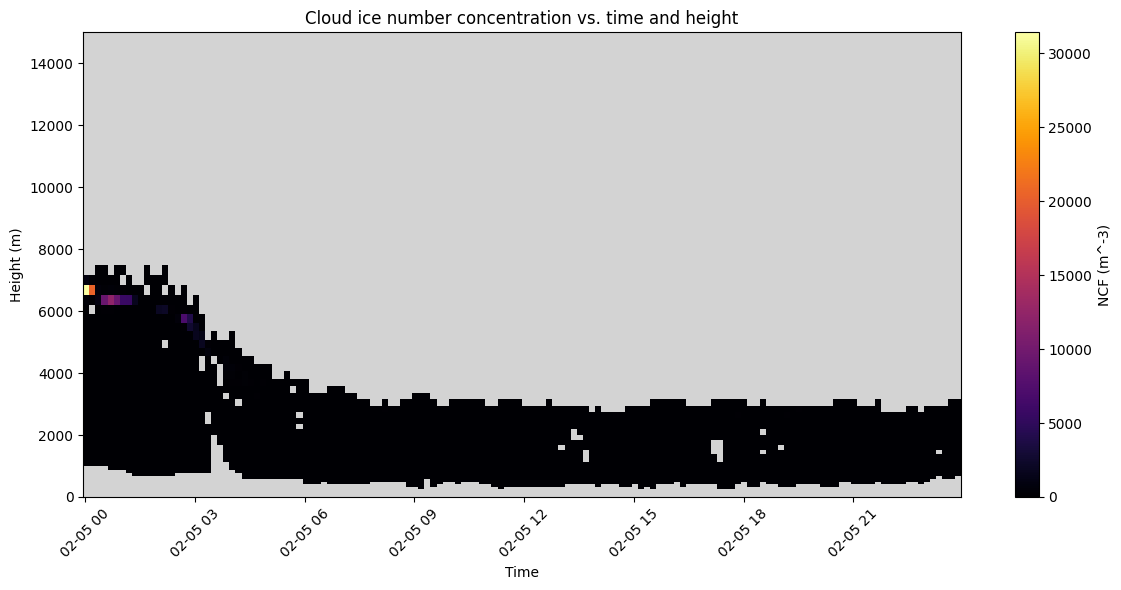

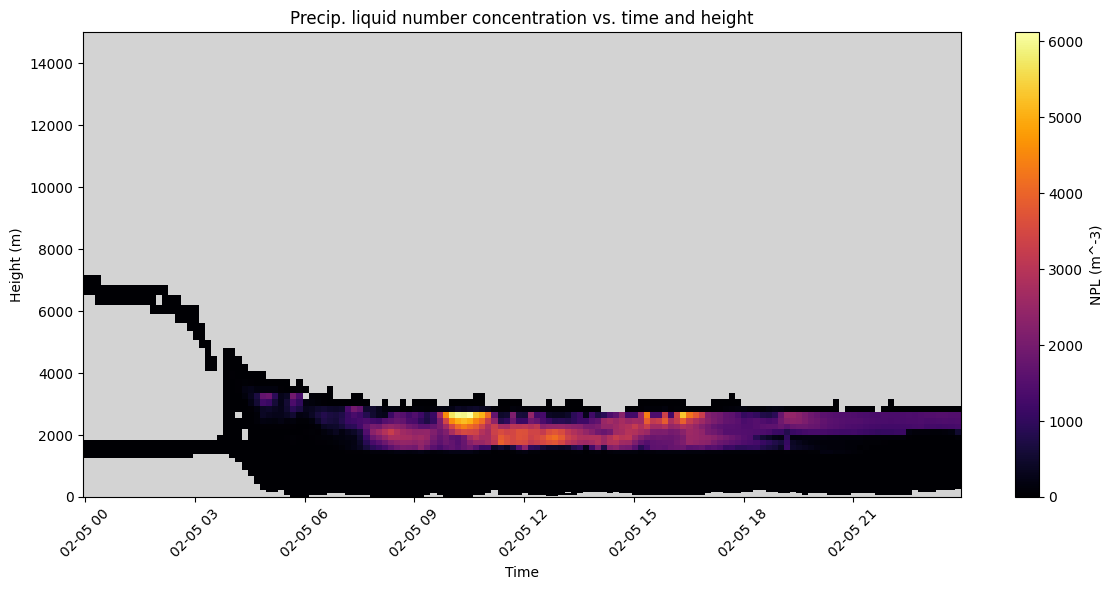

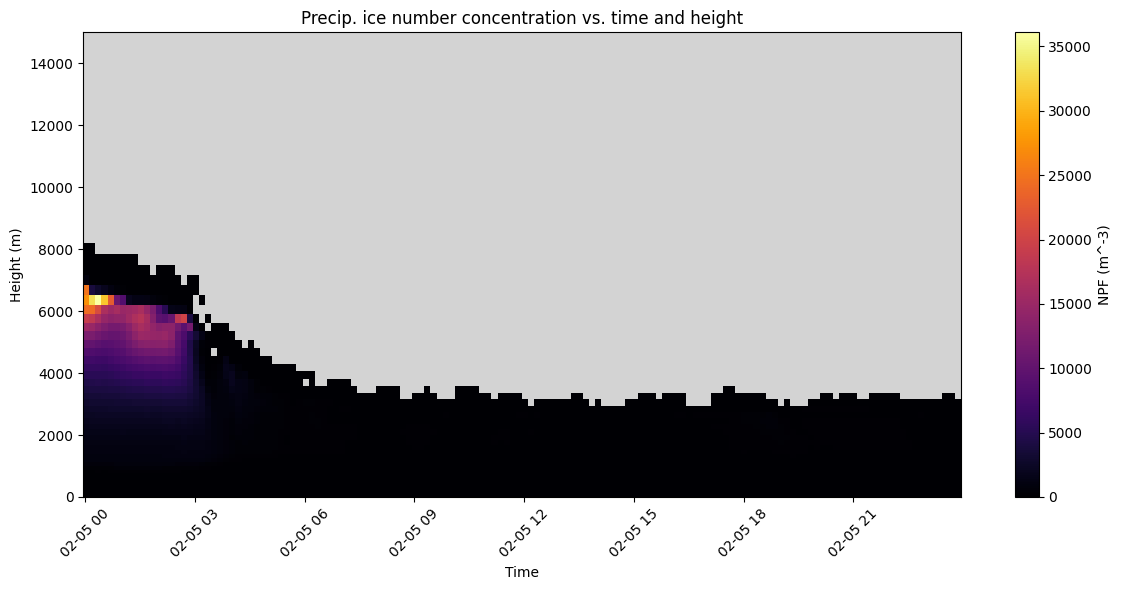

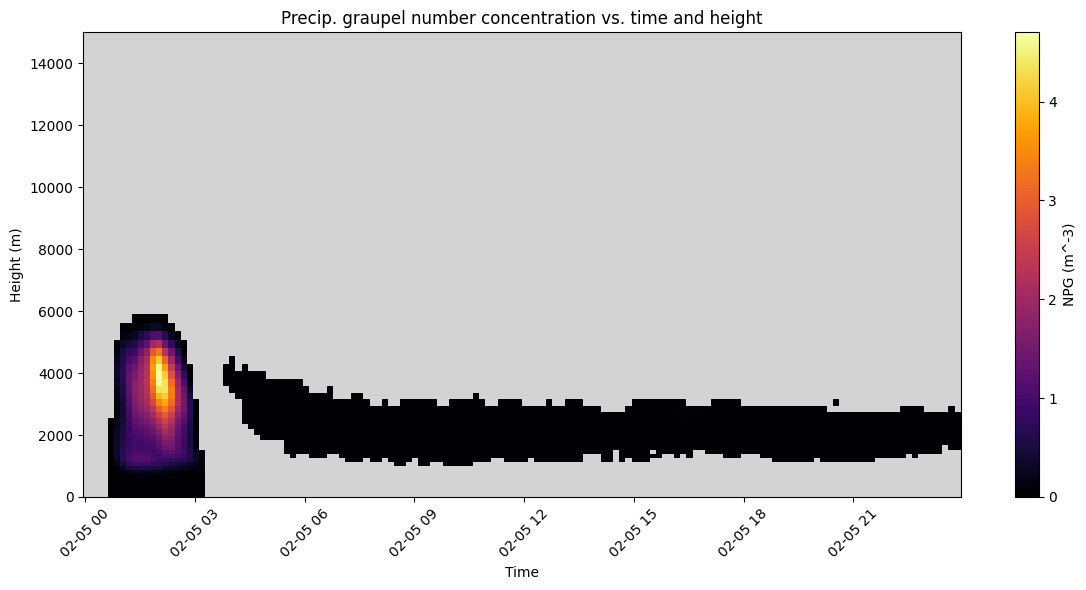

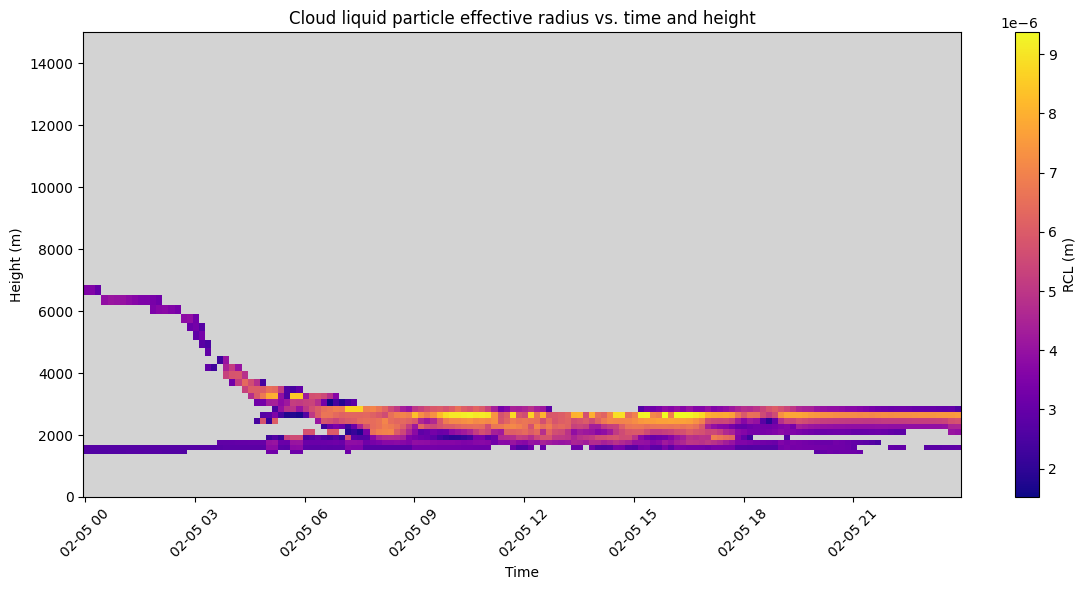

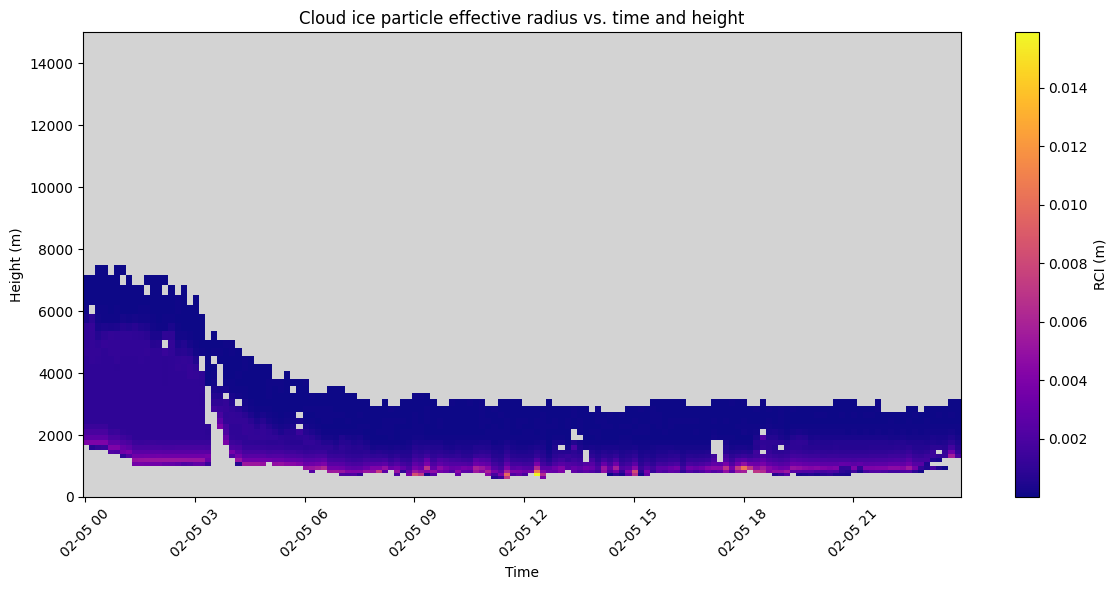

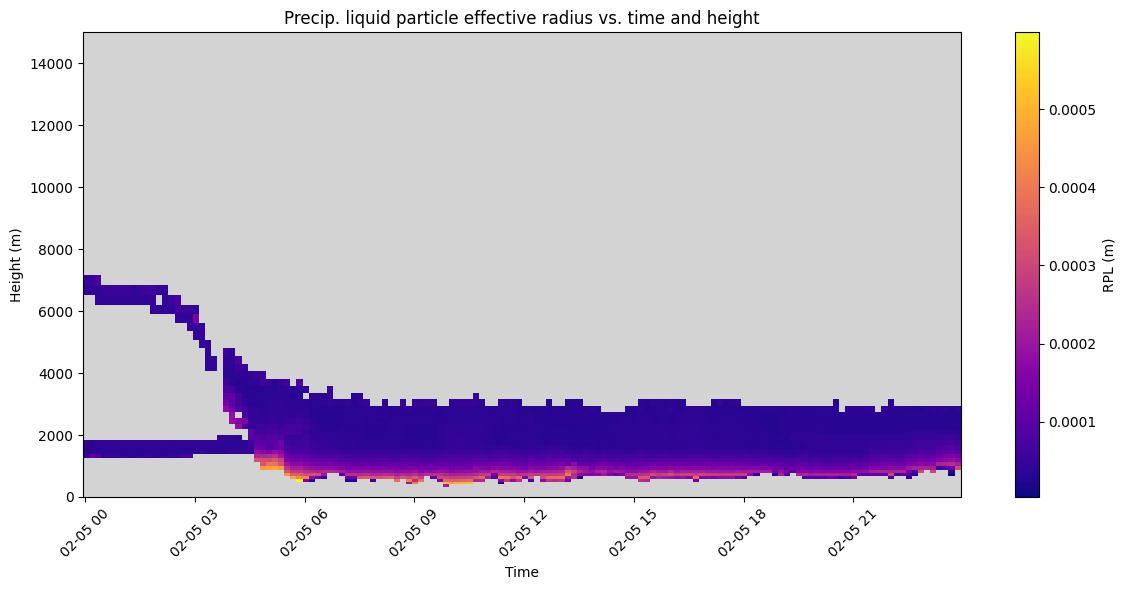

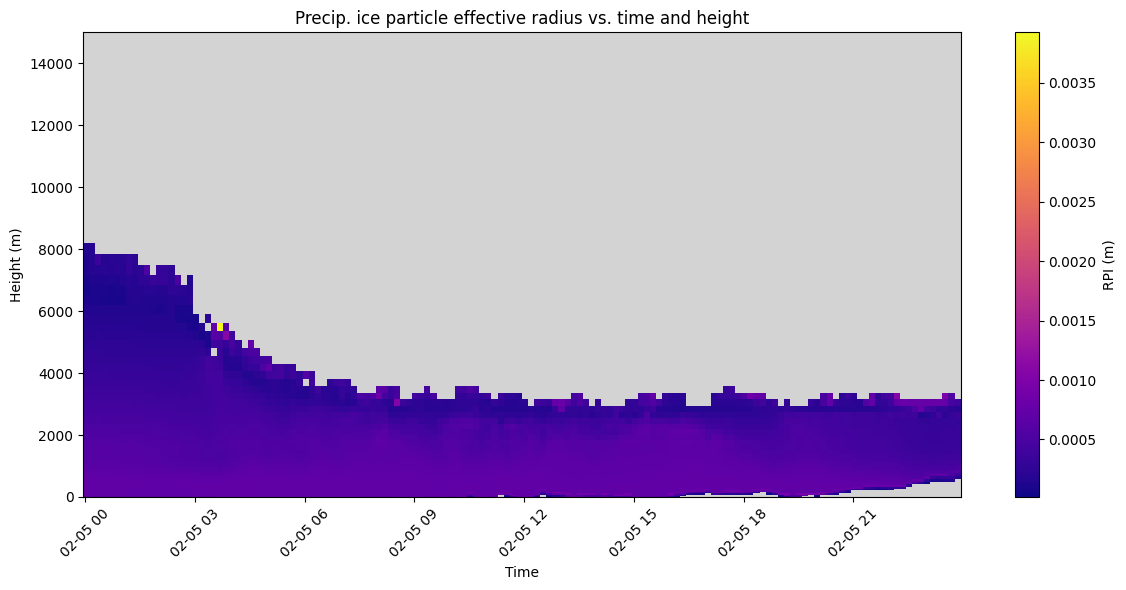

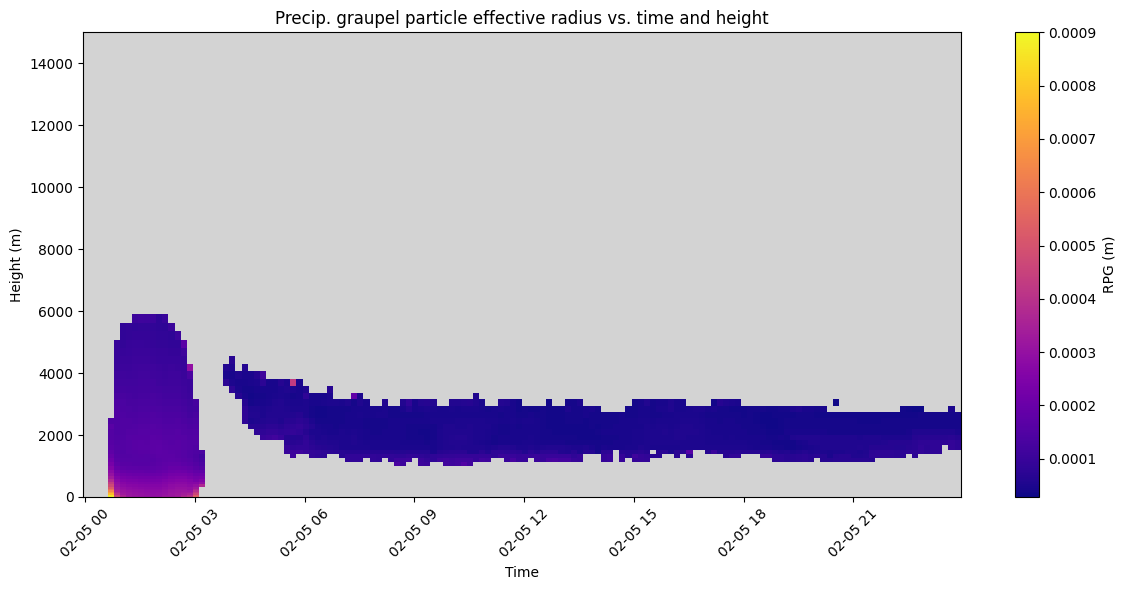

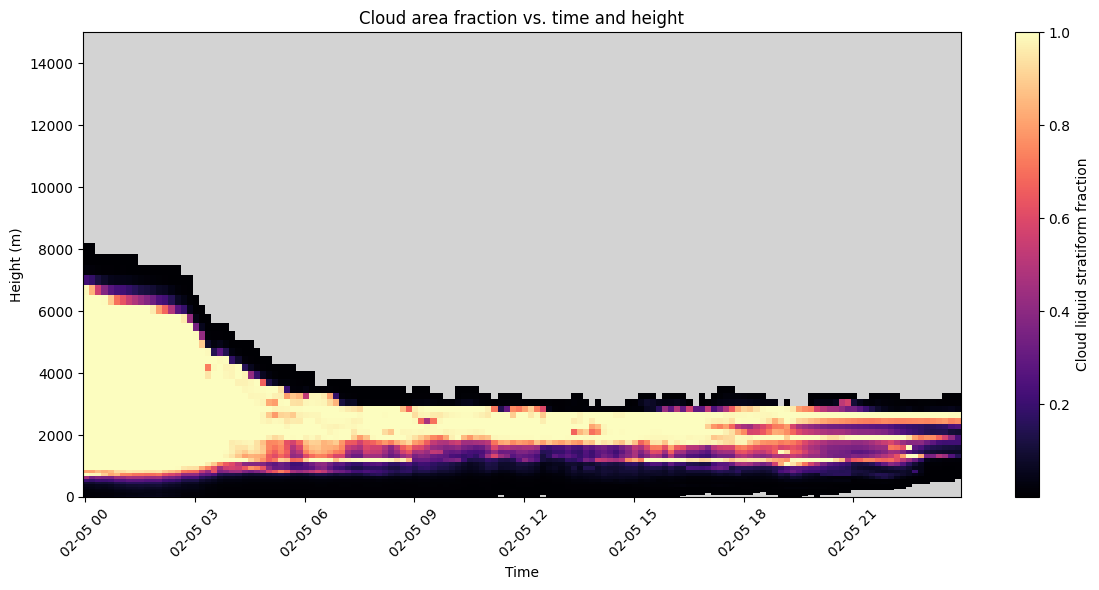

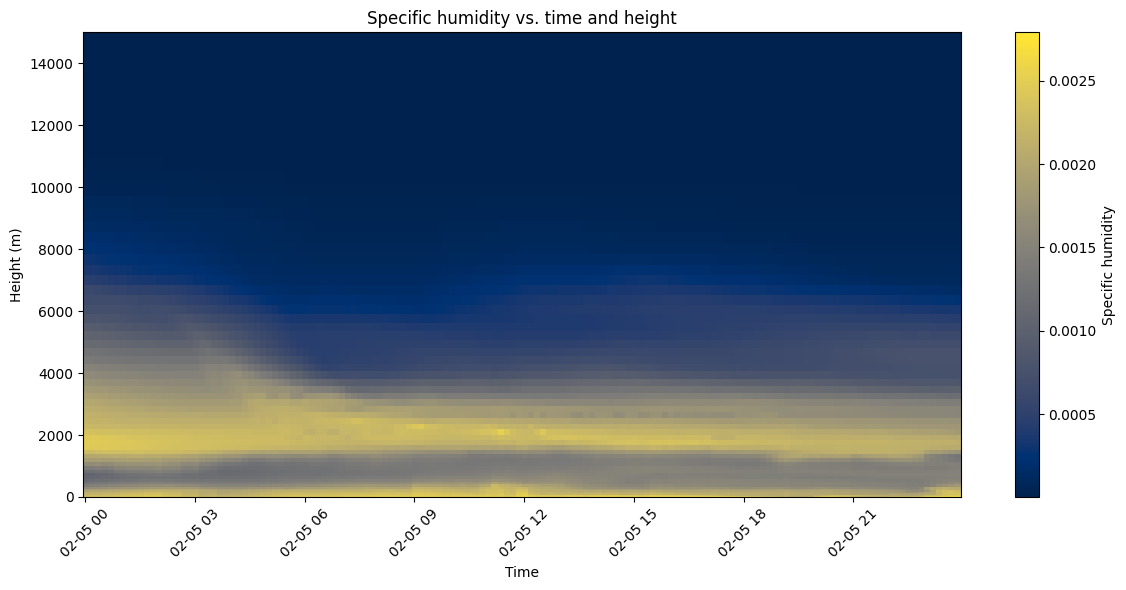

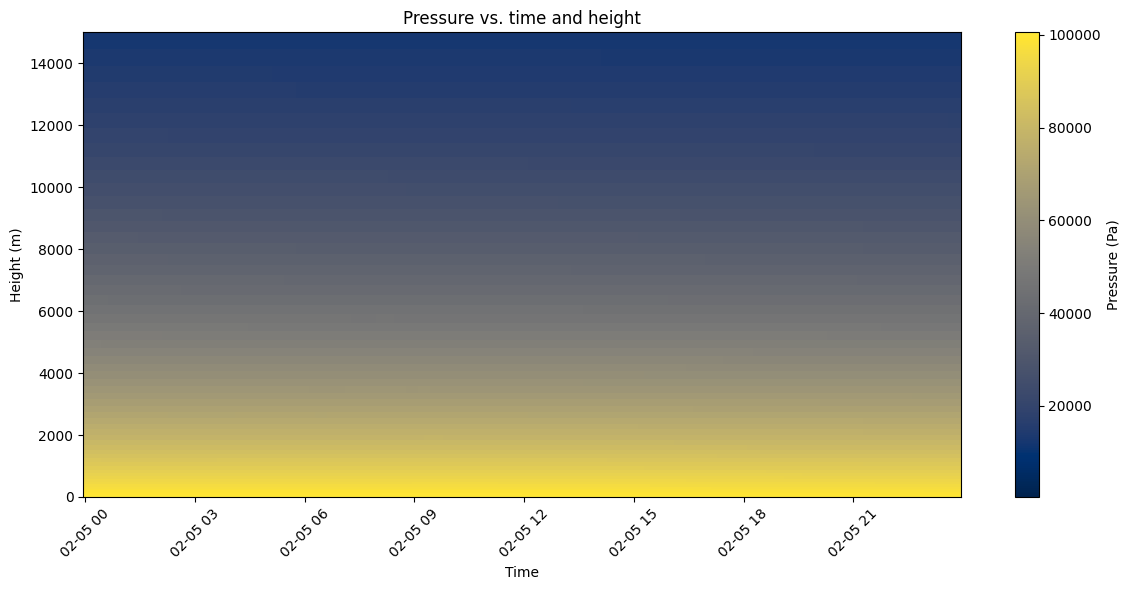

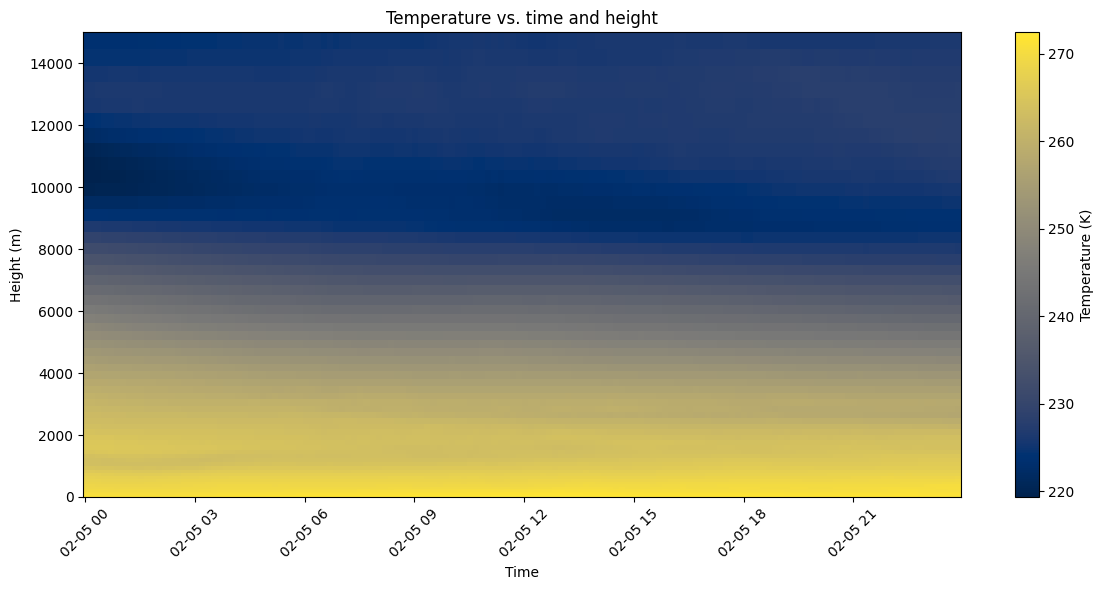

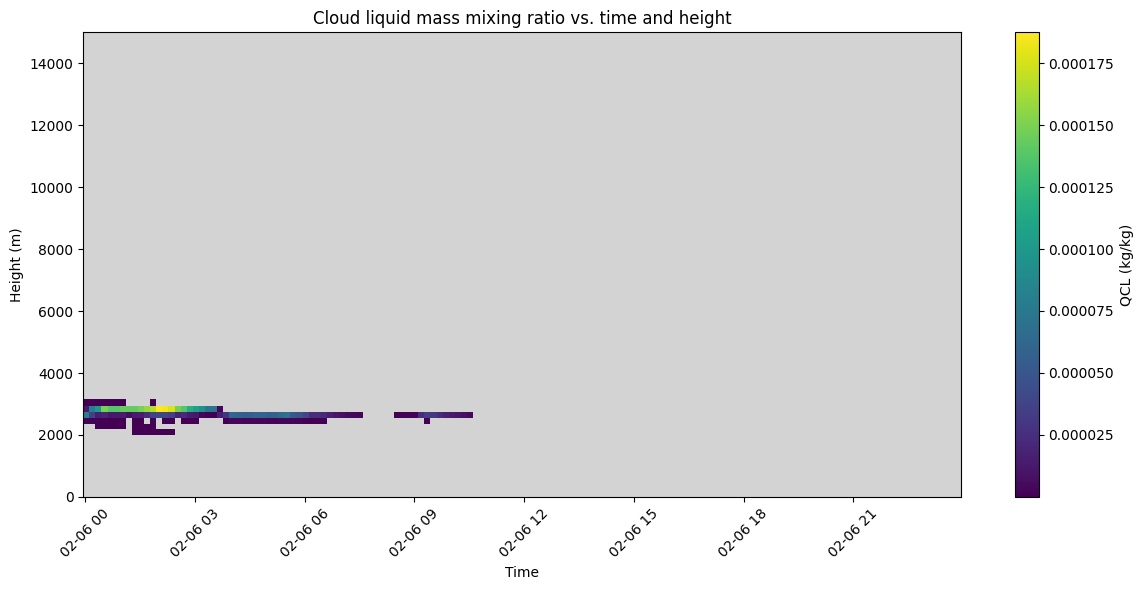

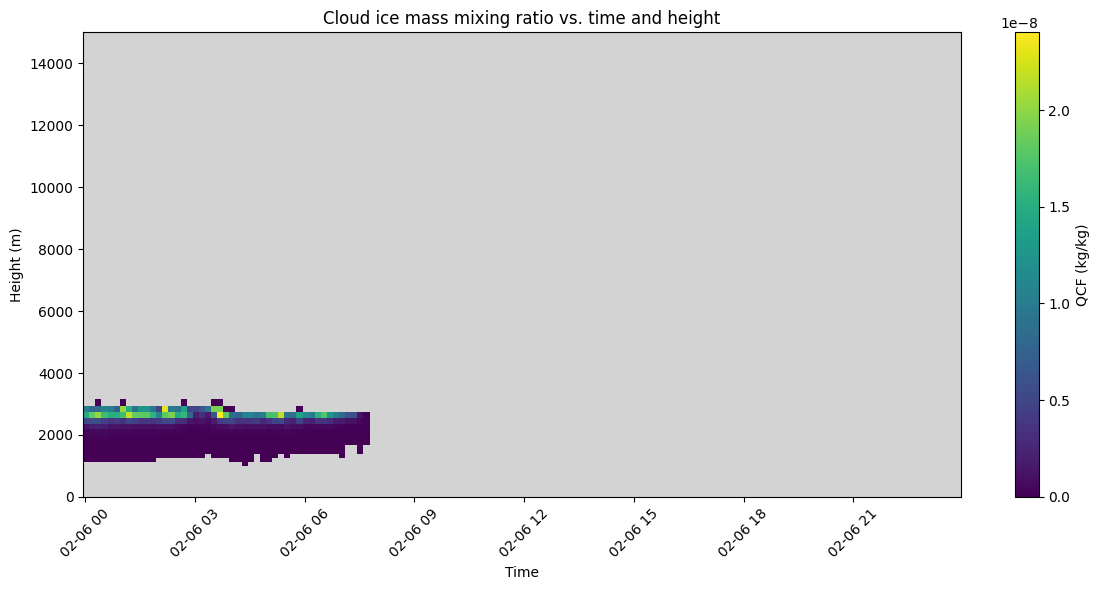

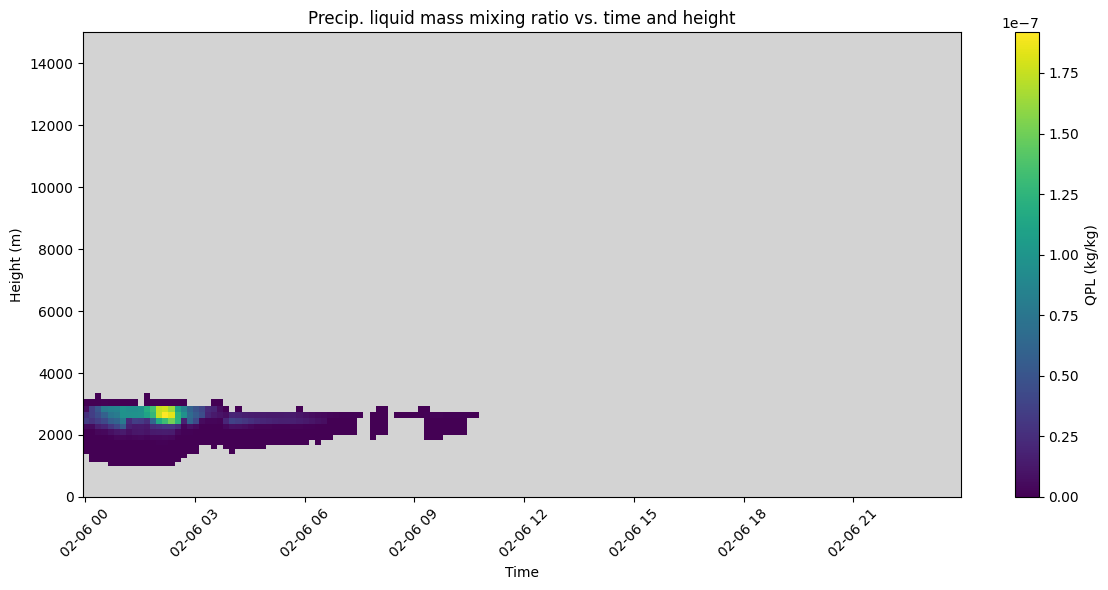

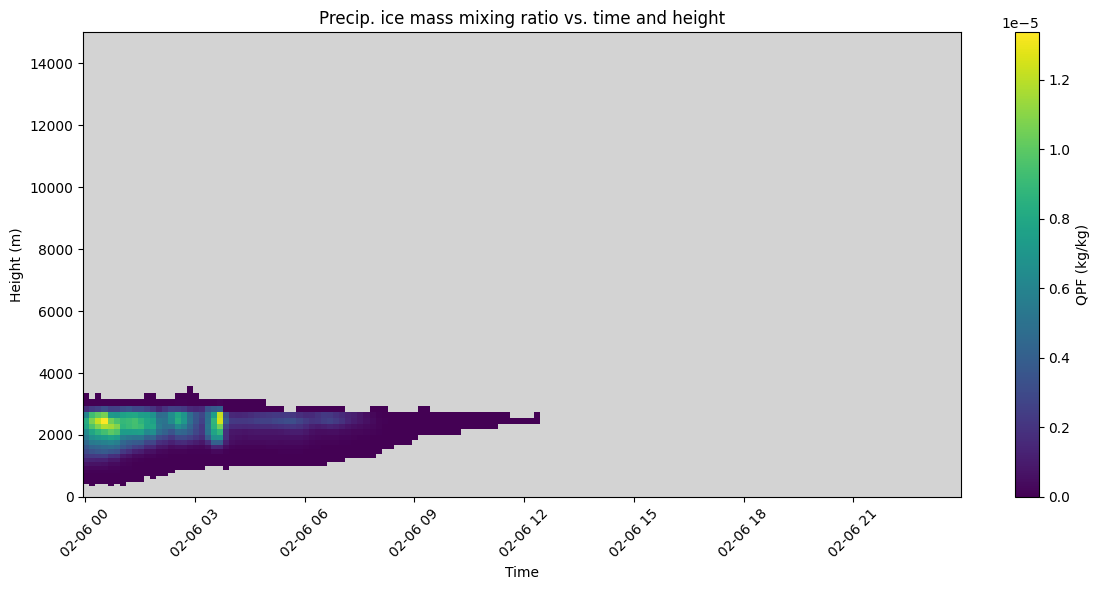

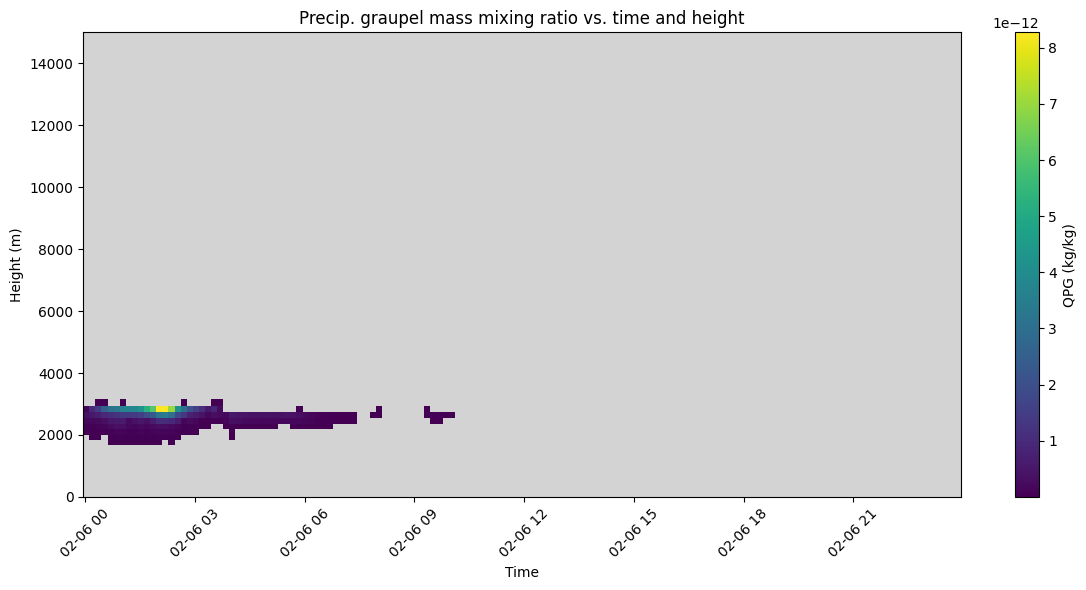

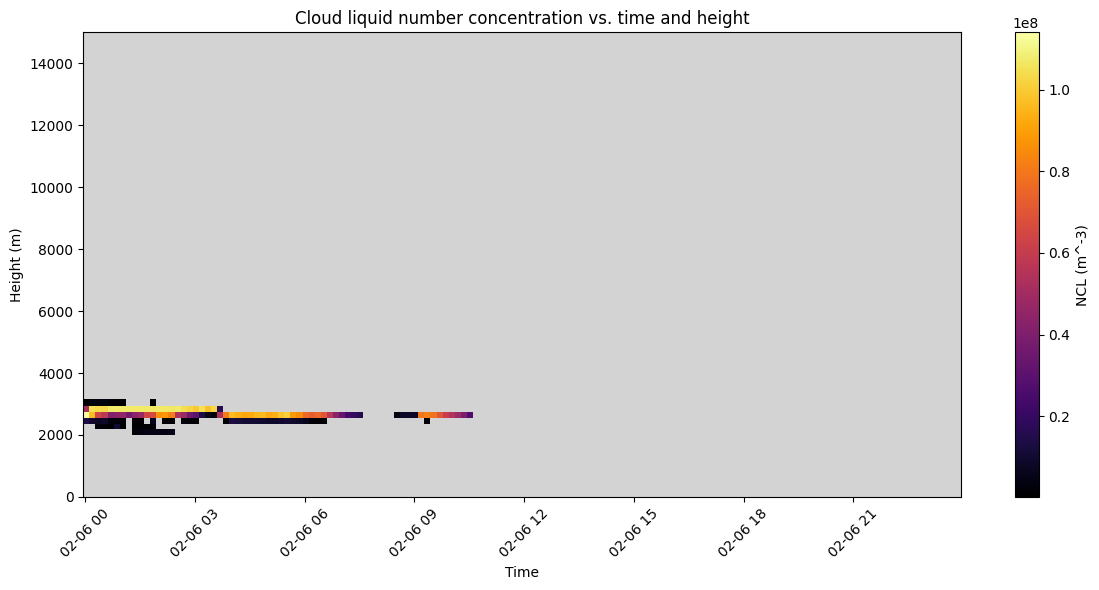

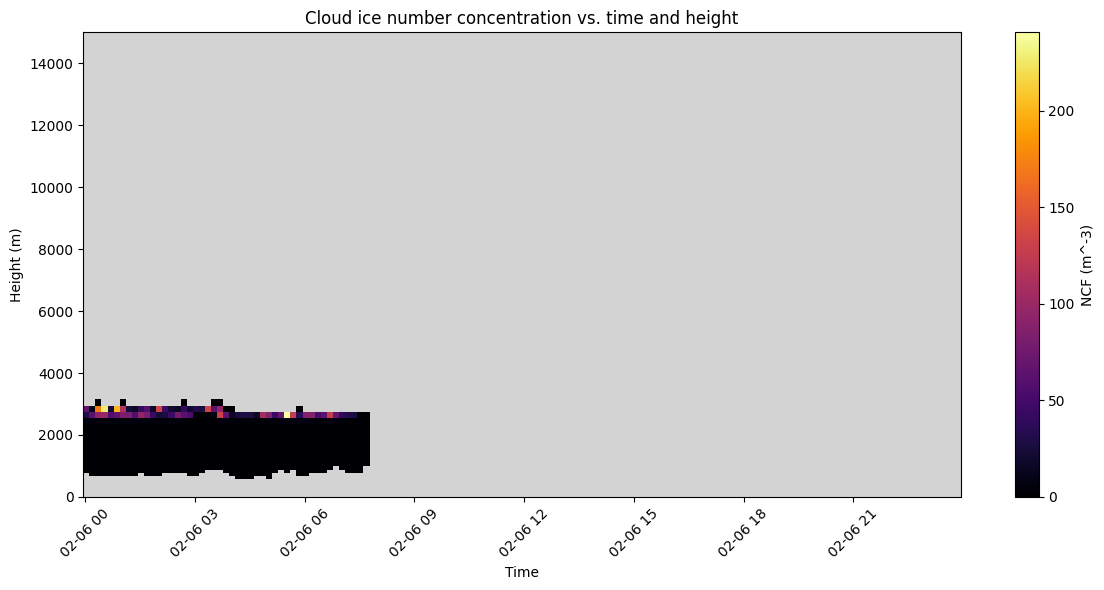

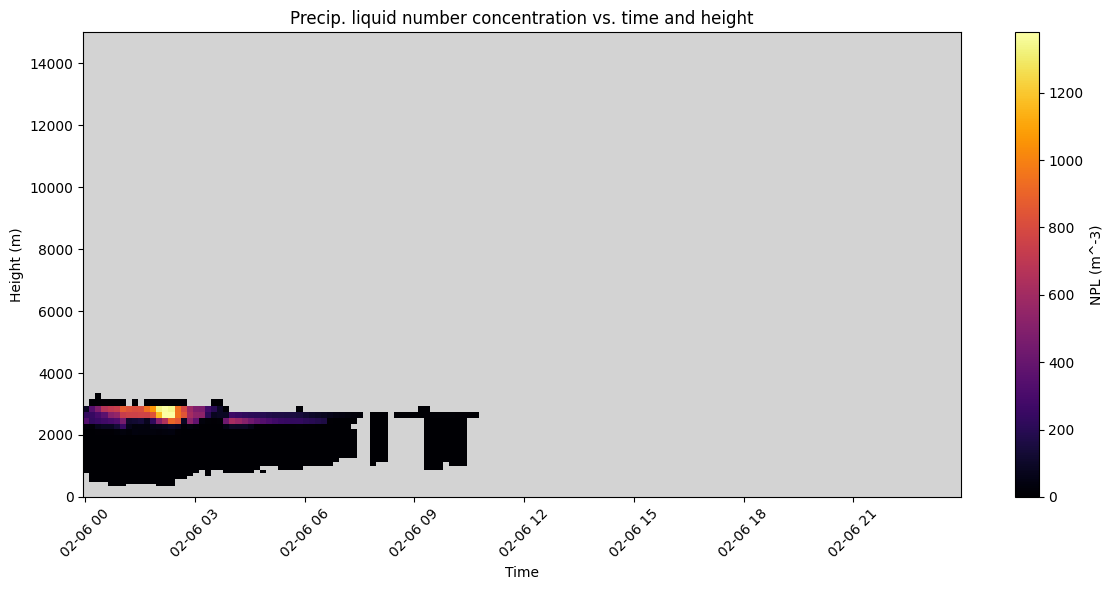

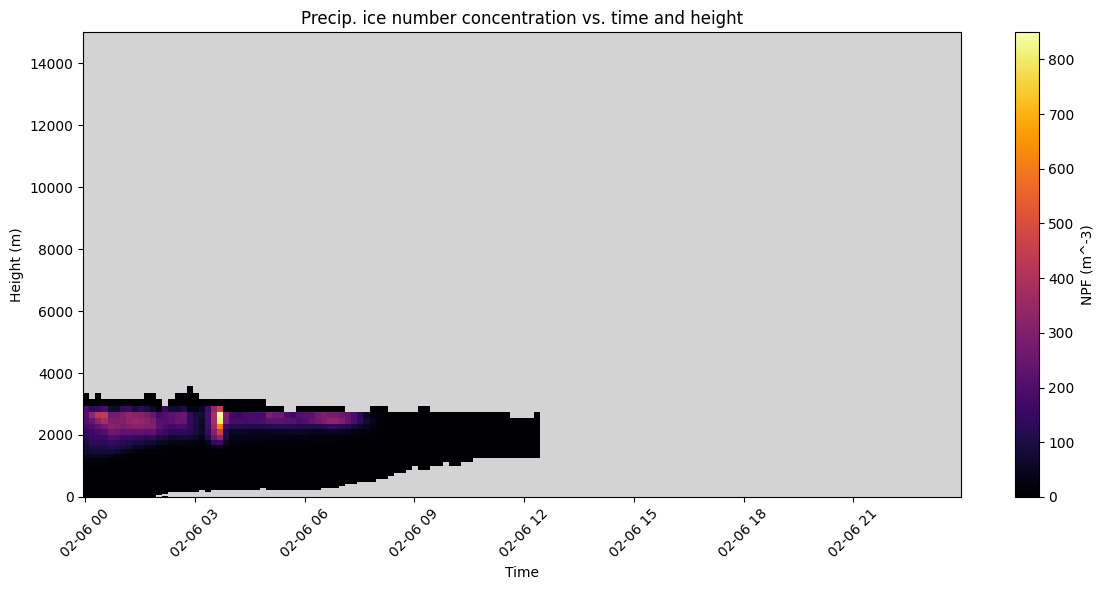

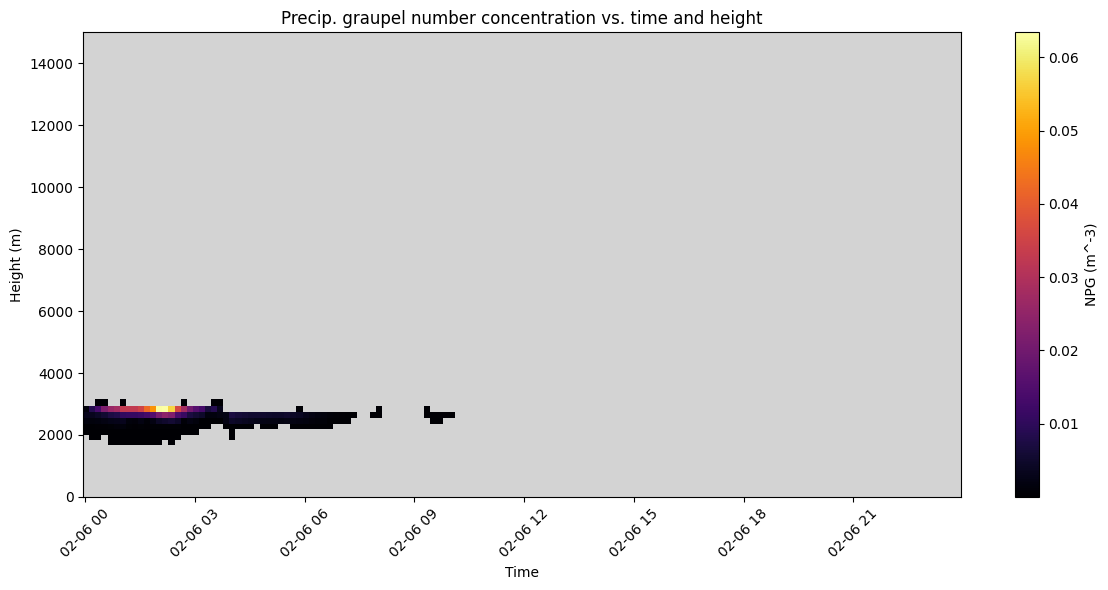

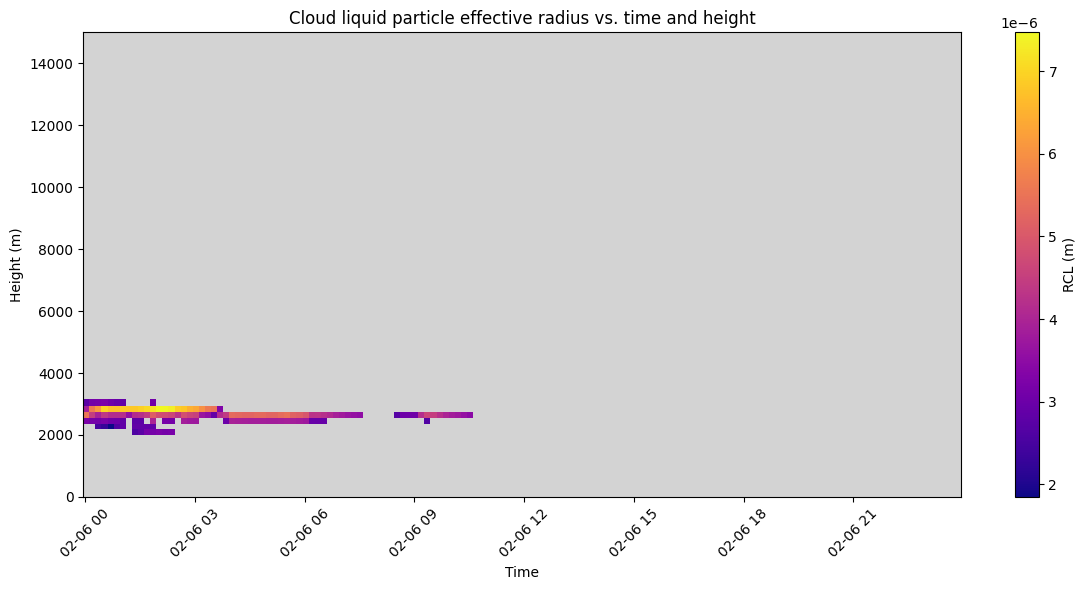

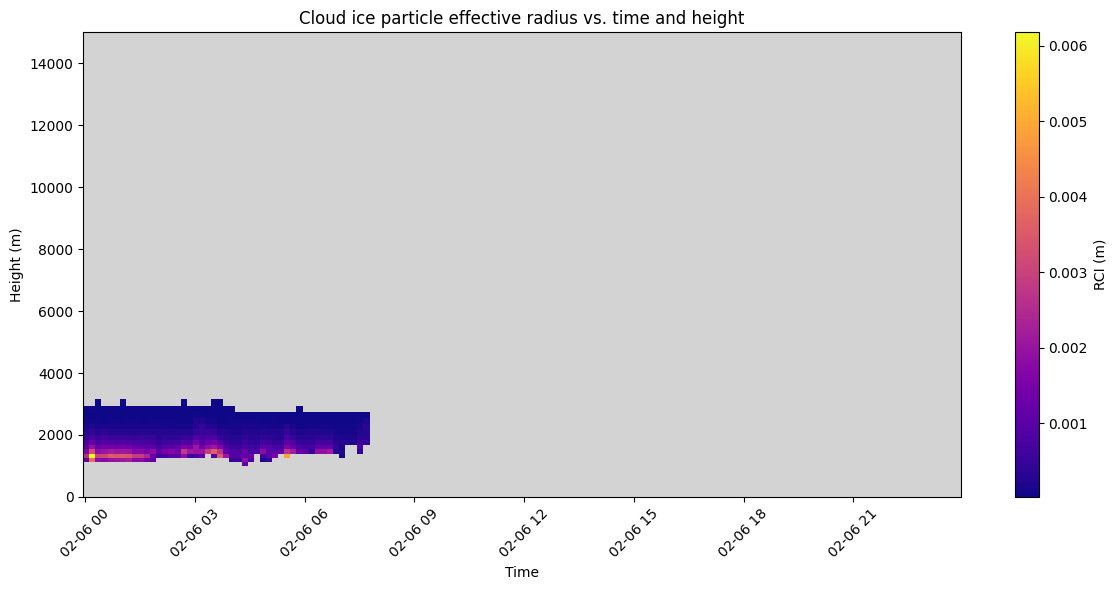

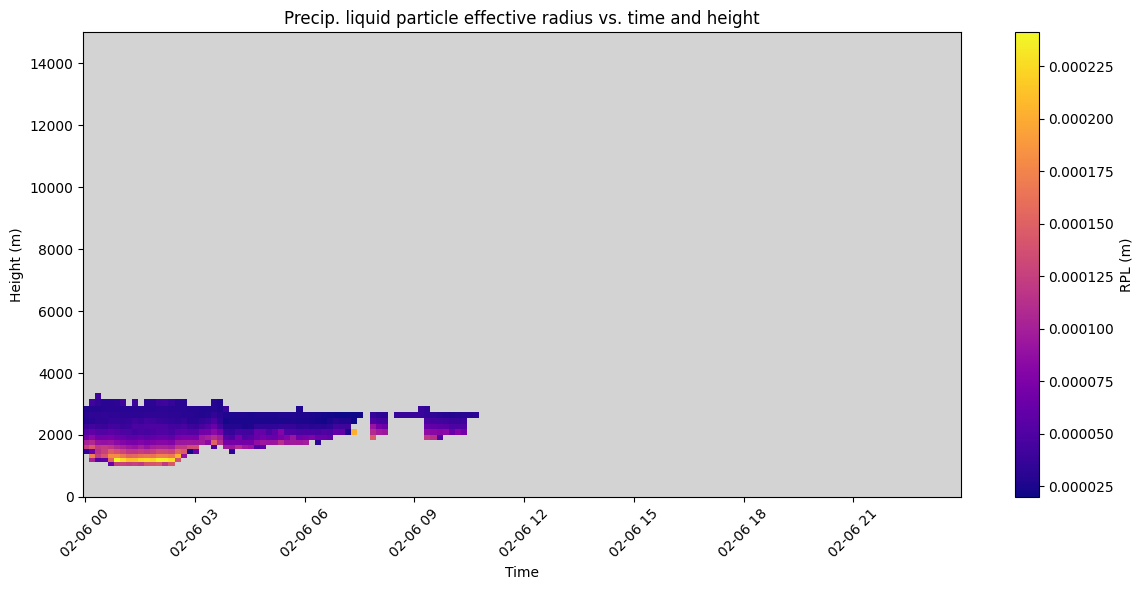

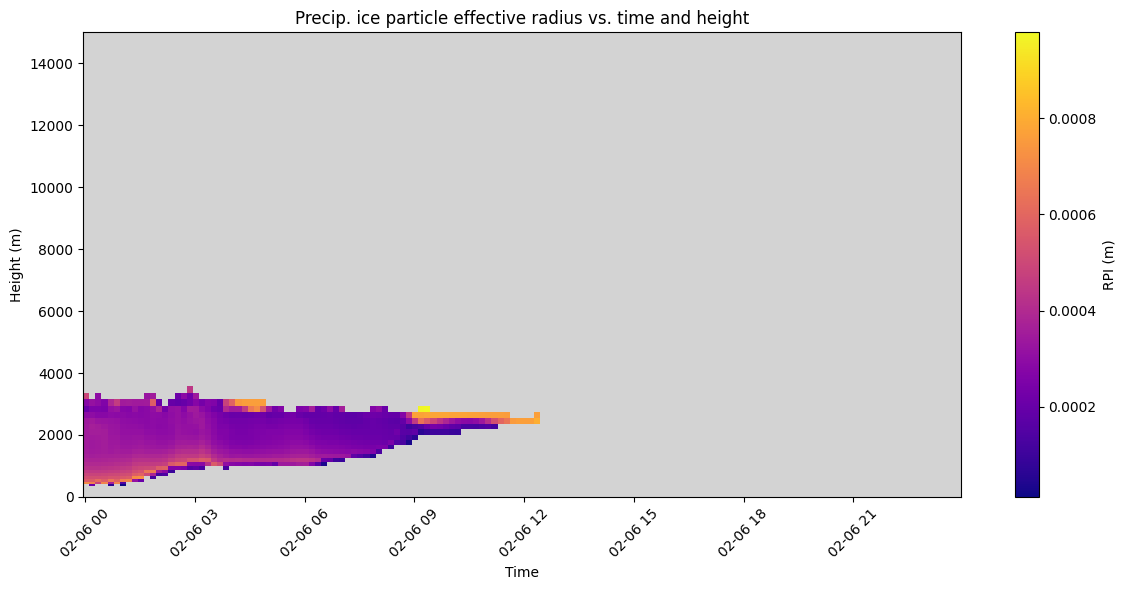

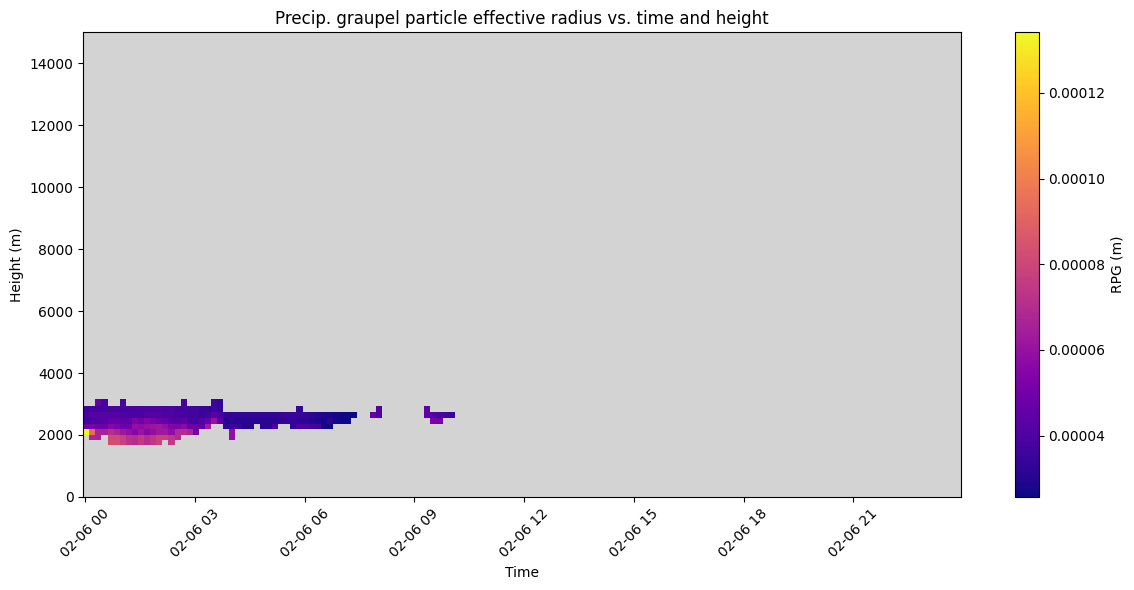

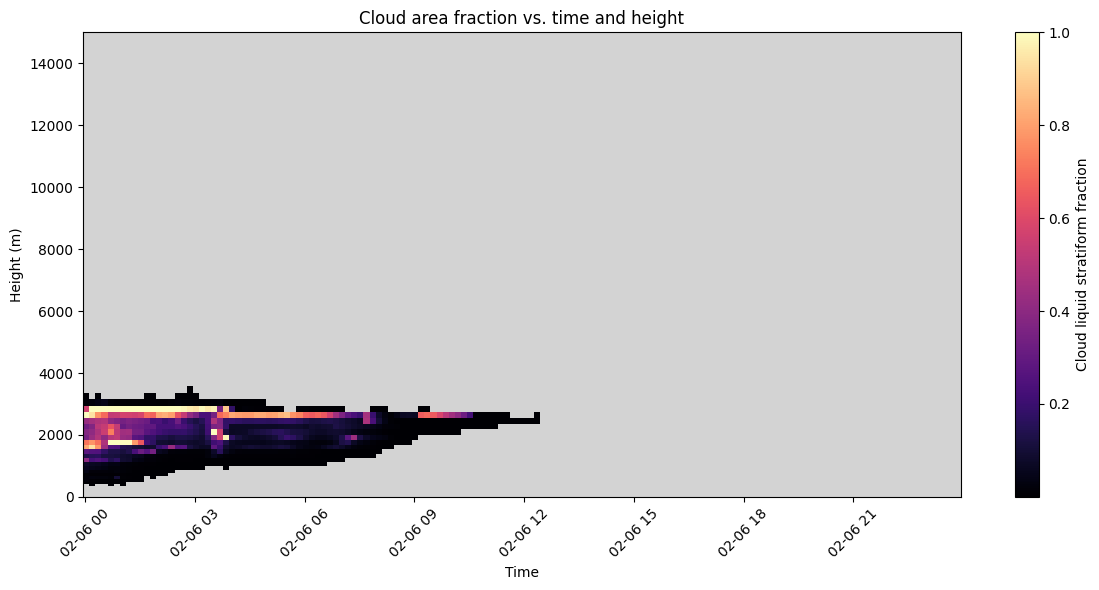

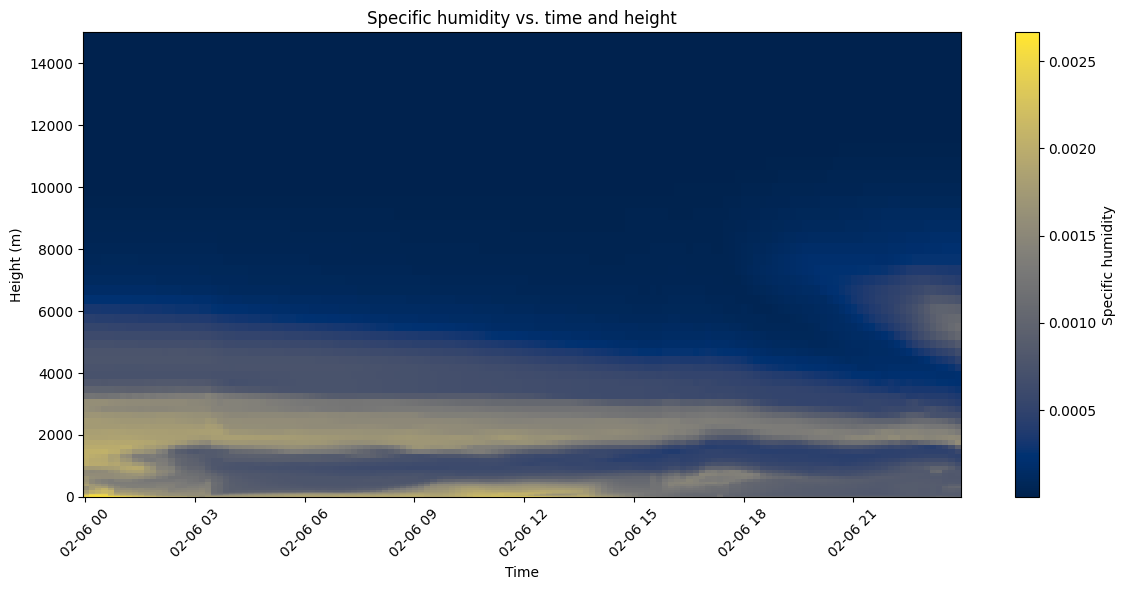

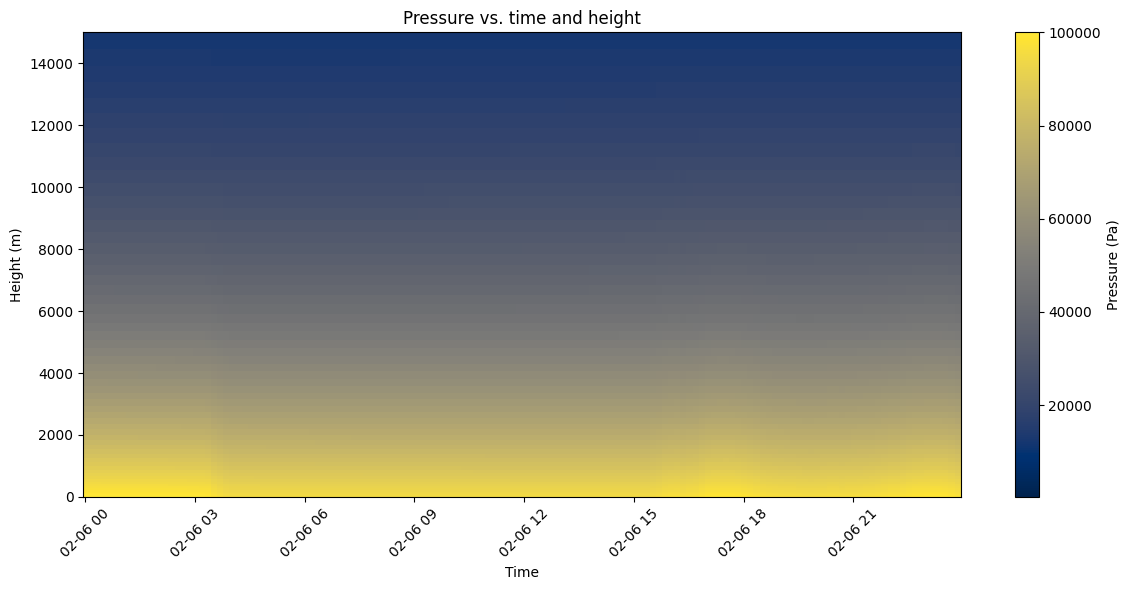

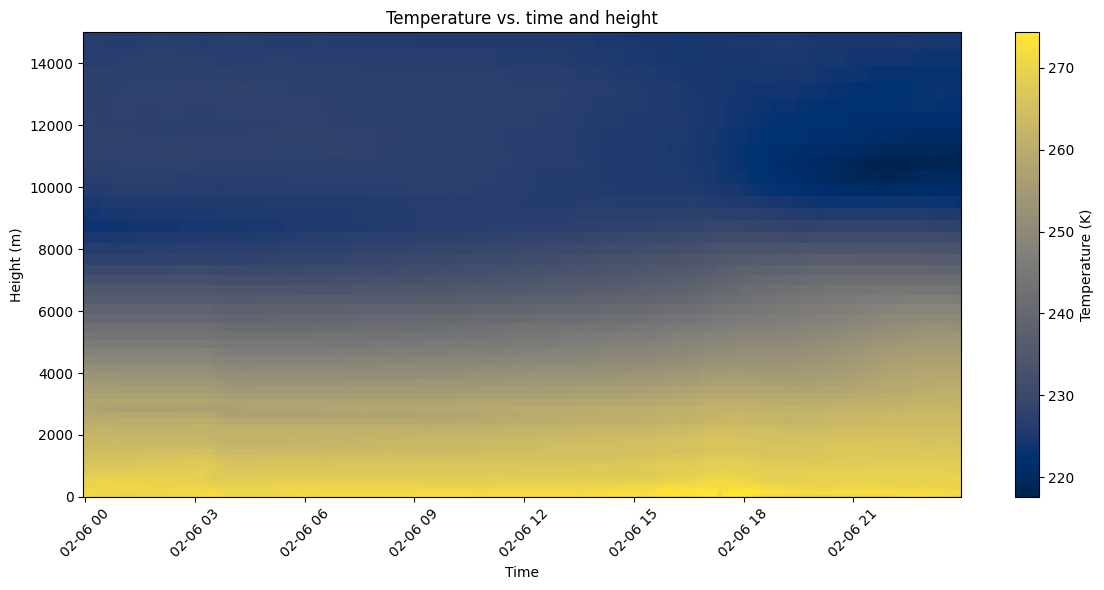

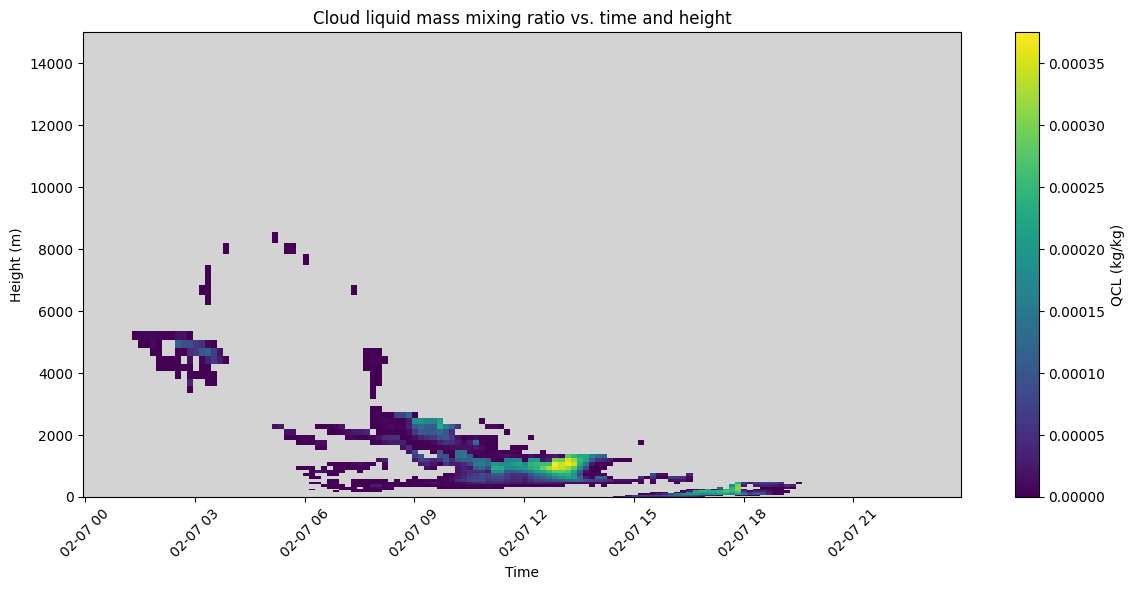

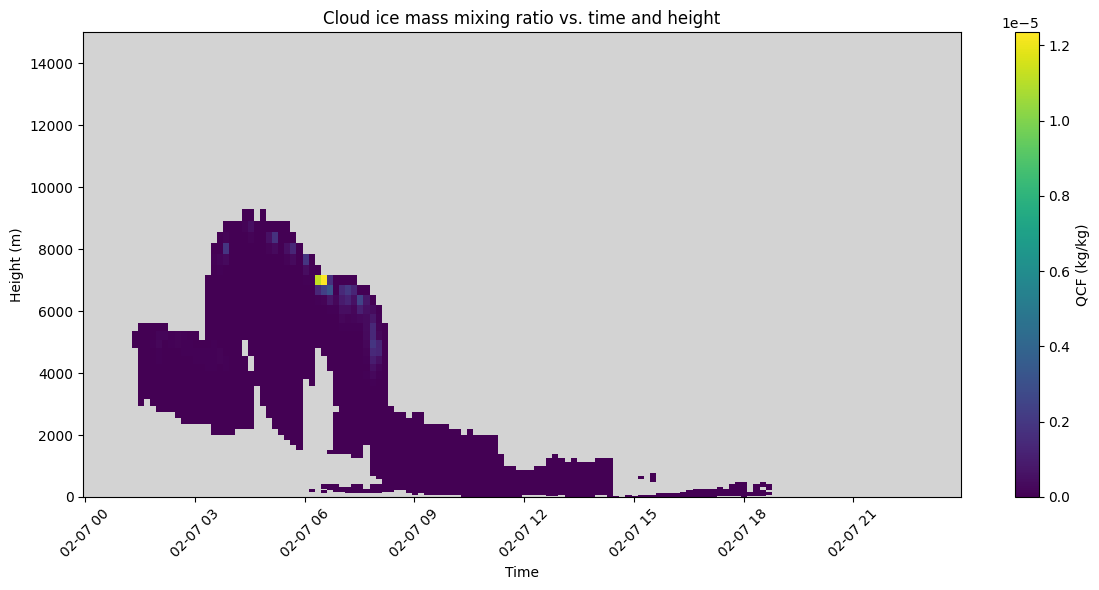

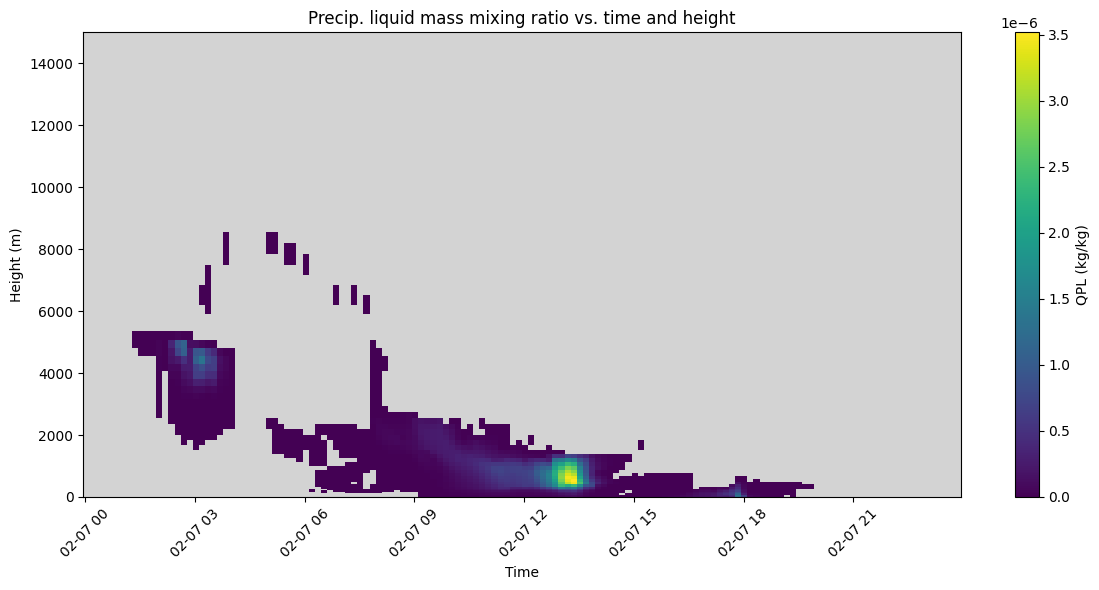

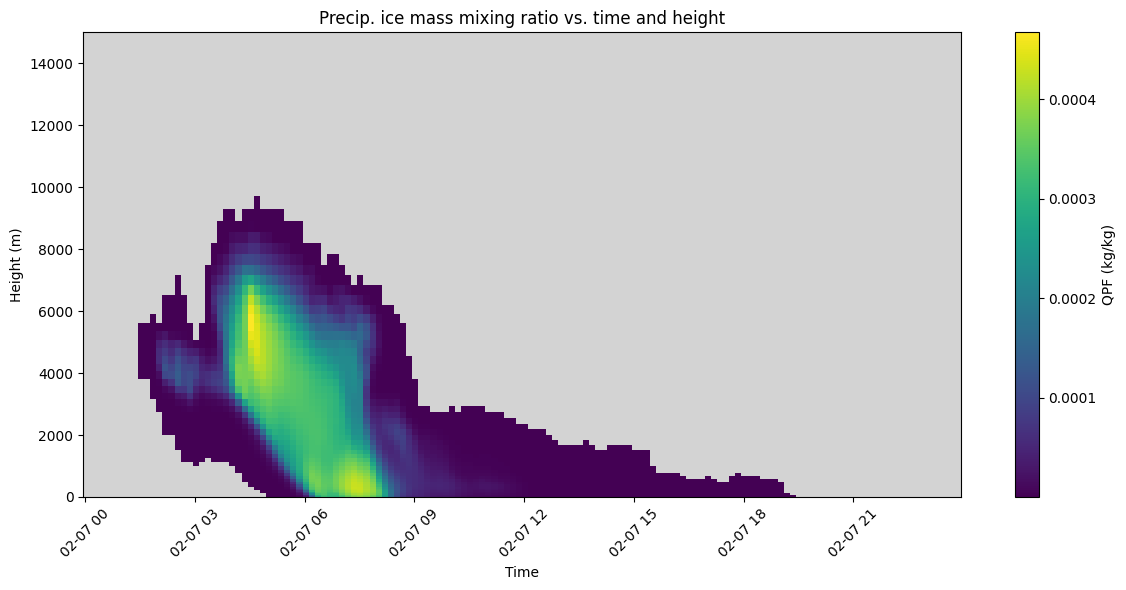

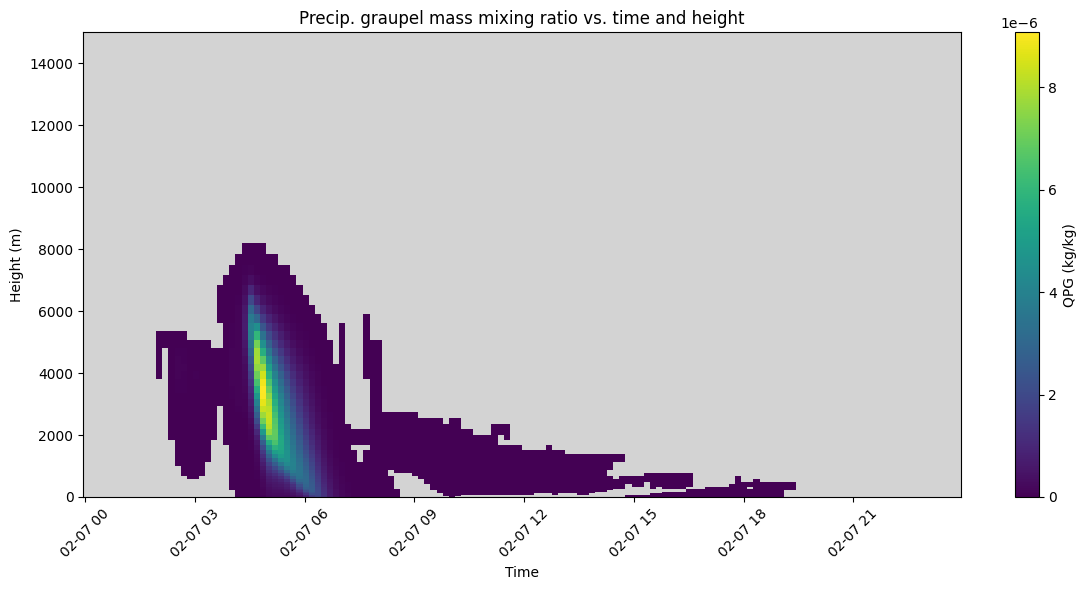

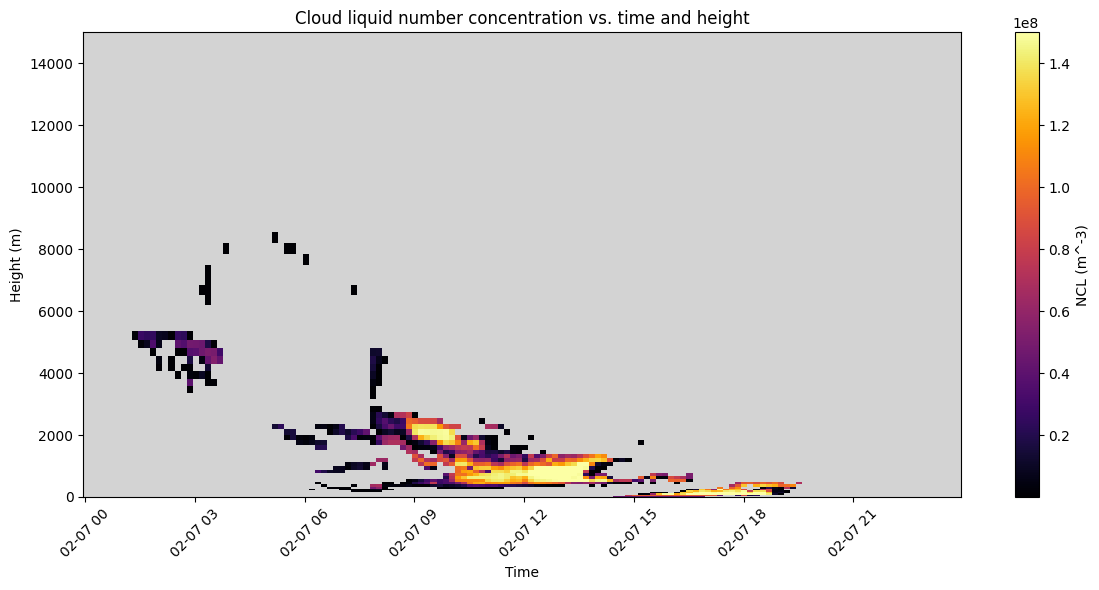

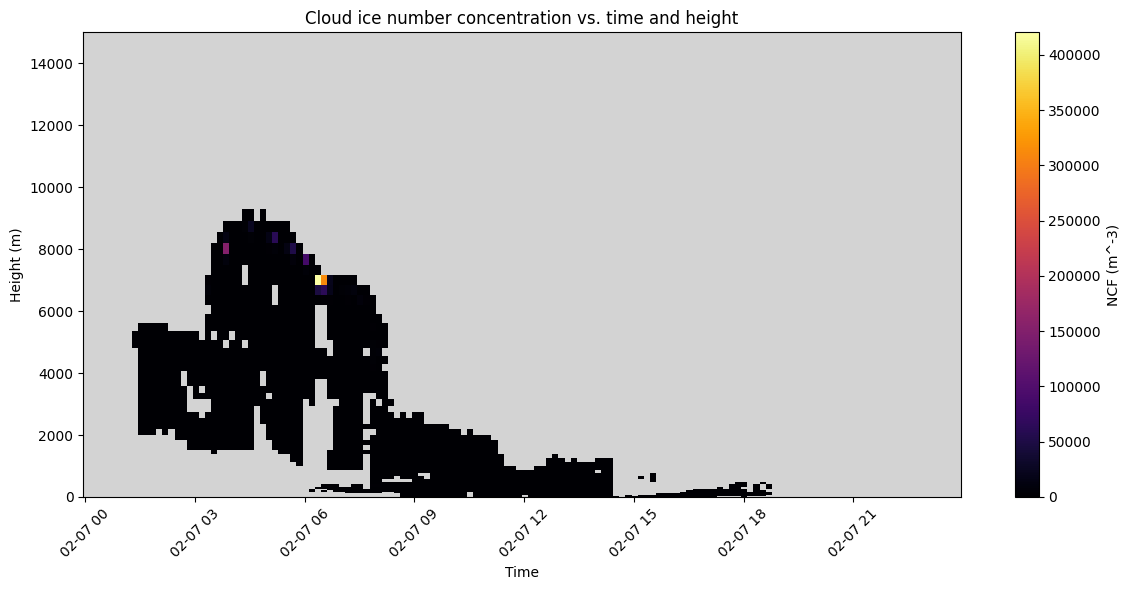

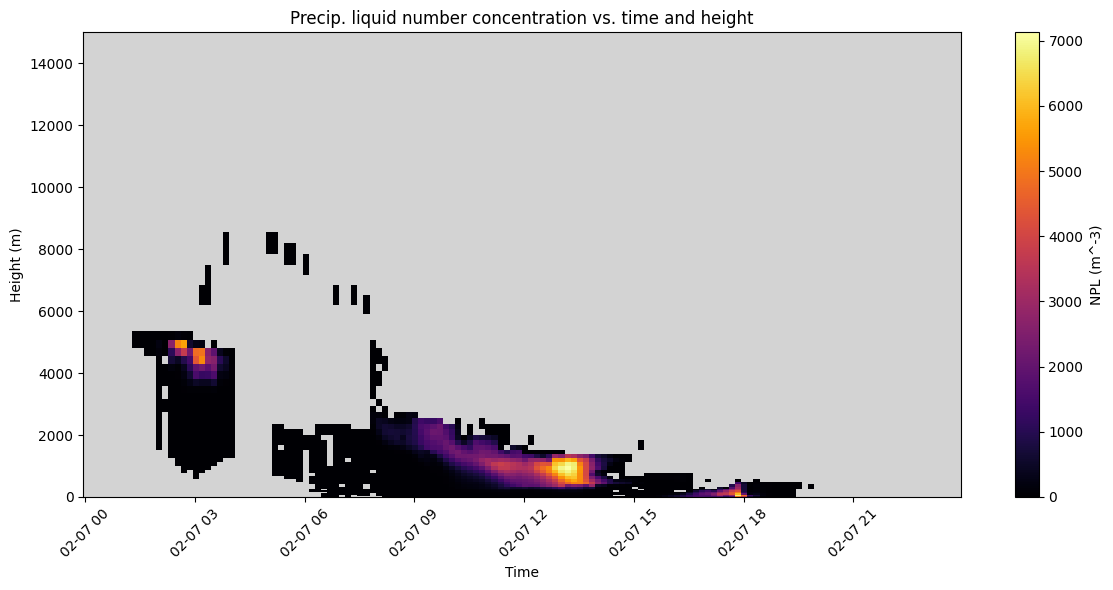

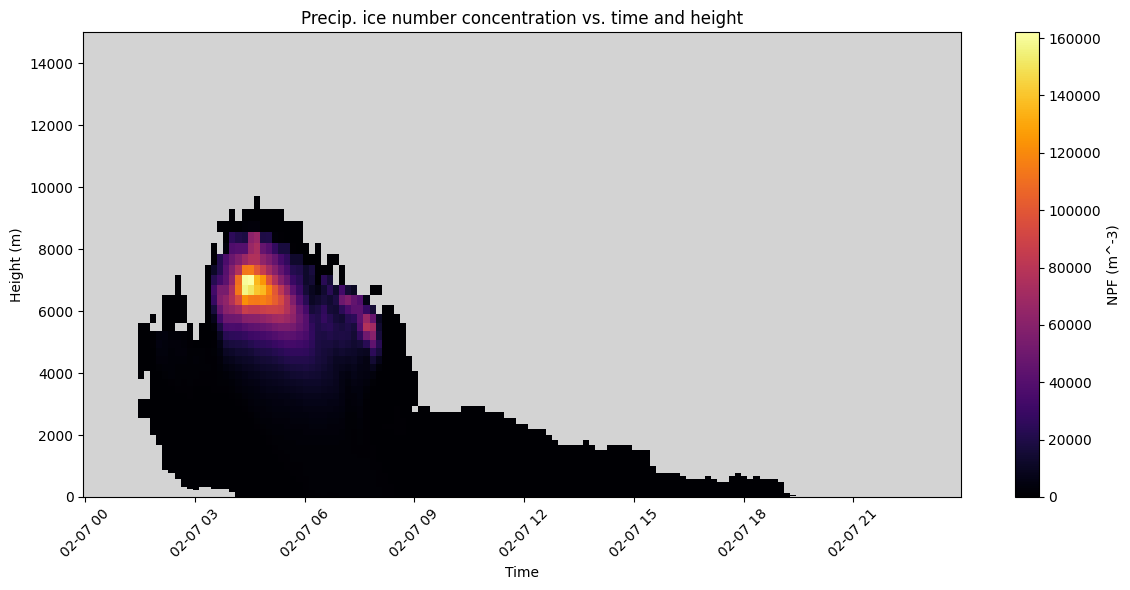

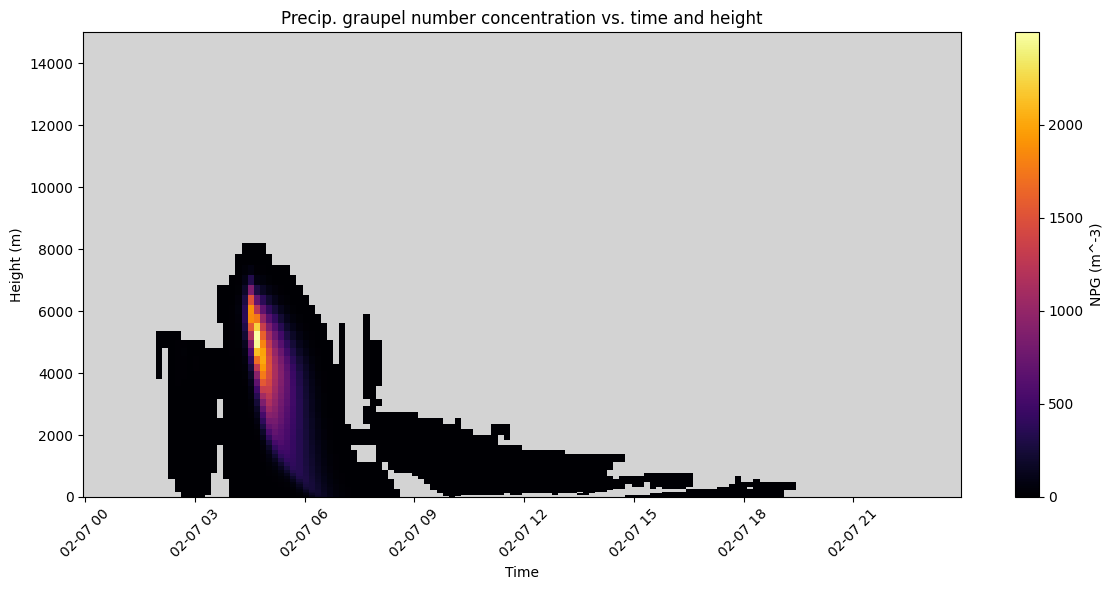

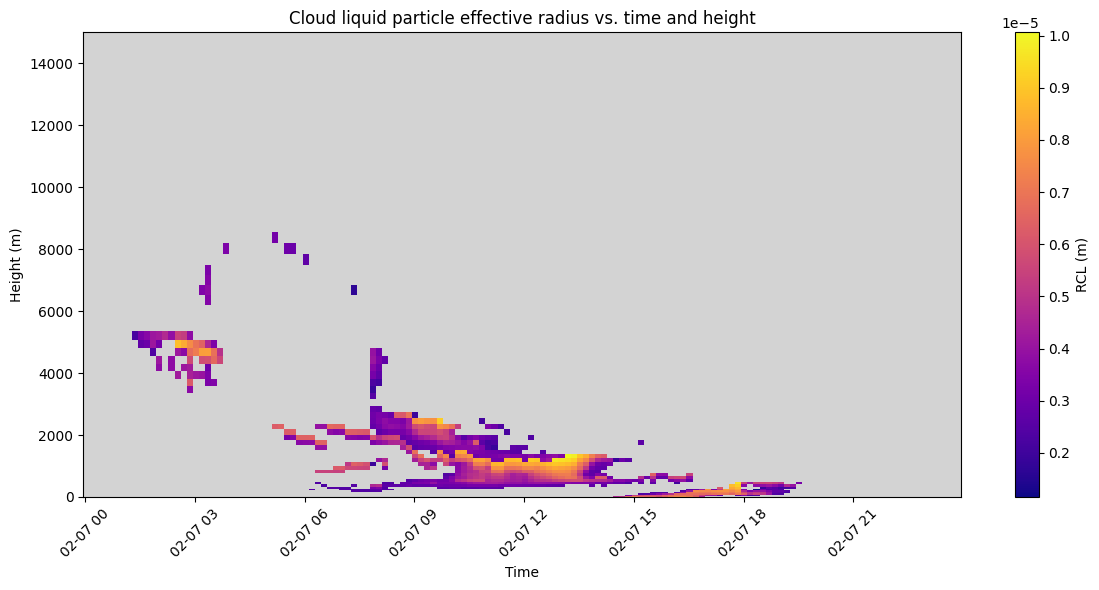

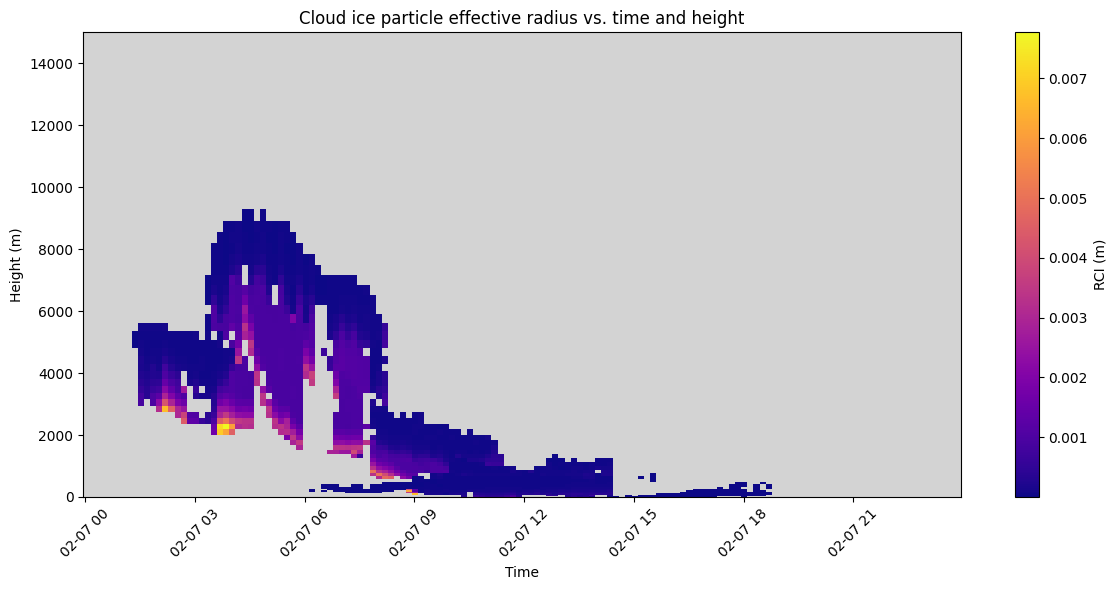

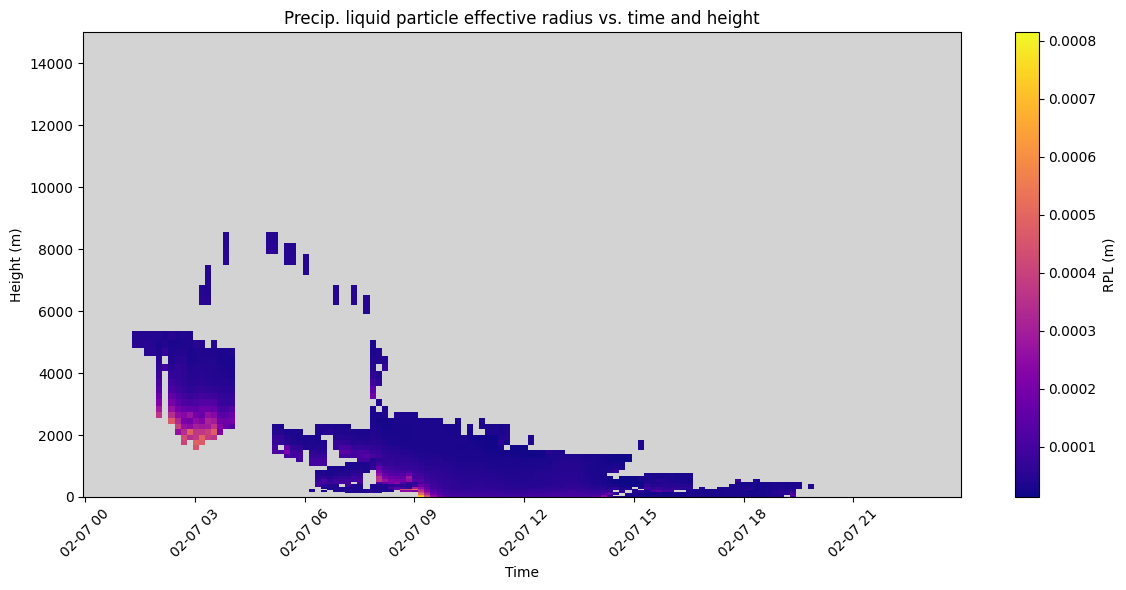

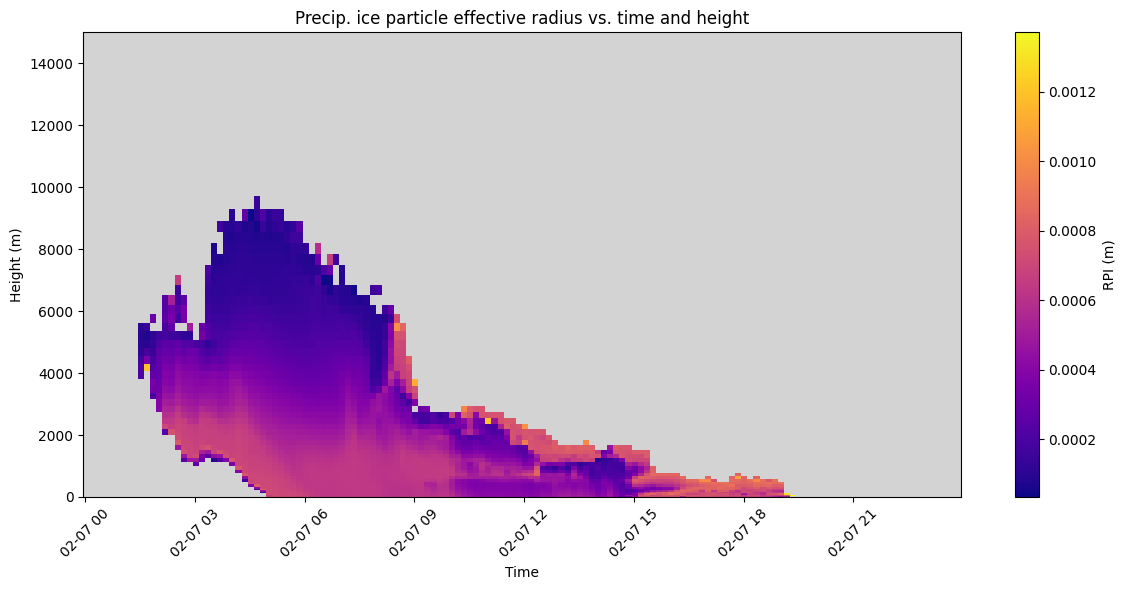

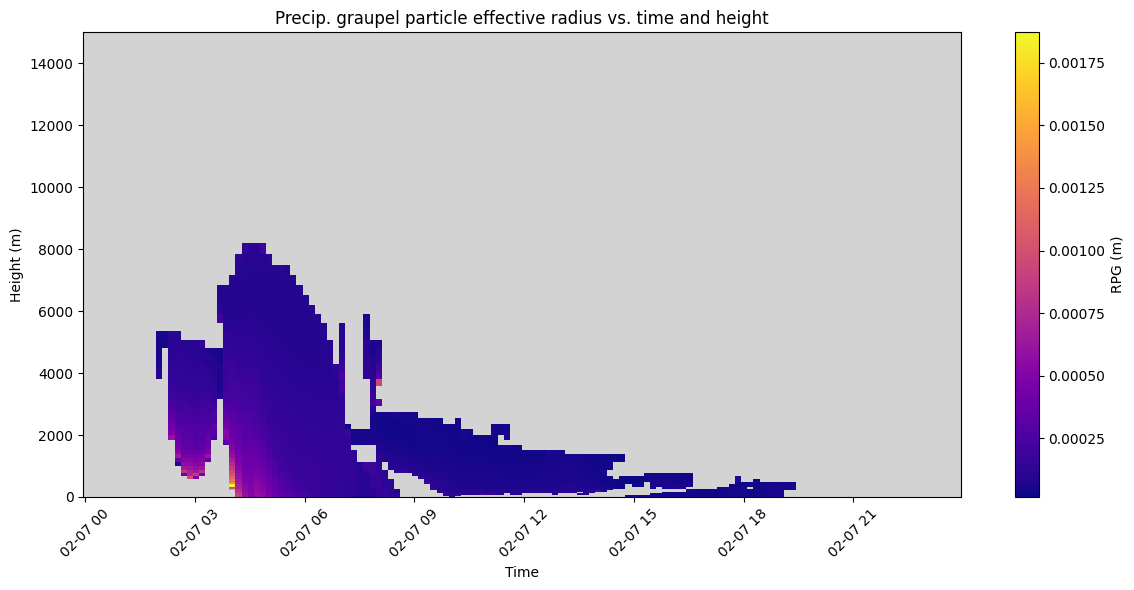

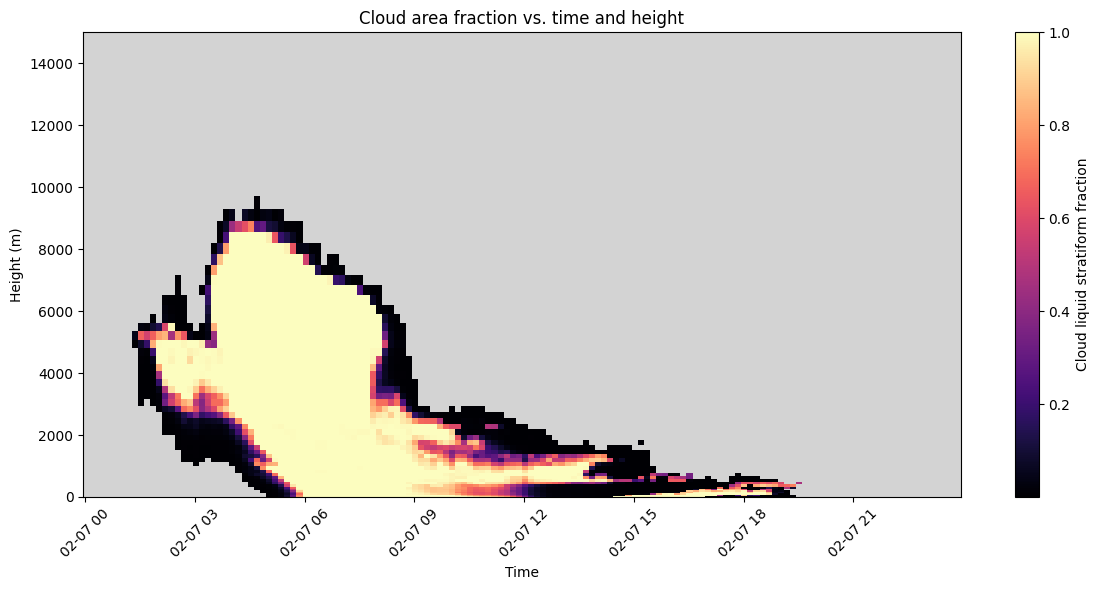

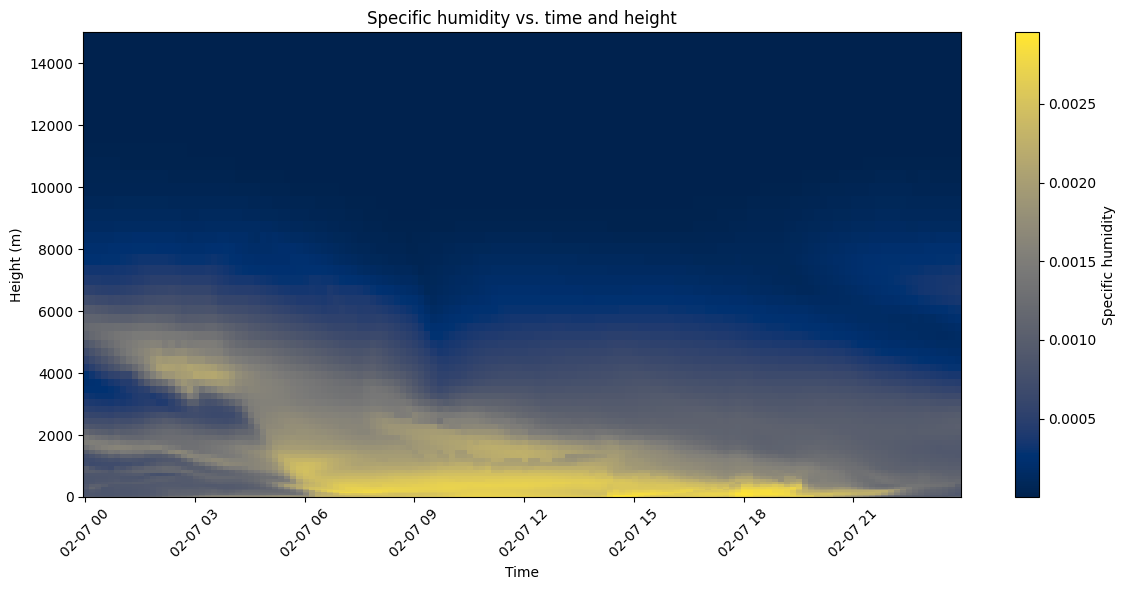

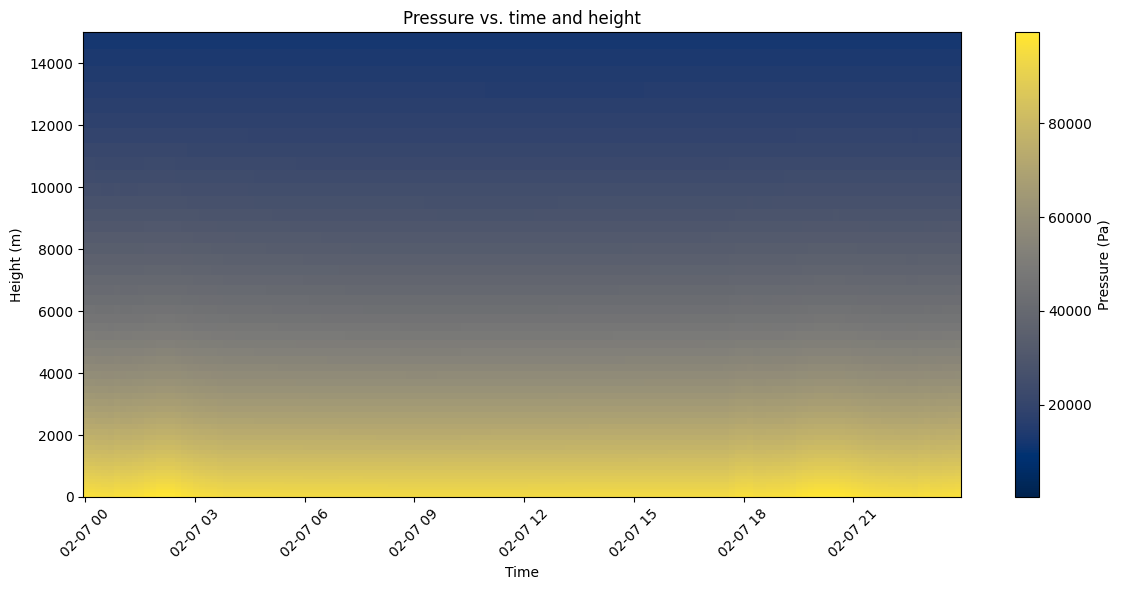

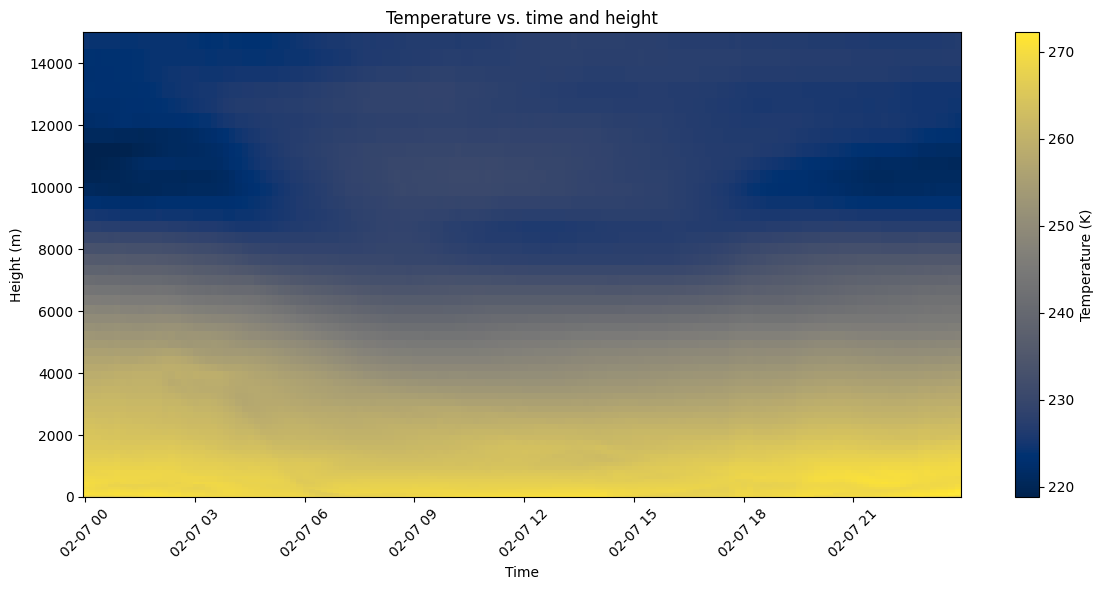

In [24]:
# Save plots of atmospheric properties from UM_reg output

# Save paths for images
plot_path = '/g/data/jk72/ck4840/projects/emc2/figs/um_reg/um_reg_output'

# Set the height limit for the plots
ylim_max = 15000

# Iterate across the list of daily files, loading each and saving plots of variables
for filepath in daily_UM_reg_list:
    
    # Load the current file
    daily_UM_reg_output = xr.open_dataset(filepath, engine = 'netcdf4')

    # Extract the date from the current file
    current_date = filepath.split('_')[4]
    current_date = current_date.split('.')[0]

    # if current_date == '20180203':
    #     continue
    
    # Create a meshgrid for time and height to be used for all plots produced from the current file
    time_mesh, height_mesh = np.meshgrid(daily_UM_reg_output['time'], daily_UM_reg_output['level_height'])

    # QCL
    # Extract the desired variable
    QCL = daily_UM_reg_output['mass_fraction_of_cloud_liquid_water_in_air']
    # Set QCL values equal to 0 to grey
    QCL_grey = np.where(QCL == 0, np.nan, QCL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QCL_grey.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QCL (kg/kg)')
    plt.title('Cloud liquid mass mixing ratio vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QCL = plt.gcf()
    # Save the plot
    daily_UM_reg_QCL.savefig(f'{plot_path}/UM_reg_QCL_{current_date}', dpi = 200)
    
    # QCF
    # Extract the desired variable
    QCF = daily_UM_reg_output['mass_fraction_of_cloud_ice_crystals_in_air']
    # Set QCF values equal to 0 to grey
    QCF_grey = np.where(QCF == 0, np.nan, QCF)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QCF_grey.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QCF (kg/kg)')
    plt.title('Cloud ice mass mixing ratio vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QCF = plt.gcf()
    # Save the plot
    daily_UM_reg_QCF.savefig(f'{plot_path}/UM_reg_QCF_{current_date}', dpi = 200)
    
    # QPL
    # Extract the desired variable
    QPL = daily_UM_reg_output['mass_fraction_of_rain_in_air']
    # Set QPL values equal to 0 to grey
    QPL_grey = np.where(QPL == 0, np.nan, QPL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPL_grey.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPL (kg/kg)')
    plt.title('Precip. liquid mass mixing ratio vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPL = plt.gcf()
    # Save the plot
    daily_UM_reg_QPL.savefig(f'{plot_path}/UM_reg_QPL_{current_date}', dpi = 200)
    
    # QPF
    # Extract the desired variable
    QPF = daily_UM_reg_output['mass_fraction_of_cloud_ice_in_air']
    # Set QPF values equal to 0 to grey
    QPF_grey = np.where(QPF == 0, np.nan, QPF)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPF_grey.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPF (kg/kg)')
    plt.title('Precip. ice mass mixing ratio vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPF = plt.gcf()
    # Save the plot
    daily_UM_reg_QPF.savefig(f'{plot_path}/UM_reg_QPF_{current_date}', dpi = 200)
    
    # QPG
    # Extract the desired variable
    QPG = daily_UM_reg_output['mass_fraction_of_graupel_in_air']
    # Set QPG values equal to 0 to grey
    QPG_grey = np.where(QPG == 0, np.nan, QPG)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, QPG_grey.T, cmap = 'viridis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'QPG (kg/kg)')
    plt.title('Precip. graupel mass mixing ratio vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_QPG = plt.gcf()
    # Save the plot
    daily_UM_reg_QPG.savefig(f'{plot_path}/UM_reg_QPG_{current_date}', dpi = 200)
    
    # NCL
    # Extract the desired variable
    NCL = daily_UM_reg_output['number_of_cloud_droplets_per_kg_of_air']
    # Set NCL values equal to 0 to grey
    NCL_grey = np.where(NCL == 0, np.nan, NCL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NCL_grey.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NCL (m^-3)')
    plt.title('Cloud liquid number concentration vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NCL = plt.gcf()
    # Save the plot
    daily_UM_reg_NCL.savefig(f'{plot_path}/UM_reg_NCL_{current_date}', dpi = 200)
    
    # NCF
    # Extract the desired variable
    NCF = daily_UM_reg_output['number_of_ice_particles_per_kg_of_air']
    # Set NCF values equal to 0 to grey
    NCF_grey = np.where(NCF == 0, np.nan, NCF)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NCF_grey.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NCF (m^-3)')
    plt.title('Cloud ice number concentration vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NCF = plt.gcf()
    # Save the plot
    daily_UM_reg_NCF.savefig(f'{plot_path}/UM_reg_NCF_{current_date}', dpi = 200)
    
    # NPL
    # Extract the desired variable
    NPL = daily_UM_reg_output['number_of_rain_drops_per_kg_of_air']
    # Set NPL values equal to 0 to grey
    NPL_grey = np.where(NPL == 0, np.nan, NPL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPL_grey.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPL (m^-3)')
    plt.title('Precip. liquid number concentration vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPL = plt.gcf()
    # Save the plot
    daily_UM_reg_NPL.savefig(f'{plot_path}/UM_reg_NPL_{current_date}', dpi = 200)
    
    # NPF
    # Extract the desired variable
    NPF = daily_UM_reg_output['number_of_snow_aggregates_per_kg_of_air']
    # Set NPF values equal to 0 to grey
    NPF_grey = np.where(NPF == 0, np.nan, NPF)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPF_grey.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPF (m^-3)')
    plt.title('Precip. ice number concentration vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPF = plt.gcf()
    # Save the plot
    daily_UM_reg_NPF.savefig(f'{plot_path}/UM_reg_NPF_{current_date}', dpi = 200)
    
    # NPG
    # Extract the desired variable
    NPG = daily_UM_reg_output['number_of_graupel_particles_per_kg_of_air']
    # Set NPG values equal to 0 to grey
    NPG_grey = np.where(NPG == 0, np.nan, NPG)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, NPG_grey.T, cmap = 'inferno', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'NPG (m^-3)')
    plt.title('Precip. graupel number concentration vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_NPG = plt.gcf()
    # Save the plot
    daily_UM_reg_NPG.savefig(f'{plot_path}/UM_reg_NPG_{current_date}', dpi = 200)
    
    # RCL
    # Extract the desired variable
    RCL = daily_UM_reg_output['cloud_liquid_effective_radius']
    # Set RCL values equal to 0 to grey
    RCL_grey = np.where(RCL == 0, np.nan, RCL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RCL_grey.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RCL (m)')
    plt.title('Cloud liquid particle effective radius vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RCL = plt.gcf()
    # Save the plot
    daily_UM_reg_RCL.savefig(f'{plot_path}/UM_reg_RCL_{current_date}', dpi = 200)
    
    # RCI
    # Extract the desired variable
    RCI = daily_UM_reg_output['cloud_ice_effective_radius']
    # Set RCI values equal to 0 to grey
    RCI_grey = np.where(RCI == 0, np.nan, RCI)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RCI_grey.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RCI (m)')
    plt.title('Cloud ice particle effective radius vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RCI = plt.gcf()
    # Save the plot
    daily_UM_reg_RCI.savefig(f'{plot_path}/UM_reg_RCI_{current_date}', dpi = 200)
    
    # RPL
    # Extract the desired variable
    RPL = daily_UM_reg_output['precip_liquid_effective_radius']
    # Set RPL values equal to 0 to grey
    RPL_grey = np.where(RPL == 0, np.nan, RPL)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPL_grey.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPL (m)')
    plt.title('Precip. liquid particle effective radius vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPL = plt.gcf()
    # Save the plot
    daily_UM_reg_RPL.savefig(f'{plot_path}/UM_reg_RPL_{current_date}', dpi = 200)
    
    # RPI
    # Extract the desired variable
    RPI = daily_UM_reg_output['precip_ice_effective_radius']
    # Set RPI values equal to 0 to grey
    RPI_grey = np.where(RPI == 0, np.nan, RPI)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPI_grey.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPI (m)')
    plt.title('Precip. ice particle effective radius vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPI = plt.gcf()
    # Save the plot
    daily_UM_reg_RPI.savefig(f'{plot_path}/UM_reg_RPI_{current_date}', dpi = 200)
    
    # RPG
    # Extract the desired variable
    RPG = daily_UM_reg_output['precip_graupel_effective_radius']
    # Set RPG values equal to 0 to grey
    RPG_grey = np.where(RPG == 0, np.nan, RPG)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, RPG_grey.T, cmap = 'plasma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'RPG (m)')
    plt.title('Precip. graupel particle effective radius vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_RPG = plt.gcf()
    # Save the plot
    daily_UM_reg_RPG.savefig(f'{plot_path}/UM_reg_RPG_{current_date}', dpi = 200)
    
    # Cloud liquid stratiform fraction
    # Extract the desired variable
    cl_strat_frac = daily_UM_reg_output['cloud_area_fraction_in_atmosphere_layer']
    # Set cl_strat_frac values equal to 0 to grey
    cl_strat_frac_grey = np.where(cl_strat_frac == 0, np.nan, cl_strat_frac)
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, cl_strat_frac_grey.T, cmap = 'magma', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Cloud liquid stratiform fraction')
    plt.title('Cloud area fraction vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_cl_strat_frac = plt.gcf()
    # Save the plot
    daily_UM_reg_cl_strat_frac.savefig(f'{plot_path}/UM_reg_cl_strat_frac_{current_date}', dpi = 200)

    # Water vapour mixing ratio
    # Extract the desired variable
    hus = daily_UM_reg_output['specific_humidity']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, hus.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Specific humidity')
    plt.title('Specific humidity vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_hus = plt.gcf()
    # Save the plot
    daily_UM_reg_hus.savefig(f'{plot_path}/UM_reg_specific_humidity_{current_date}', dpi = 200)

    # Pressure
    # Extract the desired variable
    pressure = daily_UM_reg_output['air_pressure']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, pressure.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Pressure (Pa)')
    plt.title('Pressure vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_pressure = plt.gcf()
    # Save the plot
    daily_UM_reg_pressure.savefig(f'{plot_path}/UM_reg_pressure_{current_date}', dpi = 200)

    # Temperature
    # Extract the desired variable
    temperature = daily_UM_reg_output['air_temperature']
    # Create the plot with a grey background
    plt.figure(figsize = (12, 6))
    plt.gca().set_facecolor('lightgrey')
    # Create and organise a pcolormesh plot
    pcm = plt.pcolormesh(time_mesh, height_mesh, temperature.T, cmap = 'cividis', shading = 'auto')
    plt.xlabel('Time')
    plt.ylabel('Height (m)')
    plt.colorbar(pcm, label = 'Temperature (K)')
    plt.title('Temperature vs. time and height')
    plt.ylim(0, ylim_max)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    daily_UM_reg_temperature = plt.gcf()
    # Save the plot
    daily_UM_reg_temperature.savefig(f'{plot_path}/UM_reg_temperature_{current_date}', dpi = 200)

print('Finished plotting')